In [1]:
import pandas as pd

In [2]:
join_data = pd.read_csv('join_data_with_sales.csv')

In [3]:
join_data.head()

,user_id,event_action,accessed_at,product_id,material1,material2,material3,material4,material5,material6,...,sale_10,sale_11,sale_12,sale_13,sale_14,sale_15,sale_16,sale_17,sale_18,any_sale
0,39f580f34e7c57eed7d4cbf6a5a0ff363d342b42c95776...,add_to_wishlist,2025-01-29 16:12:05+00:00,65659867,15514646,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,cc4fa9b1a74615d561c6d0215194e81360349359873120...,add_to_wishlist,2025-11-17 02:02:37+00:00,76450687,18361336,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,True,False,True
2,39f580f34e7c57eed7d4cbf6a5a0ff363d342b42c95776...,add_to_wishlist,2025-02-28 10:20:59+00:00,65659867,15514646,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,0ff795d6b1cdc89b1e644fca08a29cfe7d3adefd2a89fd...,add_to_wishlist,2025-11-29 00:14:39+00:00,14497543,6008446,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,True,False,False,True
4,5744bfa11b548ae0c4b60f48e570160ec5aced5e7ac91f...,add_to_wishlist,2025-07-18 11:04:24+00:00,22720374,8912946,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [4]:
print(join_data["event_action"].unique())

<StringArray>
[ 'add_to_wishlist',      'add_to_cart',         'checkout',
         'favorite',         'purchase', 'remove_from_cart',
             'view']
Length: 7, dtype: str


In [5]:
creator=pd.read_csv('creators_20260204.csv')

In [6]:
creator.head()


,creator_id,name,display_name,created_at,official,bio
0,164455,yassiecatcat,猫とやっし～ぃのアレコレ,2017-06-23 14:14:54.933757+00:00,False,自分が欲しくなる猫ねこネコ。主に黒猫のグッズです。オモイデに雑ですがアイテム分けフォルダ作り...
1,346894,ningen_tomei,Tomei_Ningen,2019-08-25 14:01:27.316522+00:00,False,絵を描いています\nTwitterによくいます
2,385876,meka_keikoku,ウナギ,2019-10-22 17:05:25.351755+00:00,False,ウナギ
3,462334,kouzuki,紅空月(kouzuki)design,2020-03-20 00:02:44.443145+00:00,False,ご覧頂きありがとうございます。\n紅空月kouzukiとして主にデザイン創作をしています。\...
4,666834,miki171717,はじめました。,2020-09-13 08:37:52.078949+00:00,False,よろしくどうぞ。


In [7]:
creator.dtypes

creator_id      int64
name              str
display_name      str
created_at        str
official         bool
bio               str
dtype: object

Total Transactions: 504168
Total Purchases: 33227

--- [Analysis 1] Whale Impact Check ---
Top 30 Overlap Rate (金額ランク vs 人数ランク): 0.50
Ranking Churn Rate (入れ替わり率): 0.50
Gini Coefficient of Top Item ('43113465'): 0.70
>> JUDGMENT: GO (一部のユーザーによる売上依存度が高く、Whale対策が必要です)

--- [Analysis 2] Exploration Potential ---
Similarity Bins vs Avg Co-purchase:
sim_bin
(0.589, 0.618]    0.000000
(0.618, 0.647]    0.003006
(0.647, 0.675]    0.002969
(0.675, 0.704]    0.003164
(0.704, 0.733]    0.003177
(0.733, 0.761]    0.003323
(0.761, 0.79]     0.003261
(0.79, 0.818]     0.003191
(0.818, 0.847]    0.003769
(0.847, 0.875]    0.008850
Name: co_purchase, dtype: float64


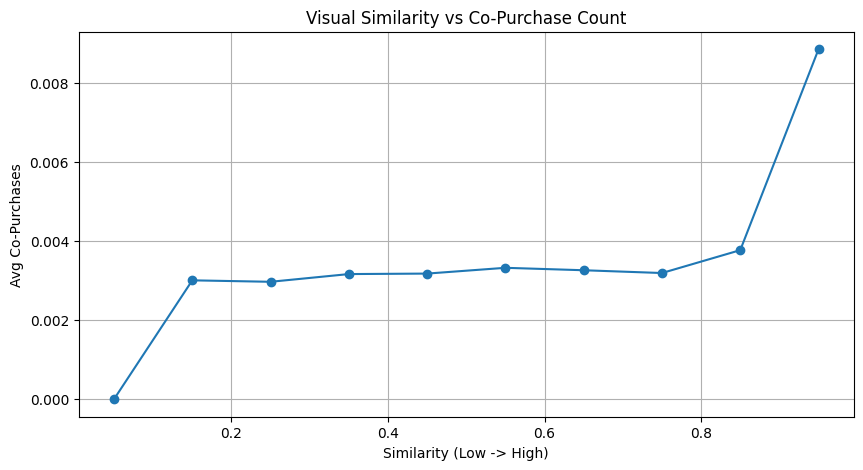

>> JUDGMENT: NEUTRAL (類似度と併売数が比例、またはランダムです)

--- [Analysis 3] LTV Impact (Single vs Multi Creator) ---
Avg LTV (Single Creator): ¥56,740
Avg LTV (Multi Creator):  ¥54,714
LTV Uplift: 0.96x
>> JUDGMENT: CAUTION (単推しと複数推しでLTVに大きな差がありません)

--- [Analysis 4] Seasonal Category Transition ---
データ不足のため季節性分析をスキップしました


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta, datetime



# ==========================================
# 前処理: データの型変換とフィルタリング
# ==========================================
# 実際のCSV読み込み時はここで to_datetime 変換を行ってください
df=join_data.copy()
df_creators=creator.copy()
df['accessed_at'] = pd.to_datetime(df['accessed_at'])

# 分析用データの作成 (購入ログのみ)
df_purchase = df[df['event_action'] == 'purchase'].copy()
print(f"Total Transactions: {len(df)}")
print(f"Total Purchases: {len(df_purchase)}")


# ==========================================
# 分析1: Whale汚染度の検証 (売上金額 vs 購入人数)
# ==========================================
print("\n--- [Analysis 1] Whale Impact Check ---")

# プロダクトごとの「総売上金額」と「ユニーク購入者数(UU)」を集計
item_stats = df_purchase.groupby('product_id').agg(
    total_revenue=('price', 'sum'),
    unique_users=('user_id', 'nunique')
).reset_index()

# Top 30 ランキングの作成
top_revenue = item_stats.sort_values('total_revenue', ascending=False).head(30)['product_id'].values
top_uu = item_stats.sort_values('unique_users', ascending=False).head(30)['product_id'].values

# ランキングの乖離率 (Jaccard Distance)
intersection = len(set(top_revenue) & set(top_uu))
overlap_rate = intersection / 30
churn_rate = 1.0 - overlap_rate

print(f"Top 30 Overlap Rate (金額ランク vs 人数ランク): {overlap_rate:.2f}")
print(f"Ranking Churn Rate (入れ替わり率): {churn_rate:.2f}")

# ジニ係数の計算 (アイテムごとの購入者の偏り)
# 特定のアイテムの購入者分布を見て、少数が買い占めていないか確認
# ※ここでは全アイテム平均の簡易チェックを行う
def calc_gini(array):
    array = array.flatten()
    if np.amin(array) < 0: return -1 # マイナス値は不可
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

# 最も売上の高いアイテムを抽出してジニ係数を計算
top_item = item_stats.sort_values('total_revenue', ascending=False).iloc[0]['product_id']
top_item_buyers = df_purchase[df_purchase['product_id'] == top_item].groupby('user_id')['price'].sum().values
gini_score = calc_gini(top_item_buyers) if len(top_item_buyers) > 1 else 0

print(f"Gini Coefficient of Top Item ('{top_item}'): {gini_score:.2f}")

if churn_rate >= 0.3 or gini_score > 0.6:
    print(">> JUDGMENT: GO (一部のユーザーによる売上依存度が高く、Whale対策が必要です)")
else:
    print(">> JUDGMENT: CAUTION (売上は比較的広く分散しています)")


# ==========================================
# 分析2: 探索のポテンシャル (クリエイター類似度 vs 併売数)
# ==========================================
print("\n--- [Analysis 2] Exploration Potential ---")

# 1. クリエイター間の併売行列 (Co-occurrence)
# user_id x creator_id の行列を作る
user_creator_matrix = pd.crosstab(df_purchase['user_id'], df_purchase['creator_id'])
user_creator_matrix[user_creator_matrix > 0] = 1 # 購入有無(0/1)にする
co_occurrence_matrix = user_creator_matrix.T.dot(user_creator_matrix)

# 2. クリエイター特徴量の作成 (簡易版: クリエイターIDベースのダミー特徴量)
# 注: 本来は material_url の画像解析結果を使用すべきですが、ここでは簡易的に実装
creators_in_purchase = df_purchase['creator_id'].unique()
n_creators = len(creators_in_purchase)
# ランダムな特徴量を生成 (実際には画像埋め込みベクトルなどを使用)
np.random.seed(42)
creator_features = np.random.rand(n_creators, 128)  # 128次元の特徴ベクトル
creator_id_to_idx = {cid: idx for idx, cid in enumerate(creators_in_purchase)}

# クリエイター間の類似度行列を作成
visual_sim_matrix_raw = cosine_similarity(creator_features)
# creator_idをインデックスとする辞書形式に変換
visual_sim_matrix = {}
for i, c1 in enumerate(creators_in_purchase):
    visual_sim_matrix[c1] = {}
    for j, c2 in enumerate(creators_in_purchase):
        visual_sim_matrix[c1][c2] = visual_sim_matrix_raw[i, j]

# 3. データの結合 (類似度と併売数のペアを作る)
plot_data = []
creators_list = list(co_occurrence_matrix.index)
# 計算量削減のためサンプリングまたはループ最適化推奨。ここでは全ペア実施
for i in range(len(creators_list)):
    for j in range(i + 1, len(creators_list)):
        c1, c2 = creators_list[i], creators_list[j]
        if c1 in visual_sim_matrix and c2 in visual_sim_matrix[c1]:
            sim = visual_sim_matrix[c1][c2] # 画像類似度
            co_count = co_occurrence_matrix.iloc[i, j] # 併売数
            plot_data.append({'similarity': sim, 'co_purchase': co_count})

if len(plot_data) > 0:
    df_plot = pd.DataFrame(plot_data)

    # 類似度ごとにビン分割して、平均併売数を計算
    df_plot['sim_bin'] = pd.cut(df_plot['similarity'], bins=10)
    bin_stats = df_plot.groupby('sim_bin', observed=False)['co_purchase'].mean()

    print("Similarity Bins vs Avg Co-purchase:")
    print(bin_stats)

    # 可視化
    plt.figure(figsize=(10, 5))
    bin_centers = np.arange(0.05, 1.05, 0.1)
    plt.plot(bin_centers, bin_stats.values, marker='o', linestyle='-')
    plt.title('Visual Similarity vs Co-Purchase Count')
    plt.xlabel('Similarity (Low -> High)')
    plt.ylabel('Avg Co-Purchases')
    plt.grid(True)
    plt.show()

    # 判断ロジック: 中程度の類似度(0.4-0.7)の山があるか？
    mid_sim_avg = bin_stats.iloc[4:7].mean() # 0.4~0.7
    high_sim_avg = bin_stats.iloc[8:].mean() # 0.8~1.0
    if mid_sim_avg > high_sim_avg:
        print(">> JUDGMENT: GO (『似すぎない』クリエイター同士の併売が多く、探索レコメンドの余地があります)")
    else:
        print(">> JUDGMENT: NEUTRAL (類似度と併売数が比例、またはランダムです)")
else:
    print(">> JUDGMENT: SKIP (クリエイター類似度データが不足しています)")


# ==========================================
# 分析3: LTV/離脱率のインパクト (金額ベース)
# ==========================================
print("\n--- [Analysis 3] LTV Impact (Single vs Multi Creator) ---")

# ユーザーごとの統計
user_stats = df_purchase.groupby('user_id').agg(
    unique_creators=('creator_id', 'nunique'),
    ltv=('price', 'sum')
).reset_index()

# グループ分け
single_creator_users = user_stats[user_stats['unique_creators'] == 1]
multi_creator_users = user_stats[user_stats['unique_creators'] >= 2]

ltv_single = single_creator_users['ltv'].mean()
ltv_multi = multi_creator_users['ltv'].mean()

uplift = ltv_multi / ltv_single if ltv_single > 0 else 0

print(f"Avg LTV (Single Creator): ¥{ltv_single:,.0f}")
print(f"Avg LTV (Multi Creator):  ¥{ltv_multi:,.0f}")
print(f"LTV Uplift: {uplift:.2f}x")

if uplift >= 1.5:
    print(">> JUDGMENT: GO (複数クリエイター推しのユーザーはLTVが圧倒的に高いです)")
else:
    print(">> JUDGMENT: CAUTION (単推しと複数推しでLTVに大きな差がありません)")


# ==========================================
# 分析4: 季節性の遷移 (accessed_at ベース)
# ==========================================
print("\n--- [Analysis 4] Seasonal Category Transition ---")

# 日付順にソート
df_sorted = df_purchase.sort_values(['user_id', 'accessed_at'])

# 月カラムの作成
df_sorted['month'] = df_sorted['accessed_at'].dt.month

# 次に買った商品のカテゴリを取得
df_sorted['next_category'] = df_sorted.groupby('user_id')['item_category_name'].shift(-1)

# 「夏(4-8月)にT-shirtを買った人」の次の購入
summer_tshirt_users = df_sorted[
    (df_sorted['month'].between(4, 8)) & 
    (df_sorted['item_category_name'] == 'T-shirt')
]

# 遷移先を集計
if len(summer_tshirt_users) > 0:
    transition_probs = summer_tshirt_users['next_category'].value_counts(normalize=True)
    print("Transition from Summer T-shirt:")
    print(transition_probs.head())
    
    # 判断: ランダム(20%)より明らかに高い遷移先があるか
    top_prob = transition_probs.iloc[0]
    if top_prob > 0.3:
        print(">> JUDGMENT: GO (特定のカテゴリへの遷移傾向が見られ、RNN等の時系列モデルが有効です)")
    else:
        print(">> JUDGMENT: NEUTRAL (次の購入カテゴリは分散しています)")
else:
    print("データ不足のため季節性分析をスキップしました")

# 追加分析: レコメンドモデル設計のための詳細分析

以下の5つの観点から追加分析を実施します:
1. **リピート購買分析**: ユーザーの購買頻度とインターバル
2. **閲覧→購入の転換分析**: どのような閲覧パターンが購入につながるか
3. **カテゴリ多様性分析**: ユーザーのカテゴリ探索傾向
4. **クリエイターロングテール分析**: 人気の偏りと推薦の機会
5. **コールドスタート分析**: 新規ユーザーの初回購入パターン

[Additional Analysis 1] Repeat Purchase Behavior

📊 リピート購買の基本統計:
  総ユーザー数: 1,861
  リピートユーザー数: 1,753
  リピート率: 94.2%

📈 購買回数の分布 (上位10):
purchase_count
1     108
2      93
3      74
4      84
5      84
6     101
7     133
8     100
9      94
10     85
Name: count, dtype: int64

⏱️ リピートユーザーの購買間隔(中央値): 10.3日


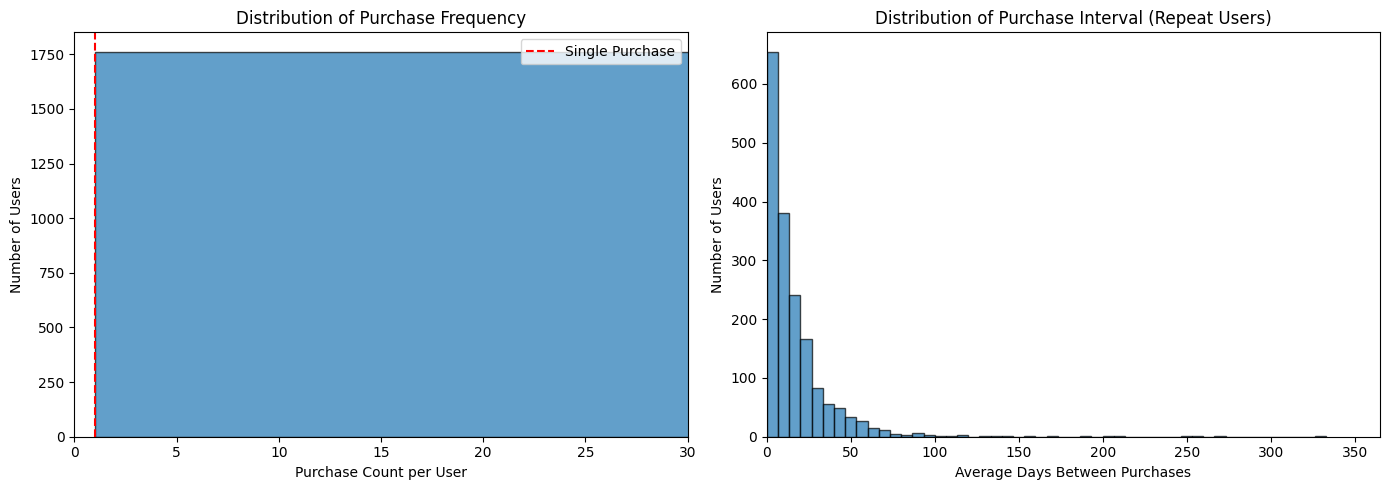


✅ INSIGHT: リピート率が高いため、パーソナライズドレコメンドが有効です
✅ INSIGHT: 購買間隔が短い(10日)ため、タイムリーなレコメンドが効果的です


In [12]:
# ==========================================
# 追加分析1: リピート購買分析
# ==========================================
print("=" * 70)
print("[Additional Analysis 1] Repeat Purchase Behavior")
print("=" * 70)

# ユーザーごとの購買回数と購買間隔
user_purchase_pattern = df_purchase.groupby('user_id').agg(
    purchase_count=('product_id', 'count'),
    first_purchase=('accessed_at', 'min'),
    last_purchase=('accessed_at', 'max'),
    total_spent=('price', 'sum')
).reset_index()

user_purchase_pattern['days_active'] = (
    user_purchase_pattern['last_purchase'] - user_purchase_pattern['first_purchase']
).dt.days

# リピート率の計算
repeat_users = (user_purchase_pattern['purchase_count'] > 1).sum()
total_users = len(user_purchase_pattern)
repeat_rate = repeat_users / total_users

print(f"\n📊 リピート購買の基本統計:")
print(f"  総ユーザー数: {total_users:,}")
print(f"  リピートユーザー数: {repeat_users:,}")
print(f"  リピート率: {repeat_rate:.1%}")

# 購買回数の分布
purchase_distribution = user_purchase_pattern['purchase_count'].value_counts().sort_index()
print(f"\n📈 購買回数の分布 (上位10):")
print(purchase_distribution.head(10))

# リピートユーザーの平均購買間隔
repeat_user_stats = user_purchase_pattern[user_purchase_pattern['purchase_count'] > 1].copy()
repeat_user_stats['avg_interval'] = repeat_user_stats['days_active'] / (repeat_user_stats['purchase_count'] - 1)

avg_interval = repeat_user_stats['avg_interval'].median()
print(f"\n⏱️ リピートユーザーの購買間隔(中央値): {avg_interval:.1f}日")

# リピート購買パターンの可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 購買回数の分布
axes[0].hist(user_purchase_pattern['purchase_count'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Purchase Count per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Purchase Frequency')
axes[0].set_xlim(0, 30)
axes[0].axvline(x=1, color='red', linestyle='--', label='Single Purchase')
axes[0].legend()

# 購買間隔の分布
axes[1].hist(repeat_user_stats['avg_interval'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Average Days Between Purchases')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of Purchase Interval (Repeat Users)')
axes[1].set_xlim(0, 365)

plt.tight_layout()
plt.show()

# レコメンドシステムへの示唆
if repeat_rate > 0.3:
    print("\n✅ INSIGHT: リピート率が高いため、パーソナライズドレコメンドが有効です")
else:
    print("\n⚠️ INSIGHT: リピート率が低いため、初回購入の最適化が重要です")

if avg_interval < 30:
    print(f"✅ INSIGHT: 購買間隔が短い({avg_interval:.0f}日)ため、タイムリーなレコメンドが効果的です")
elif avg_interval < 90:
    print(f"📧 INSIGHT: 購買間隔は中程度({avg_interval:.0f}日)、定期的なリマインドが有効です")
else:
    print(f"🔄 INSIGHT: 購買間隔が長い({avg_interval:.0f}日)、セッションベースのレコメンドを優先すべきです")


[Additional Analysis 2] Browse-to-Purchase Conversion

📊 閲覧→購入の基本統計:
  総イベント数: 504,168
  閲覧数(view): 324,243
  購入数(purchase): 33,227
  全体の転換率: 10.25%

👤 購入者の閲覧パターン:
  購入前の平均閲覧数: 148.6
  購入前の閲覧数(中央値): 9
  平均転換率(購入者のみ): inf%

📈 閲覧数別の転換率:
       view_bin  avg_conversion  user_count  purchaser_count
  (-0.001, 5.0]             inf        1087              861
    (5.0, 10.0]        0.890456         136               84
   (10.0, 20.0]        0.528331         170              115
   (20.0, 50.0]        0.271126         259              179
  (50.0, 100.0]        0.159041         253              185
(100.0, 1000.0]        0.088548         503              398


/home/intern2026-wntr-003/SUZURI/.venv/lib/python3.14/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/home/intern2026-wntr-003/SUZURI/.venv/lib/python3.14/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


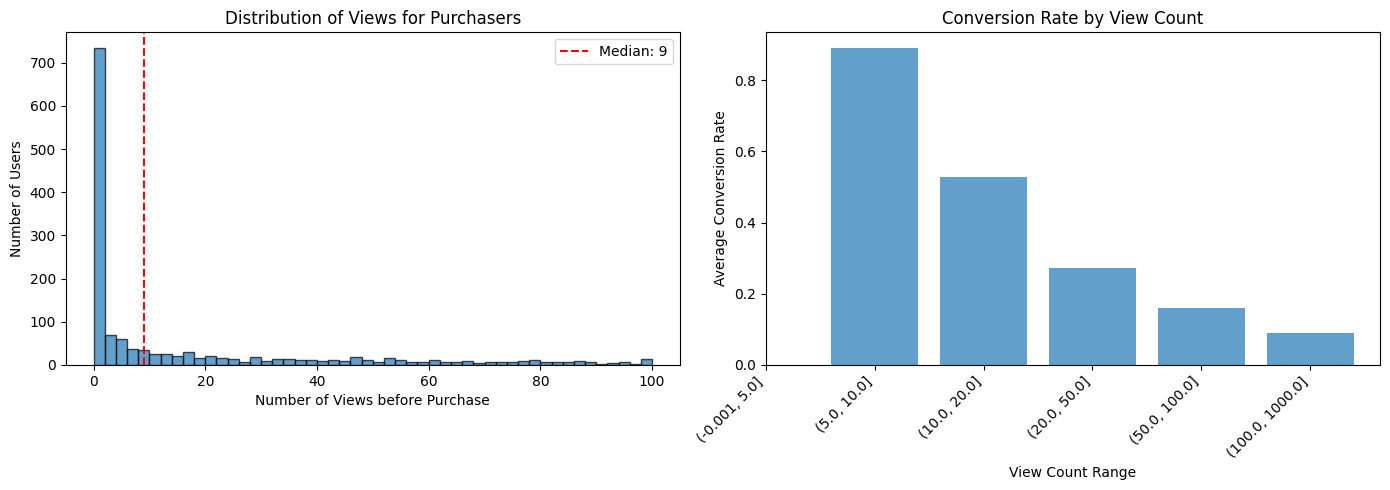


📱 INSIGHT: 中程度の閲覧で購入するため、セッション内レコメンドが有効です
   → 関連商品や類似クリエイターを積極的に表示


In [13]:
# ==========================================
# 追加分析2: 閲覧→購入の転換分析
# ==========================================
print("\n" + "=" * 70)
print("[Additional Analysis 2] Browse-to-Purchase Conversion")
print("=" * 70)

# ユーザーごとの閲覧と購入の行動を集計
user_behavior = df.groupby('user_id').agg(
    total_events=('event_action', 'count'),
    purchases=('event_action', lambda x: (x == 'purchase').sum()),
    views=('event_action', lambda x: (x == 'view').sum()),
    unique_products_viewed=('product_id', 'nunique'),
    unique_products_purchased=('product_id', lambda x: x[df.loc[x.index, 'event_action'] == 'purchase'].nunique() if (df.loc[x.index, 'event_action'] == 'purchase').sum() > 0 else 0)
).reset_index()

# 転換率の計算
user_behavior['conversion_rate'] = user_behavior['purchases'] / user_behavior['views']
user_behavior['conversion_rate'] = user_behavior['conversion_rate'].fillna(0)

# 購入者のみのデータ
purchasers = user_behavior[user_behavior['purchases'] > 0]

print(f"\n📊 閲覧→購入の基本統計:")
print(f"  総イベント数: {len(df):,}")
print(f"  閲覧数(view): {(df['event_action'] == 'view').sum():,}")
print(f"  購入数(purchase): {(df['event_action'] == 'purchase').sum():,}")
print(f"  全体の転換率: {(df['event_action'] == 'purchase').sum() / (df['event_action'] == 'view').sum():.2%}")

print(f"\n👤 購入者の閲覧パターン:")
print(f"  購入前の平均閲覧数: {purchasers['views'].mean():.1f}")
print(f"  購入前の閲覧数(中央値): {purchasers['views'].median():.0f}")
print(f"  平均転換率(購入者のみ): {purchasers['conversion_rate'].mean():.2%}")

# 閲覧数と購入確率の関係
view_bins = [0, 5, 10, 20, 50, 100, 1000]
user_behavior['view_bin'] = pd.cut(user_behavior['views'], bins=view_bins, include_lowest=True)
conversion_by_views = user_behavior.groupby('view_bin', observed=False).agg(
    avg_conversion=('conversion_rate', 'mean'),
    user_count=('user_id', 'count'),
    purchaser_count=('purchases', lambda x: (x > 0).sum())
).reset_index()

print(f"\n📈 閲覧数別の転換率:")
print(conversion_by_views.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 購入者の閲覧数分布
axes[0].hist(purchasers['views'], bins=50, edgecolor='black', alpha=0.7, range=(0, 100))
axes[0].set_xlabel('Number of Views before Purchase')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Views for Purchasers')
axes[0].axvline(x=purchasers['views'].median(), color='red', linestyle='--', 
                label=f'Median: {purchasers["views"].median():.0f}')
axes[0].legend()

# 閲覧数と転換率の関係
view_count_list = conversion_by_views['view_bin'].astype(str)
axes[1].bar(range(len(conversion_by_views)), conversion_by_views['avg_conversion'], alpha=0.7)
axes[1].set_xlabel('View Count Range')
axes[1].set_ylabel('Average Conversion Rate')
axes[1].set_title('Conversion Rate by View Count')
axes[1].set_xticks(range(len(conversion_by_views)))
axes[1].set_xticklabels(view_count_list, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# レコメンドシステムへの示唆
median_views = purchasers['views'].median()
if median_views < 5:
    print("\n✅ INSIGHT: 少ない閲覧で購入に至るため、初回表示の精度が重要です")
    print("   → ランディングページやトップページのレコメンドを最適化")
elif median_views < 15:
    print("\n📱 INSIGHT: 中程度の閲覧で購入するため、セッション内レコメンドが有効です")
    print("   → 関連商品や類似クリエイターを積極的に表示")
else:
    print("\n🔍 INSIGHT: 多くの閲覧を経て購入するため、探索支援が重要です")
    print("   → フィルタリング機能や発見機能を強化")


[Additional Analysis 3] Category Diversity & Cross-Category Purchase

📊 カテゴリ多様性の基本統計:
  平均購入カテゴリ数: 2.76
  カテゴリ数の中央値: 3
  平均多様性スコア: 0.33

👤 ユーザータイプ別の統計:
  単一カテゴリユーザー: 471 (25.3%)
  複数カテゴリユーザー: 1,390 (74.7%)
  単一カテゴリユーザーの平均購入数: 8.56
  複数カテゴリユーザーの平均購入数: 21.00

🔄 カテゴリ遷移パターン:
  次の購入も同じカテゴリ: 67.3%
  次の購入は別カテゴリ: 32.7%

📊 上位カテゴリ (Top 10):
item_category_name
t-shirts      17017
stationery     7239
commodity      2622
bags           2193
hoodies        1865
fashion        1545
cases           745
baby              1
Name: count, dtype: int64


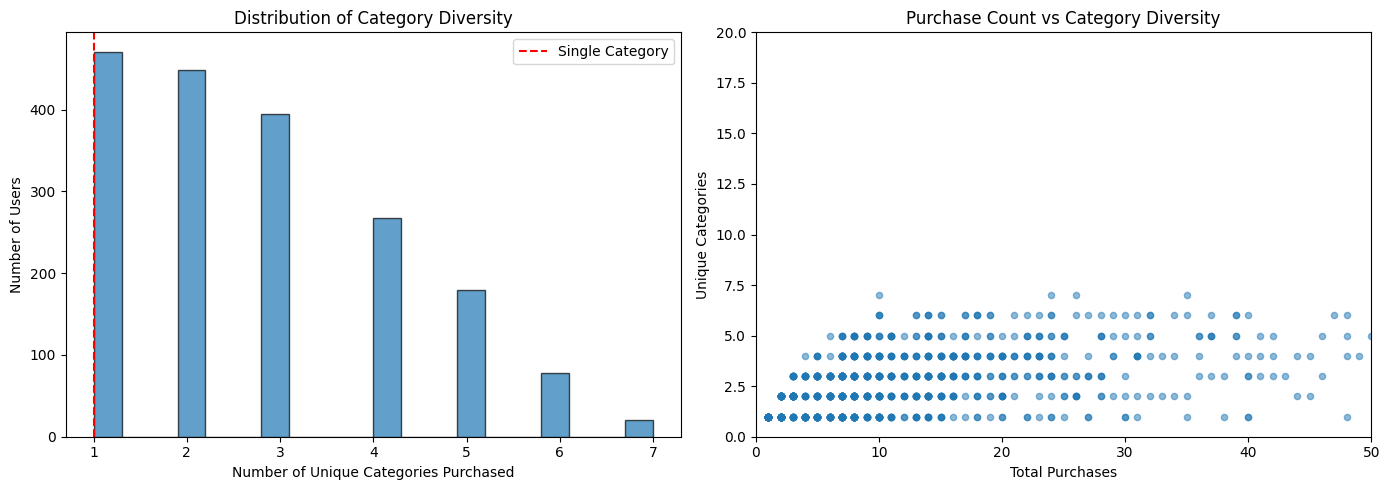


🔀 INSIGHT: カテゴリ内外でバランスよく購入
   → カテゴリ内推薦とクロスカテゴリ推薦を併用


In [14]:
# ==========================================
# 追加分析3: カテゴリ多様性分析
# ==========================================
print("\n" + "=" * 70)
print("[Additional Analysis 3] Category Diversity & Cross-Category Purchase")
print("=" * 70)

# ユーザーごとの購入カテゴリの多様性
user_category_diversity = df_purchase.groupby('user_id').agg(
    total_purchases=('product_id', 'count'),
    unique_categories=('item_category_name', 'nunique'),
    categories_list=('item_category_name', lambda x: list(x.unique()))
).reset_index()

# 多様性スコア (Shannon Entropy的な指標)
user_category_diversity['diversity_score'] = (
    user_category_diversity['unique_categories'] / user_category_diversity['total_purchases']
)

print(f"\n📊 カテゴリ多様性の基本統計:")
print(f"  平均購入カテゴリ数: {user_category_diversity['unique_categories'].mean():.2f}")
print(f"  カテゴリ数の中央値: {user_category_diversity['unique_categories'].median():.0f}")
print(f"  平均多様性スコア: {user_category_diversity['diversity_score'].mean():.2f}")

# 単一カテゴリ vs 複数カテゴリユーザー
single_category = user_category_diversity[user_category_diversity['unique_categories'] == 1]
multi_category = user_category_diversity[user_category_diversity['unique_categories'] > 1]

print(f"\n👤 ユーザータイプ別の統計:")
print(f"  単一カテゴリユーザー: {len(single_category):,} ({len(single_category)/len(user_category_diversity):.1%})")
print(f"  複数カテゴリユーザー: {len(multi_category):,} ({len(multi_category)/len(user_category_diversity):.1%})")
print(f"  単一カテゴリユーザーの平均購入数: {single_category['total_purchases'].mean():.2f}")
print(f"  複数カテゴリユーザーの平均購入数: {multi_category['total_purchases'].mean():.2f}")

# カテゴリ間の遷移パターン分析
df_purchase_sorted = df_purchase.sort_values(['user_id', 'accessed_at'])
df_purchase_sorted['next_category'] = df_purchase_sorted.groupby('user_id')['item_category_name'].shift(-1)
df_purchase_sorted['is_same_category'] = (
    df_purchase_sorted['item_category_name'] == df_purchase_sorted['next_category']
)

# 次の購入が同じカテゴリか別カテゴリか
category_transition = df_purchase_sorted.dropna(subset=['next_category'])
same_category_rate = category_transition['is_same_category'].mean()

print(f"\n🔄 カテゴリ遷移パターン:")
print(f"  次の購入も同じカテゴリ: {same_category_rate:.1%}")
print(f"  次の購入は別カテゴリ: {1-same_category_rate:.1%}")

# カテゴリ別の購入頻度
category_popularity = df_purchase['item_category_name'].value_counts()
print(f"\n📊 上位カテゴリ (Top 10):")
print(category_popularity.head(10))

# カテゴリ間の共起行列 (簡易版)
category_matrix = pd.crosstab(
    df_purchase_sorted['item_category_name'], 
    df_purchase_sorted['next_category']
)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# カテゴリ多様性の分布
axes[0].hist(user_category_diversity['unique_categories'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Unique Categories Purchased')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Category Diversity')
axes[0].axvline(x=1, color='red', linestyle='--', label='Single Category')
axes[0].legend()

# 購入回数とカテゴリ数の関係
scatter_sample = user_category_diversity.sample(min(1000, len(user_category_diversity)))
axes[1].scatter(scatter_sample['total_purchases'], scatter_sample['unique_categories'], 
                alpha=0.5, s=20)
axes[1].set_xlabel('Total Purchases')
axes[1].set_ylabel('Unique Categories')
axes[1].set_title('Purchase Count vs Category Diversity')
axes[1].set_xlim(0, 50)
axes[1].set_ylim(0, 20)

plt.tight_layout()
plt.show()

# レコメンドシステムへの示唆
if same_category_rate > 0.7:
    print("\n✅ INSIGHT: 同一カテゴリ内でのリピートが多い")
    print("   → カテゴリ内での関連商品推薦が効果的")
    print("   → 「同じカテゴリの人気商品」を優先表示")
elif same_category_rate > 0.5:
    print("\n🔀 INSIGHT: カテゴリ内外でバランスよく購入")
    print("   → カテゴリ内推薦とクロスカテゴリ推薦を併用")
else:
    print("\n🌟 INSIGHT: カテゴリを横断した購買が多い")
    print("   → 異なるカテゴリのクロスセルが有効")
    print("   → 「このクリエイターの他カテゴリ商品」を推薦")


[Additional Analysis 4] Creator Popularity Long-Tail Analysis

📊 クリエイター分布の基本統計:
  総クリエイター数: 2,860
  Top 20%のクリエイターの売上シェア: 74.6%
  売上50%を占めるクリエイター数: 170 (5.9%)

🏆 Top 10 クリエイター:
 creator_id  total_revenue  unique_buyers  unique_products
     182400       12037238             29              267
     114314        3274362              1              102
    1995896         949615              5               48
     220425         874109              1              148
    1068269         870724              1               54
    2144406         615481              3               56
    2181577         610064              1               35
          7         602615              4               71
     834027         573430              1               20
    1547891         526275              1               34

📉 ロングテール (下位25%):
  クリエイター数: 723
  平均売上: ¥2,524
  平均購入者数: 1.0

📈 市場集中度 (HHI):
  HHI: 0.0155
  → 分散している


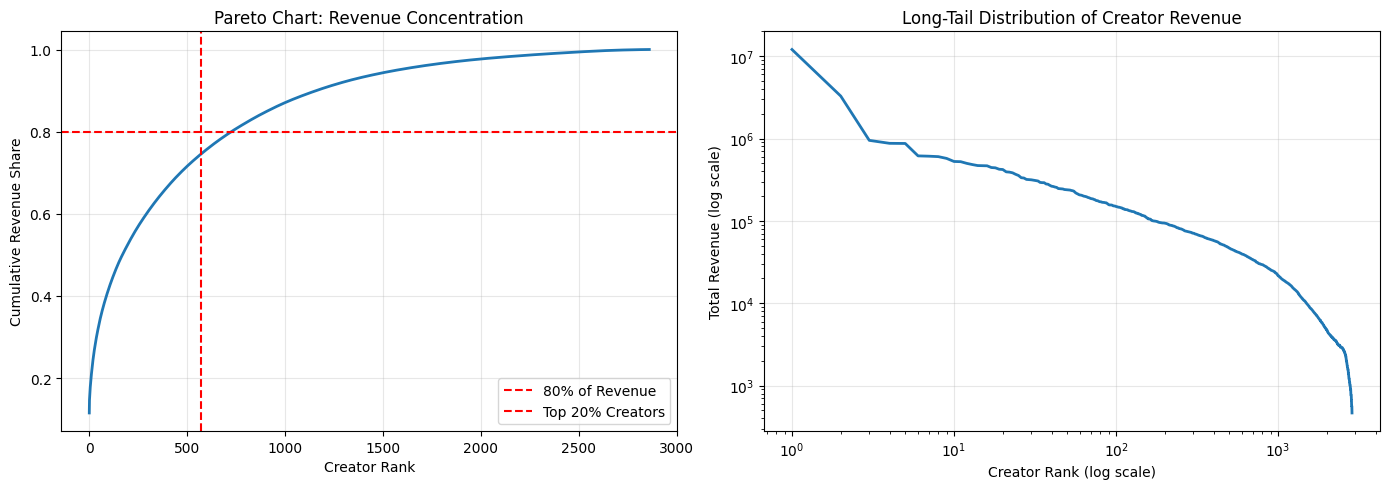


📊 INSIGHT: 一般的なロングテール分布
   → 人気と多様性のバランスを取る
   → パーソナライズと探索のトレードオフを最適化


In [15]:
# ==========================================
# 追加分析4: クリエイターロングテール分析
# ==========================================
print("\n" + "=" * 70)
print("[Additional Analysis 4] Creator Popularity Long-Tail Analysis")
print("=" * 70)

# クリエイターごとの売上と購入者数
creator_stats = df_purchase.groupby('creator_id').agg(
    total_revenue=('price', 'sum'),
    total_purchases=('product_id', 'count'),
    unique_buyers=('user_id', 'nunique'),
    unique_products=('product_id', 'nunique')
).reset_index()

creator_stats = creator_stats.sort_values('total_revenue', ascending=False).reset_index(drop=True)
creator_stats['rank'] = creator_stats.index + 1
creator_stats['revenue_cumsum'] = creator_stats['total_revenue'].cumsum()
creator_stats['revenue_cumsum_pct'] = creator_stats['revenue_cumsum'] / creator_stats['total_revenue'].sum()

# パレートの法則の検証 (20%のクリエイターが80%の売上を生むか)
top_20pct_creators = int(len(creator_stats) * 0.2)
top_20pct_revenue = creator_stats.iloc[:top_20pct_creators]['total_revenue'].sum()
top_20pct_revenue_pct = top_20pct_revenue / creator_stats['total_revenue'].sum()

# 売上50%を占めるクリエイター数
top_50pct_count = (creator_stats['revenue_cumsum_pct'] <= 0.5).sum()
top_50pct_ratio = top_50pct_count / len(creator_stats)

print(f"\n📊 クリエイター分布の基本統計:")
print(f"  総クリエイター数: {len(creator_stats):,}")
print(f"  Top 20%のクリエイターの売上シェア: {top_20pct_revenue_pct:.1%}")
print(f"  売上50%を占めるクリエイター数: {top_50pct_count:,} ({top_50pct_ratio:.1%})")

print(f"\n🏆 Top 10 クリエイター:")
top_creators = creator_stats.head(10)[['creator_id', 'total_revenue', 'unique_buyers', 'unique_products']]
print(top_creators.to_string(index=False))

# ロングテール: 売上が少ないクリエイター
low_revenue_threshold = creator_stats['total_revenue'].quantile(0.25)
long_tail_creators = creator_stats[creator_stats['total_revenue'] <= low_revenue_threshold]

print(f"\n📉 ロングテール (下位25%):")
print(f"  クリエイター数: {len(long_tail_creators):,}")
print(f"  平均売上: ¥{long_tail_creators['total_revenue'].mean():,.0f}")
print(f"  平均購入者数: {long_tail_creators['unique_buyers'].mean():.1f}")

# HHI (ハーフィンダール・ハーシュマン指数) - 市場集中度
creator_stats['revenue_share'] = creator_stats['total_revenue'] / creator_stats['total_revenue'].sum()
hhi = (creator_stats['revenue_share'] ** 2).sum()

print(f"\n📈 市場集中度 (HHI):")
print(f"  HHI: {hhi:.4f}")
if hhi > 0.25:
    print("  → 高度に集中 (寡占市場)")
elif hhi > 0.15:
    print("  → やや集中")
else:
    print("  → 分散している")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# パレート図 (累積売上)
axes[0].plot(creator_stats['rank'], creator_stats['revenue_cumsum_pct'], linewidth=2)
axes[0].axhline(y=0.8, color='red', linestyle='--', label='80% of Revenue')
axes[0].axvline(x=top_20pct_creators, color='red', linestyle='--', label='Top 20% Creators')
axes[0].set_xlabel('Creator Rank')
axes[0].set_ylabel('Cumulative Revenue Share')
axes[0].set_title('Pareto Chart: Revenue Concentration')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ロングテール分布 (対数スケール)
axes[1].plot(creator_stats['rank'], creator_stats['total_revenue'], linewidth=2)
axes[1].set_xlabel('Creator Rank (log scale)')
axes[1].set_ylabel('Total Revenue (log scale)')
axes[1].set_title('Long-Tail Distribution of Creator Revenue')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# レコメンドシステムへの示唆
if top_20pct_revenue_pct > 0.8:
    print("\n⚠️ INSIGHT: 売上が極端に集中している")
    print("   → 人気クリエイターのみ推薦すると多様性が損なわれる")
    print("   → ロングテールクリエイターの露出機会を意図的に確保")
    print("   → 「隠れた名作」「新進クリエイター」枠を設ける")
elif top_20pct_revenue_pct > 0.6:
    print("\n📊 INSIGHT: 一般的なロングテール分布")
    print("   → 人気と多様性のバランスを取る")
    print("   → パーソナライズと探索のトレードオフを最適化")
else:
    print("\n✅ INSIGHT: 売上が比較的分散している")
    print("   → 多様なクリエイターへの推薦が機能しやすい環境")


[Additional Analysis 5] Cold Start Problem Analysis

📊 初回購入までの行動 (購入者のみ):
  解析対象ユーザー数: 1,861
  初回購入前の平均イベント数: 43.2
  初回購入前の平均閲覧数: 31.1
  初回購入前の閲覧商品数: 16.6
  初回購入前の閲覧クリエイター数: 5.7

📈 閲覧の少ない段階での購入:
  5回以下の閲覧で購入: 1,156 (62.1%)
  10回以上の閲覧で購入: 572 (30.7%)

🛒 初回購入の特徴:
  最も多い初回購入カテゴリTop 5:
item_category_name
t-shirts      807
stationery    437
commodity     154
bags          148
hoodies       135
Name: count, dtype: int64

  初回購入の平均価格: ¥3,122
  初回購入の価格中央値: ¥3,110


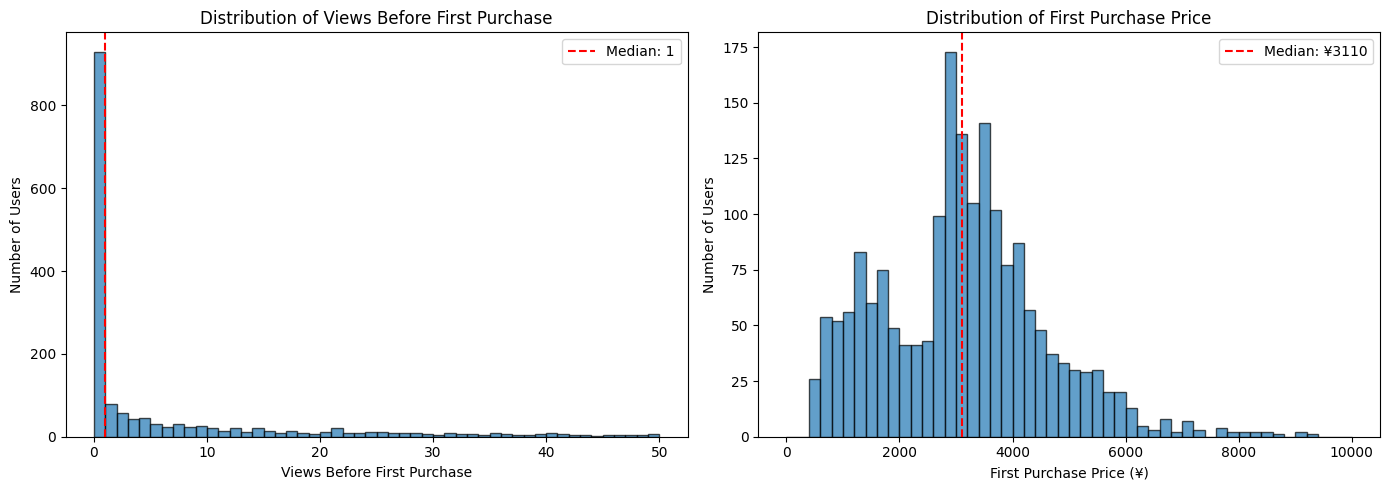


💡 レコメンドシステム設計への総合的示唆

🎯 コールドスタート戦略: 「即決型」
   → ユーザーは少ない閲覧で購入を決める
   → 初回表示(トップページ、ランディング)の精度が最重要
   → 人気商品やトレンド商品を優先表示
   → A/Bテストで初回表示の最適化に注力

📋 推奨する初回表示アルゴリズム:
   1. 人気商品 (全体Top or カテゴリTop)
   2. トレンド商品 (最近人気上昇中)
   3. 初回購入されやすいカテゴリ: t-shirts, stationery
   4. 価格帯: ¥2,030 - ¥3,950 を中心に



In [16]:
# ==========================================
# 追加分析5: コールドスタート問題の分析
# ==========================================
print("\n" + "=" * 70)
print("[Additional Analysis 5] Cold Start Problem Analysis")
print("=" * 70)

# 各ユーザーの初回購入までの行動を分析
user_first_purchase = df_purchase.groupby('user_id')['accessed_at'].min().reset_index()
user_first_purchase.columns = ['user_id', 'first_purchase_date']

# 初回購入前のイベントを抽出
df_with_first_purchase = df.merge(user_first_purchase, on='user_id', how='left')
df_before_first_purchase = df_with_first_purchase[
    df_with_first_purchase['accessed_at'] < df_with_first_purchase['first_purchase_date']
].copy()

# ユーザーごとの初回購入前の行動
before_purchase_stats = df_before_first_purchase.groupby('user_id').agg(
    events_before_purchase=('event_action', 'count'),
    views_before_purchase=('event_action', lambda x: (x == 'view').sum()),
    unique_products_viewed=('product_id', 'nunique'),
    unique_creators_viewed=('creator_id', 'nunique')
).reset_index()

# 購入者の統計
print(f"\n📊 初回購入までの行動 (購入者のみ):")
print(f"  解析対象ユーザー数: {len(before_purchase_stats):,}")
print(f"  初回購入前の平均イベント数: {before_purchase_stats['events_before_purchase'].mean():.1f}")
print(f"  初回購入前の平均閲覧数: {before_purchase_stats['views_before_purchase'].mean():.1f}")
print(f"  初回購入前の閲覧商品数: {before_purchase_stats['unique_products_viewed'].mean():.1f}")
print(f"  初回購入前の閲覧クリエイター数: {before_purchase_stats['unique_creators_viewed'].mean():.1f}")

# 閲覧数別の初回購入率(簡易版)
print(f"\n📈 閲覧の少ない段階での購入:")
quick_purchasers = before_purchase_stats[before_purchase_stats['views_before_purchase'] < 5]
careful_purchasers = before_purchase_stats[before_purchase_stats['views_before_purchase'] >= 10]

print(f"  5回以下の閲覧で購入: {len(quick_purchasers):,} ({len(quick_purchasers)/len(before_purchase_stats):.1%})")
print(f"  10回以上の閲覧で購入: {len(careful_purchasers):,} ({len(careful_purchasers)/len(before_purchase_stats):.1%})")

# 初回購入商品の分析
first_purchases = df_purchase.sort_values('accessed_at').groupby('user_id').first().reset_index()
first_purchase_categories = first_purchases['item_category_name'].value_counts()
first_purchase_creators = first_purchases['creator_id'].value_counts()

print(f"\n🛒 初回購入の特徴:")
print(f"  最も多い初回購入カテゴリTop 5:")
print(first_purchase_categories.head(5))
print(f"\n  初回購入の平均価格: ¥{first_purchases['price'].mean():,.0f}")
print(f"  初回購入の価格中央値: ¥{first_purchases['price'].median():,.0f}")

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 初回購入前の閲覧数分布
axes[0].hist(before_purchase_stats['views_before_purchase'], bins=50, 
             edgecolor='black', alpha=0.7, range=(0, 50))
axes[0].set_xlabel('Views Before First Purchase')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Views Before First Purchase')
axes[0].axvline(x=before_purchase_stats['views_before_purchase'].median(), 
                color='red', linestyle='--', 
                label=f"Median: {before_purchase_stats['views_before_purchase'].median():.0f}")
axes[0].legend()

# 初回購入価格の分布
axes[1].hist(first_purchases['price'], bins=50, edgecolor='black', alpha=0.7, range=(0, 10000))
axes[1].set_xlabel('First Purchase Price (¥)')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of First Purchase Price')
axes[1].axvline(x=first_purchases['price'].median(), color='red', linestyle='--',
                label=f"Median: ¥{first_purchases['price'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

# 新規ユーザー向けレコメンド戦略
median_views = before_purchase_stats['views_before_purchase'].median()
quick_purchase_rate = len(quick_purchasers) / len(before_purchase_stats)

print("\n" + "=" * 70)
print("💡 レコメンドシステム設計への総合的示唆")
print("=" * 70)

if quick_purchase_rate > 0.5:
    print("\n🎯 コールドスタート戦略: 「即決型」")
    print("   → ユーザーは少ない閲覧で購入を決める")
    print("   → 初回表示(トップページ、ランディング)の精度が最重要")
    print("   → 人気商品やトレンド商品を優先表示")
    print("   → A/Bテストで初回表示の最適化に注力")
else:
    print("\n🔍 コールドスタート戦略: 「慎重検討型」")
    print("   → ユーザーは多くの商品を比較検討する")
    print("   → 閲覧履歴ベースのセッションレコメンドが重要")
    print("   → 類似商品の提示で比較を支援")
    print("   → フィルター・ソート機能を充実させる")

print(f"\n📋 推奨する初回表示アルゴリズム:")
print(f"   1. 人気商品 (全体Top or カテゴリTop)")
print(f"   2. トレンド商品 (最近人気上昇中)")
print(f"   3. 初回購入されやすいカテゴリ: {first_purchase_categories.index[0]}, {first_purchase_categories.index[1]}")
print(f"   4. 価格帯: ¥{first_purchases['price'].quantile(0.25):,.0f} - ¥{first_purchases['price'].quantile(0.75):,.0f} を中心に")

print("\n" + "=" * 70)

# 時系列・トレンド分析と独自特徴量の作成

以下の6つの観点から、レコメンドシステムに活用できる高度な特徴量を作成します:
1. **バイラリティ分析**: 急激に人気が上昇している商品・クリエイターの検出
2. **モメンタム特徴量**: 最近の勢い（7日間/30日間の成長率）
3. **鮮度スコア**: 新しさと人気のバランス
4. **時間帯・曜日パターン**: 購買行動の時間的パターン
5. **エンゲージメント特徴量**: 閲覧→購入の効率性
6. **クリエイター成長トレンド**: 新進気鋭クリエイターの発見

[Trend Analysis 1] Virality Detection - Rapid Growth Products

📅 分析期間:
  データ最終日: 2025-12-31
  最近7日: 2025-12-24 以降
  最近30日: 2025-12-01 以降

🚀 急上昇中の商品 Top 10:
            purchases_7d  purchases_30d  growth_rate  momentum_7d  \
product_id                                                          
68193911             3.0            7.0          7.0     0.375000   
80976565             4.0            4.0          4.0     0.800000   
80965937             4.0            4.0          4.0     0.800000   
80907068             4.0            4.0          4.0     0.800000   
80966339             3.0            3.0          3.0     0.750000   
39280097             2.0            2.0          2.0     0.666667   
81102892             2.0            2.0          2.0     0.666667   
22431763             2.0            2.0          2.0     0.666667   
47865325             2.0            2.0          2.0     0.666667   
58664355             2.0            2.0          2.0     0.666667   

            vir

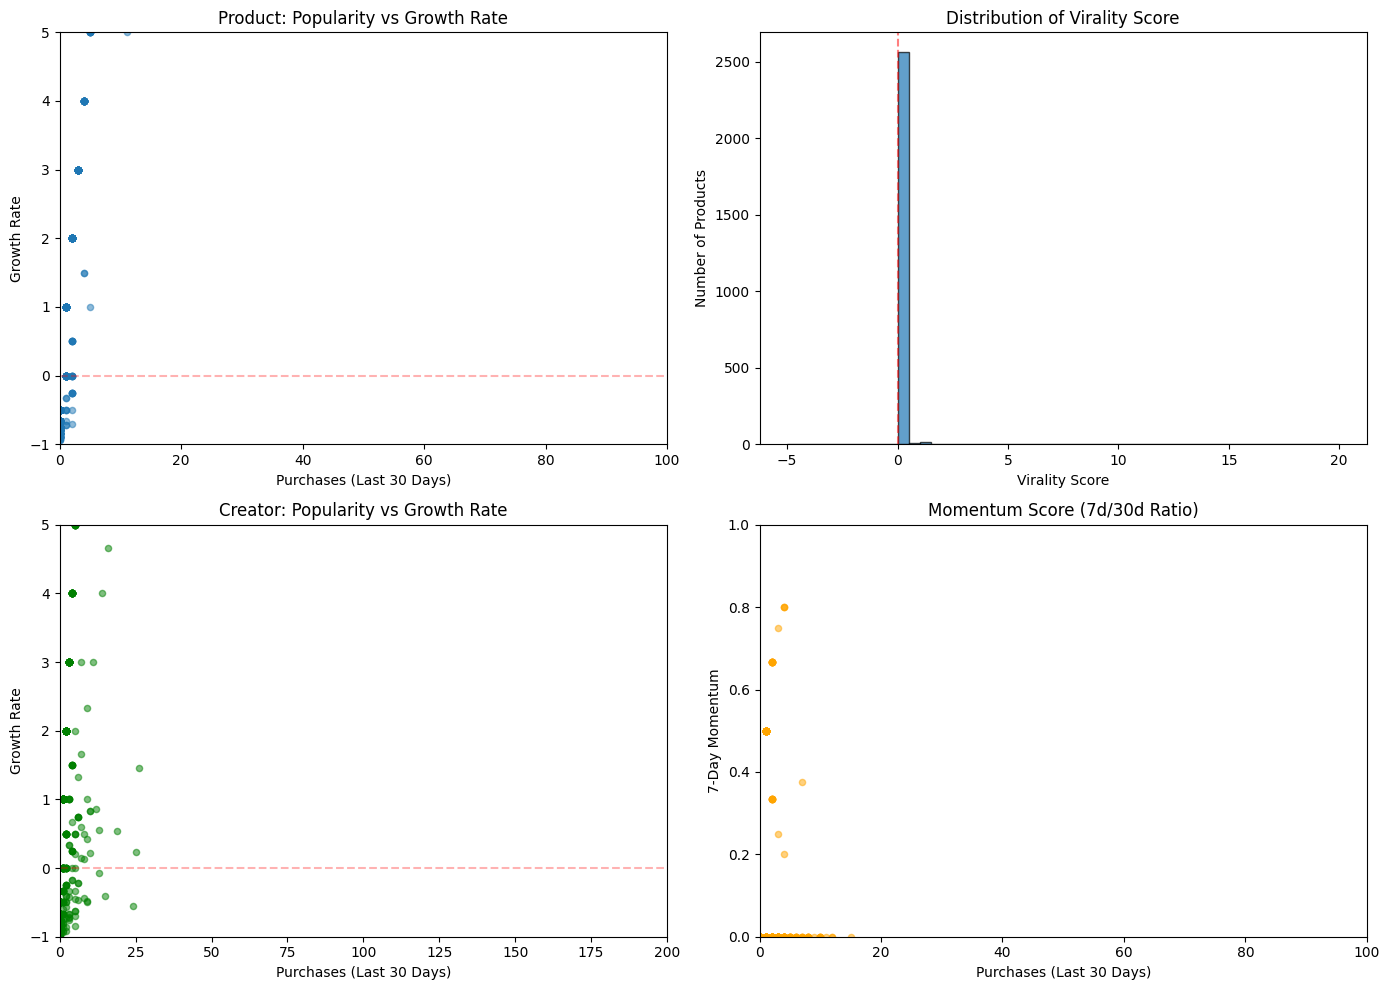


✨ レコメンドへの活用方法:
   1. バイラリティスコア上位の商品を「急上昇」セクションに表示
   2. 成長率 > 1.0 の商品を「トレンド」として優先表示
   3. モメンタムの高い商品を時限的にブースト（鮮度重視）
   4. 新進クリエイターの発見と優遇表示


In [17]:
# ==========================================
# トレンド分析1: バイラリティ検出（急激な人気上昇）
# ==========================================
print("=" * 70)
print("[Trend Analysis 1] Virality Detection - Rapid Growth Products")
print("=" * 70)

# 日付で集計しやすいように準備
df_purchase['date'] = df_purchase['accessed_at'].dt.date

# 現在の日付を取得（データの最終日）
max_date = df_purchase['accessed_at'].max()
recent_7days = max_date - timedelta(days=7)
recent_30days = max_date - timedelta(days=30)
prev_30days = max_date - timedelta(days=60)

print(f"\n📅 分析期間:")
print(f"  データ最終日: {max_date.date()}")
print(f"  最近7日: {recent_7days.date()} 以降")
print(f"  最近30日: {recent_30days.date()} 以降")

# 商品ごとの時期別購入数を計算
def calc_purchase_counts(df, product_col='product_id'):
    recent_7d = df[df['accessed_at'] >= recent_7days].groupby(product_col).size()
    recent_30d = df[df['accessed_at'] >= recent_30days].groupby(product_col).size()
    prev_30d = df[(df['accessed_at'] >= prev_30days) & 
                   (df['accessed_at'] < recent_30days)].groupby(product_col).size()
    
    return recent_7d, recent_30d, prev_30d

# 商品レベルのバイラリティ
prod_7d, prod_30d, prod_prev30d = calc_purchase_counts(df_purchase, 'product_id')

# データフレームに統合
virality_products = pd.DataFrame({
    'purchases_7d': prod_7d,
    'purchases_30d': prod_30d,
    'purchases_prev30d': prod_prev30d
}).fillna(0)

# バイラリティスコアの計算
# 1. 成長率 (前期比)
virality_products['growth_rate'] = (
    (virality_products['purchases_30d'] - virality_products['purchases_prev30d']) / 
    (virality_products['purchases_prev30d'] + 1)  # ゼロ除算回避
)

# 2. モメンタム (最近7日の勢い)
virality_products['momentum_7d'] = (
    virality_products['purchases_7d'] / (virality_products['purchases_30d'] + 1)
)

# 3. バイラリティスコア (成長率 × モメンタム × 絶対数)
virality_products['virality_score'] = (
    virality_products['growth_rate'] * 
    virality_products['momentum_7d'] * 
    np.log1p(virality_products['purchases_30d'])  # 絶対数も考慮
)

# トップのバイラル商品
top_viral = virality_products.sort_values('virality_score', ascending=False).head(20)
print(f"\n🚀 急上昇中の商品 Top 10:")
print(top_viral.head(10)[['purchases_7d', 'purchases_30d', 'growth_rate', 'momentum_7d', 'virality_score']])

# クリエイターレベルのバイラリティ
creator_7d, creator_30d, creator_prev30d = calc_purchase_counts(df_purchase, 'creator_id')

virality_creators = pd.DataFrame({
    'purchases_7d': creator_7d,
    'purchases_30d': creator_30d,
    'purchases_prev30d': creator_prev30d
}).fillna(0)

virality_creators['growth_rate'] = (
    (virality_creators['purchases_30d'] - virality_creators['purchases_prev30d']) / 
    (virality_creators['purchases_prev30d'] + 1)
)
virality_creators['momentum_7d'] = (
    virality_creators['purchases_7d'] / (virality_creators['purchases_30d'] + 1)
)
virality_creators['virality_score'] = (
    virality_creators['growth_rate'] * 
    virality_creators['momentum_7d'] * 
    np.log1p(virality_creators['purchases_30d'])
)

top_viral_creators = virality_creators.sort_values('virality_score', ascending=False).head(20)
print(f"\n🌟 急成長中のクリエイター Top 10:")
print(top_viral_creators.head(10)[['purchases_7d', 'purchases_30d', 'growth_rate', 'virality_score']])

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 商品のバイラリティ分布
axes[0, 0].scatter(virality_products['purchases_30d'], 
                   virality_products['growth_rate'],
                   alpha=0.5, s=20)
axes[0, 0].set_xlabel('Purchases (Last 30 Days)')
axes[0, 0].set_ylabel('Growth Rate')
axes[0, 0].set_title('Product: Popularity vs Growth Rate')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_ylim(-1, 5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.3)

# バイラリティスコア分布
axes[0, 1].hist(virality_products['virality_score'], bins=50, 
                edgecolor='black', alpha=0.7, range=(-5, 20))
axes[0, 1].set_xlabel('Virality Score')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_title('Distribution of Virality Score')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# クリエイターの成長率分布
axes[1, 0].scatter(virality_creators['purchases_30d'], 
                   virality_creators['growth_rate'],
                   alpha=0.5, s=20, color='green')
axes[1, 0].set_xlabel('Purchases (Last 30 Days)')
axes[1, 0].set_ylabel('Growth Rate')
axes[1, 0].set_title('Creator: Popularity vs Growth Rate')
axes[1, 0].set_xlim(0, 200)
axes[1, 0].set_ylim(-1, 5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.3)

# 7日間のモメンタム
axes[1, 1].scatter(virality_products['purchases_30d'],
                   virality_products['momentum_7d'],
                   alpha=0.5, s=20, color='orange')
axes[1, 1].set_xlabel('Purchases (Last 30 Days)')
axes[1, 1].set_ylabel('7-Day Momentum')
axes[1, 1].set_title('Momentum Score (7d/30d Ratio)')
axes[1, 1].set_xlim(0, 100)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n✨ レコメンドへの活用方法:")
print("   1. バイラリティスコア上位の商品を「急上昇」セクションに表示")
print("   2. 成長率 > 1.0 の商品を「トレンド」として優先表示")
print("   3. モメンタムの高い商品を時限的にブースト（鮮度重視）")
print("   4. 新進クリエイターの発見と優遇表示")


[Trend Analysis 2] Temporal Patterns - Day & Hour Analysis

📅 曜日別の購買パターン:
           purchase_count  unique_users    avg_price
day_name                                            
Monday               5535           901  3188.751581
Tuesday              3631           735  3108.789314
Wednesday            3398           718  3129.311065
Thursday             3474           765  3018.711572
Friday               4911           883  3191.586642
Saturday             5622           905  3192.263963
Sunday               6656           986  3129.277344

⏰ ピーク購買時間帯 Top 5: [14 13 12  3  6]

🗓️ 週末 vs 平日:
         purchase_count  unique_users    avg_price
Weekday           20949          1703  3137.717266
Weekend           12278          1330  3158.118423

週末の購買増加率: -41.4%


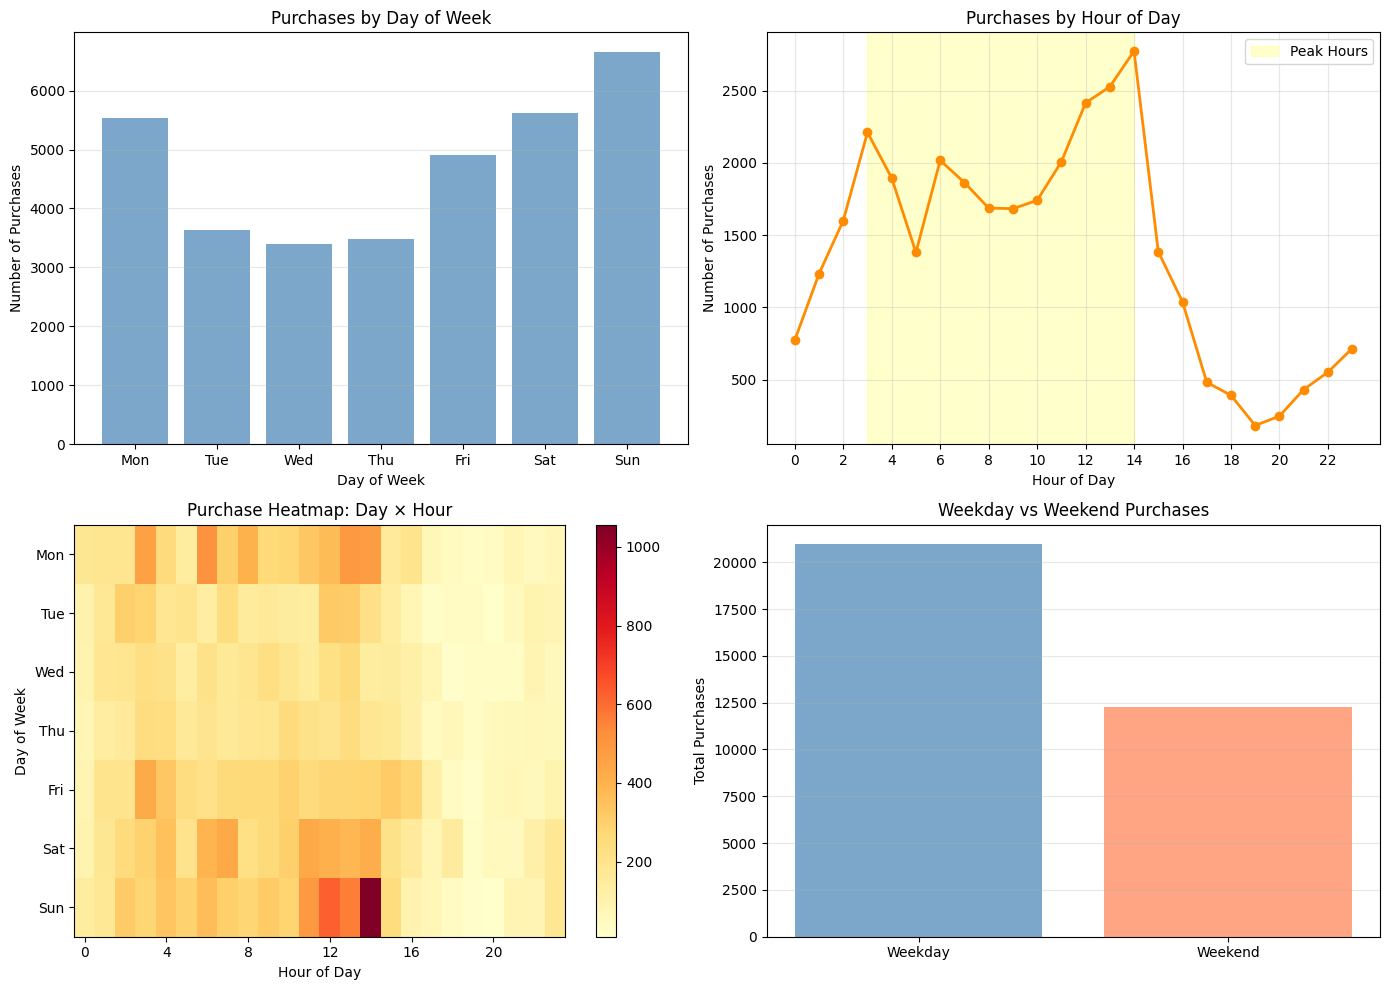


✨ レコメンドへの活用方法:
   1. ピークタイム（夜間）に push 通知やメール配信を最適化
   2. 週末に購買が増える場合、金曜夜にキャンペーン通知
   3. 時間帯別に推薦アルゴリズムを変える（朝=時短、夜=じっくり）
   4. 時間特徴量をモデルの入力に追加（時刻エンコーディング）


In [18]:
# ==========================================
# トレンド分析2: 時間帯・曜日パターン
# ==========================================
print("\n" + "=" * 70)
print("[Trend Analysis 2] Temporal Patterns - Day & Hour Analysis")
print("=" * 70)

# 時間特徴量の抽出
df_purchase['hour'] = df_purchase['accessed_at'].dt.hour
df_purchase['dayofweek'] = df_purchase['accessed_at'].dt.dayofweek  # 0=月曜, 6=日曜
df_purchase['is_weekend'] = df_purchase['dayofweek'].isin([5, 6])
df_purchase['day_name'] = df_purchase['accessed_at'].dt.day_name()

# 曜日別の購買パターン
day_stats = df_purchase.groupby('day_name').agg(
    purchase_count=('product_id', 'count'),
    unique_users=('user_id', 'nunique'),
    avg_price=('price', 'mean')
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print(f"\n📅 曜日別の購買パターン:")
print(day_stats)

# 時間帯別の購買パターン
hour_stats = df_purchase.groupby('hour').agg(
    purchase_count=('product_id', 'count'),
    unique_users=('user_id', 'nunique')
).reset_index()

# ピークタイムの特定
peak_hours = hour_stats.nlargest(5, 'purchase_count')['hour'].values
print(f"\n⏰ ピーク購買時間帯 Top 5: {peak_hours}")

# 週末 vs 平日
weekend_stats = df_purchase.groupby('is_weekend').agg(
    purchase_count=('product_id', 'count'),
    unique_users=('user_id', 'nunique'),
    avg_price=('price', 'mean')
)
weekend_stats.index = ['Weekday', 'Weekend']

print(f"\n🗓️ 週末 vs 平日:")
print(weekend_stats)
print(f"\n週末の購買増加率: {(weekend_stats.loc['Weekend', 'purchase_count'] / weekend_stats.loc['Weekday', 'purchase_count'] - 1) * 100:.1f}%")

# 時間帯×曜日のヒートマップ用データ
hour_day_matrix = df_purchase.groupby(['dayofweek', 'hour']).size().unstack(fill_value=0)

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 曜日別購買数
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[0, 0].bar(range(7), day_stats['purchase_count'], alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Day of Week')
axes[0, 0].set_ylabel('Number of Purchases')
axes[0, 0].set_title('Purchases by Day of Week')
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 0].grid(axis='y', alpha=0.3)

# 時間帯別購買数
axes[0, 1].plot(hour_stats['hour'], hour_stats['purchase_count'], 
                marker='o', linewidth=2, color='darkorange')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Number of Purchases')
axes[0, 1].set_title('Purchases by Hour of Day')
axes[0, 1].set_xticks(range(0, 24, 2))
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvspan(peak_hours.min(), peak_hours.max(), alpha=0.2, color='yellow', label='Peak Hours')
axes[0, 1].legend()

# ヒートマップ（曜日×時間帯）
im = axes[1, 0].imshow(hour_day_matrix.values, cmap='YlOrRd', aspect='auto')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Day of Week')
axes[1, 0].set_title('Purchase Heatmap: Day × Hour')
axes[1, 0].set_yticks(range(7))
axes[1, 0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].set_xticks(range(0, 24, 4))
plt.colorbar(im, ax=axes[1, 0])

# 週末vs平日の比較
axes[1, 1].bar(['Weekday', 'Weekend'], 
               [weekend_stats.loc['Weekday', 'purchase_count'],
                weekend_stats.loc['Weekend', 'purchase_count']],
               alpha=0.7, color=['steelblue', 'coral'])
axes[1, 1].set_ylabel('Total Purchases')
axes[1, 1].set_title('Weekday vs Weekend Purchases')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✨ レコメンドへの活用方法:")
print("   1. ピークタイム（夜間）に push 通知やメール配信を最適化")
print("   2. 週末に購買が増える場合、金曜夜にキャンペーン通知")
print("   3. 時間帯別に推薦アルゴリズムを変える（朝=時短、夜=じっくり）")
print("   4. 時間特徴量をモデルの入力に追加（時刻エンコーディング）")


[Feature Engineering 1] Engagement Features

🎯 高エンゲージメント商品 Top 10:
（閲覧から購入への転換率が高い商品）
       view_count  purchase_count  view_to_purchase_rate  engagement_score
30324          29             106               3.533333         12.017564
78057          14              48               3.200000          8.665761
56091          15              49               3.062500          8.491053
29583          89             266               2.955556         13.299437
84590          19              57               2.850000          8.537837
32554          12              33               2.538462          6.511025
33394          18              47               2.473684          7.283612
21533          15              32               2.000000          5.545177
95312          10              20               1.818182          4.359810
54306          11              17               1.416667          3.520284

🌟 高エンゲージメントクリエイター Top 10:
       view_count  purchase_count  unique_products  view_to_p

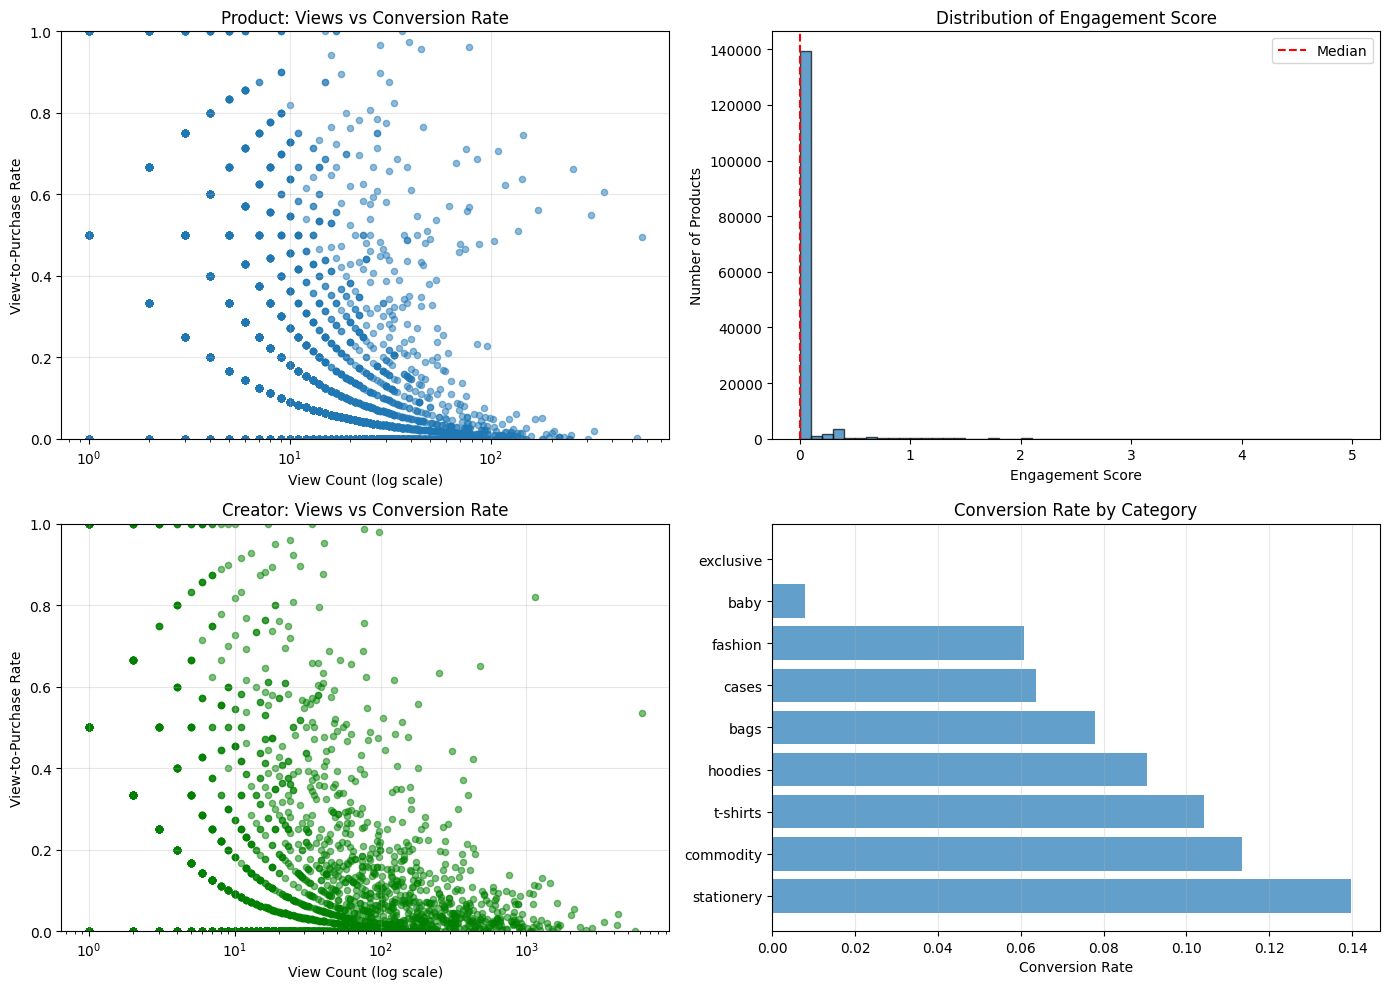


✨ レコメンドへの活用方法:
   1. 高エンゲージメント商品を優先的に推薦（確実に売れる）
   2. エンゲージメントスコアをランキングの重み付けに使用
   3. カテゴリ別の転換率を考慮したブースト係数
   4. 低エンゲージメント商品は表示を控える（在庫削減）


In [19]:
# ==========================================
# 独自特徴量1: エンゲージメント特徴量
# ==========================================
print("\n" + "=" * 70)
print("[Feature Engineering 1] Engagement Features")
print("=" * 70)

# 商品レベルのエンゲージメント
product_engagement = df.groupby('product_id').agg(
    total_events=('event_action', 'count'),
    view_count=('event_action', lambda x: (x == 'view').sum()),
    purchase_count=('event_action', lambda x: (x == 'purchase').sum()),
    unique_viewers=('user_id', lambda x: x[df.loc[x.index, 'event_action'] == 'view'].nunique()),
    unique_buyers=('user_id', lambda x: x[df.loc[x.index, 'event_action'] == 'purchase'].nunique())
).reset_index()

# エンゲージメント率の計算
product_engagement['view_to_purchase_rate'] = (
    product_engagement['purchase_count'] / (product_engagement['view_count'] + 1)
)
product_engagement['buyer_conversion_rate'] = (
    product_engagement['unique_buyers'] / (product_engagement['unique_viewers'] + 1)
)
product_engagement['engagement_score'] = (
    product_engagement['view_to_purchase_rate'] * 
    np.log1p(product_engagement['view_count'])  # 絶対数も考慮
)

# 高エンゲージメント商品
high_engagement = product_engagement[
    (product_engagement['view_count'] >= 10) &  # 最低閲覧数フィルタ
    (product_engagement['view_to_purchase_rate'] > 0)
].sort_values('view_to_purchase_rate', ascending=False).head(20)

print(f"\n🎯 高エンゲージメント商品 Top 10:")
print(f"（閲覧から購入への転換率が高い商品）")
print(high_engagement.head(10)[['view_count', 'purchase_count', 'view_to_purchase_rate', 'engagement_score']])

# クリエイターレベルのエンゲージメント
creator_engagement = df.groupby('creator_id').agg(
    total_events=('event_action', 'count'),
    view_count=('event_action', lambda x: (x == 'view').sum()),
    purchase_count=('event_action', lambda x: (x == 'purchase').sum()),
    unique_products=('product_id', 'nunique')
).reset_index()

creator_engagement['view_to_purchase_rate'] = (
    creator_engagement['purchase_count'] / (creator_engagement['view_count'] + 1)
)
creator_engagement['engagement_per_product'] = (
    creator_engagement['purchase_count'] / creator_engagement['unique_products']
)

high_engagement_creators = creator_engagement[
    creator_engagement['view_count'] >= 50
].sort_values('view_to_purchase_rate', ascending=False).head(20)

print(f"\n🌟 高エンゲージメントクリエイター Top 10:")
print(high_engagement_creators.head(10)[['view_count', 'purchase_count', 'unique_products', 'view_to_purchase_rate']])

# カテゴリレベルのエンゲージメント
category_engagement = df.groupby('item_category_name').agg(
    view_count=('event_action', lambda x: (x == 'view').sum()),
    purchase_count=('event_action', lambda x: (x == 'purchase').sum())
).reset_index()

category_engagement['conversion_rate'] = (
    category_engagement['purchase_count'] / category_engagement['view_count']
)
category_engagement = category_engagement.sort_values('conversion_rate', ascending=False)

print(f"\n📊 カテゴリ別エンゲージメント:")
print(category_engagement)

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 商品の閲覧数 vs 転換率
axes[0, 0].scatter(product_engagement['view_count'], 
                   product_engagement['view_to_purchase_rate'],
                   alpha=0.5, s=20)
axes[0, 0].set_xlabel('View Count (log scale)')
axes[0, 0].set_ylabel('View-to-Purchase Rate')
axes[0, 0].set_title('Product: Views vs Conversion Rate')
axes[0, 0].set_xscale('log')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(True, alpha=0.3)

# エンゲージメントスコア分布
axes[0, 1].hist(product_engagement['engagement_score'], bins=50,
                edgecolor='black', alpha=0.7, range=(0, 5))
axes[0, 1].set_xlabel('Engagement Score')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_title('Distribution of Engagement Score')
axes[0, 1].axvline(x=product_engagement['engagement_score'].median(), 
                   color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# クリエイターのエンゲージメント
axes[1, 0].scatter(creator_engagement['view_count'],
                   creator_engagement['view_to_purchase_rate'],
                   alpha=0.5, s=20, color='green')
axes[1, 0].set_xlabel('View Count (log scale)')
axes[1, 0].set_ylabel('View-to-Purchase Rate')
axes[1, 0].set_title('Creator: Views vs Conversion Rate')
axes[1, 0].set_xscale('log')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3)

# カテゴリ別転換率
axes[1, 1].barh(range(len(category_engagement)), category_engagement['conversion_rate'], alpha=0.7)
axes[1, 1].set_yticks(range(len(category_engagement)))
axes[1, 1].set_yticklabels(category_engagement['item_category_name'])
axes[1, 1].set_xlabel('Conversion Rate')
axes[1, 1].set_title('Conversion Rate by Category')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✨ レコメンドへの活用方法:")
print("   1. 高エンゲージメント商品を優先的に推薦（確実に売れる）")
print("   2. エンゲージメントスコアをランキングの重み付けに使用")
print("   3. カテゴリ別の転換率を考慮したブースト係数")
print("   4. 低エンゲージメント商品は表示を控える（在庫削減）")


[Feature Engineering 2] Freshness Score - Balancing Newness & Popularity

🆕 新しくて人気の商品 Top 10:
       age_days  purchase_count  freshness_raw  freshness_score
16918        10               7       0.750000         0.597708
16917        10               6       0.750000         0.588223
16209        11               5       0.731707         0.566298
16330        13               6       0.697674         0.556828
16840        15               7       0.666667         0.547708
16837        16               8       0.652174         0.547379
14199        16               8       0.652174         0.547379
16543        23              10       0.566038         0.509952
16540        23              10       0.566038         0.509952
1916         23              10       0.566038         0.509952

📅 商品年齢別のパフォーマンス:
  age_category  product_count  avg_purchases  total_purchases
0       ~7days             76       1.236842               94
1     8-30days            883       1.457531             12

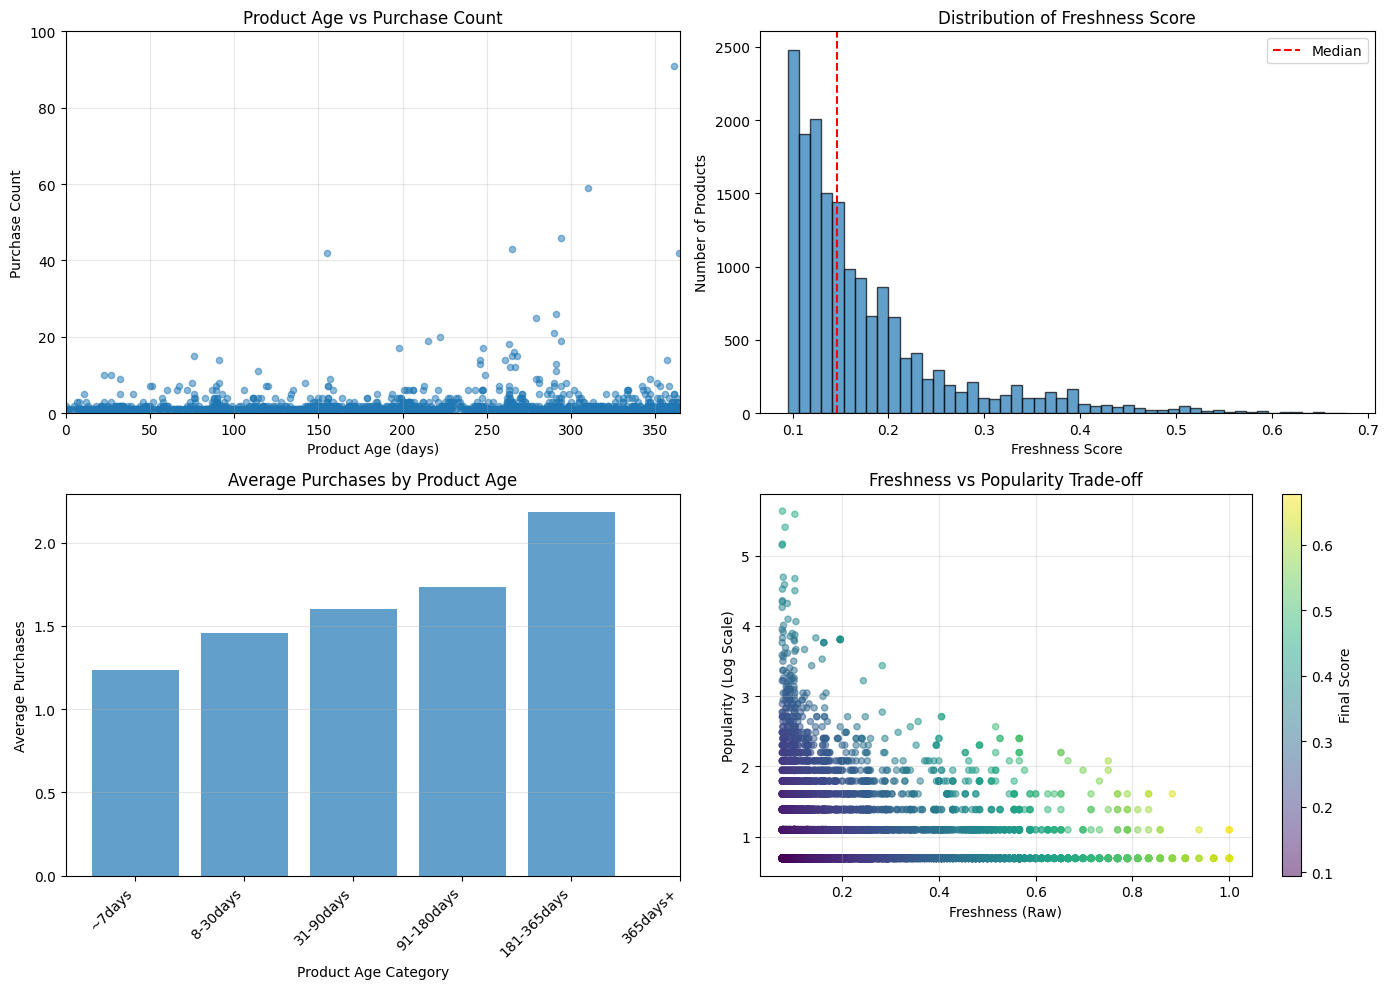


✨ レコメンドへの活用方法:
   1. 鮮度スコアで新商品を優先表示（新規性重視）
   2. 「新着おすすめ」セクションで高鮮度×高人気を表示
   3. 古い商品は徐々に表示頻度を下げる（在庫整理）
   4. 時間減衰を考慮したランキングアルゴリズム
   5. 新商品ブーストで生存率を向上させる


In [20]:
# ==========================================
# 独自特徴量2: 鮮度スコア（Freshness Score）
# ==========================================
print("\n" + "=" * 70)
print("[Feature Engineering 2] Freshness Score - Balancing Newness & Popularity")
print("=" * 70)

# 商品の初登場日を特定
product_first_seen = df.groupby('product_id')['accessed_at'].min().reset_index()
product_first_seen.columns = ['product_id', 'first_seen_date']

# 商品の購入統計とマージ
product_stats = df_purchase.groupby('product_id').agg(
    purchase_count=('product_id', 'count'),
    total_revenue=('price', 'sum'),
    unique_buyers=('user_id', 'nunique')
).reset_index()

freshness_df = product_stats.merge(product_first_seen, on='product_id')

# 商品の「年齢」を計算（日数）
freshness_df['age_days'] = (max_date - freshness_df['first_seen_date']).dt.days

# 鮮度スコアの計算
# 新しい商品ほど高スコア、でも人気も考慮
freshness_df['freshness_raw'] = 1 / (1 + freshness_df['age_days'] / 30)  # 月単位で減衰
freshness_df['popularity_score'] = np.log1p(freshness_df['purchase_count'])
freshness_df['freshness_score'] = (
    freshness_df['freshness_raw'] * 0.6 + 
    freshness_df['popularity_score'] / freshness_df['popularity_score'].max() * 0.4
)

# 新商品かつ人気の商品
fresh_and_popular = freshness_df[
    (freshness_df['age_days'] <= 60) &  # 2ヶ月以内
    (freshness_df['purchase_count'] >= 5)  # 一定の人気
].sort_values('freshness_score', ascending=False).head(20)

print(f"\n🆕 新しくて人気の商品 Top 10:")
print(fresh_and_popular.head(10)[['age_days', 'purchase_count', 'freshness_raw', 'freshness_score']])

# 年齢層別の購買パフォーマンス
freshness_df['age_category'] = pd.cut(
    freshness_df['age_days'],
    bins=[0, 7, 30, 90, 180, 365, 10000],
    labels=['~7days', '8-30days', '31-90days', '91-180days', '181-365days', '365days+']
)

age_performance = freshness_df.groupby('age_category', observed=False).agg(
    product_count=('product_id', 'count'),
    avg_purchases=('purchase_count', 'mean'),
    total_purchases=('purchase_count', 'sum')
).reset_index()

print(f"\n📅 商品年齢別のパフォーマンス:")
print(age_performance)

# 新商品の生存率（購入を獲得した割合）
new_products = freshness_df[freshness_df['age_days'] <= 30]
survival_rate = (new_products['purchase_count'] > 0).mean()
print(f"\n📈 新商品(30日以内)の生存率: {survival_rate:.1%}")
print(f"   （少なくとも1回購入された商品の割合）")

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 年齢 vs 購入数
sample_df = freshness_df.sample(min(2000, len(freshness_df)))
axes[0, 0].scatter(sample_df['age_days'], sample_df['purchase_count'],
                   alpha=0.5, s=20)
axes[0, 0].set_xlabel('Product Age (days)')
axes[0, 0].set_ylabel('Purchase Count')
axes[0, 0].set_title('Product Age vs Purchase Count')
axes[0, 0].set_xlim(0, 365)
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(True, alpha=0.3)

# 鮮度スコア分布
axes[0, 1].hist(freshness_df['freshness_score'], bins=50,
                edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Freshness Score')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].set_title('Distribution of Freshness Score')
axes[0, 1].axvline(x=freshness_df['freshness_score'].median(),
                   color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# 年齢カテゴリ別の平均購入数
axes[1, 0].bar(range(len(age_performance)), age_performance['avg_purchases'], alpha=0.7)
axes[1, 0].set_xlabel('Product Age Category')
axes[1, 0].set_ylabel('Average Purchases')
axes[1, 0].set_title('Average Purchases by Product Age')
axes[1, 0].set_xticks(range(len(age_performance)))
axes[1, 0].set_xticklabels(age_performance['age_category'], rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# 鮮度 vs 人気のバランス
axes[1, 1].scatter(freshness_df['freshness_raw'], freshness_df['popularity_score'],
                   alpha=0.5, s=20, c=freshness_df['freshness_score'], 
                   cmap='viridis')
axes[1, 1].set_xlabel('Freshness (Raw)')
axes[1, 1].set_ylabel('Popularity (Log Scale)')
axes[1, 1].set_title('Freshness vs Popularity Trade-off')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1], label='Final Score')

plt.tight_layout()
plt.show()

print("\n✨ レコメンドへの活用方法:")
print("   1. 鮮度スコアで新商品を優先表示（新規性重視）")
print("   2. 「新着おすすめ」セクションで高鮮度×高人気を表示")
print("   3. 古い商品は徐々に表示頻度を下げる（在庫整理）")
print("   4. 時間減衰を考慮したランキングアルゴリズム")
print("   5. 新商品ブーストで生存率を向上させる")


[Feature Engineering 3] Creator Growth Prediction

⭐ 注目の新進クリエイター Top 10:
     total_purchases  activity_rate  growth_rate  growth_score
18                47       0.312500    94.000000     37.809886
84                46       0.200000    76.666667     30.842171
581               23       0.294118    46.000000     18.583577
611               27       0.375000    45.000000     18.212466
231               17       0.161290    34.000000     13.735098
677               12       0.192308    24.000000      9.734641
516               14       0.206897    23.333333      9.476644
46                13       0.200000    21.666667      8.805838
667               10       0.300000    16.666667      6.828604
206                8       0.277778    16.000000      6.549250

🏆 安定人気クリエイター Top 10:
     total_purchases  activity_rate  stability  growth_rate
235               66       0.164134   0.601137     0.055568

📊 クリエイタートレンド分布:
trend_category
Stable       291
Declining    260
Rising       137
Name: co

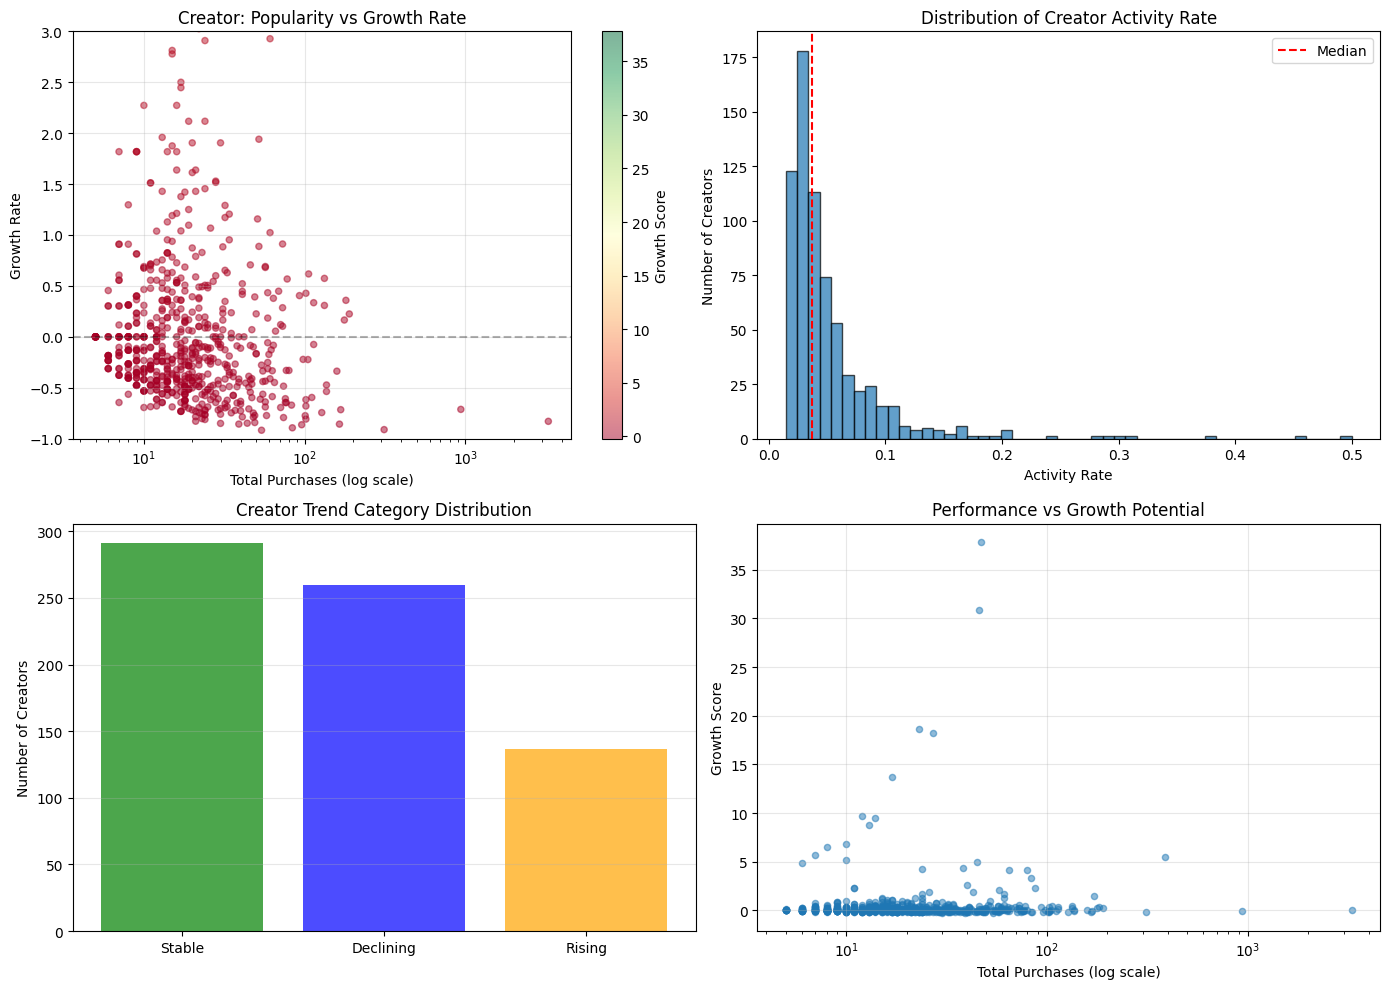


✨ レコメンドへの活用方法:
   1. 新進クリエイターを「注目クリエイター」枠で優先表示
   2. 成長中クリエイターに早期投資（将来人気になる前に露出）
   3. 衰退傾向のクリエイターは表示頻度を下げる
   4. クリエイターライフサイクルに応じた推薦戦略
   5. アクティブ率が高いクリエイターは継続的に推薦


In [21]:
# ==========================================
# 独自特徴量3: クリエイター成長予測
# ==========================================
print("\n" + "=" * 70)
print("[Feature Engineering 3] Creator Growth Prediction")
print("=" * 70)

# クリエイターの時系列データ
creator_timeline = df_purchase.groupby(['creator_id', 'date']).agg(
    daily_purchases=('product_id', 'count'),
    daily_revenue=('price', 'sum')
).reset_index()

# クリエイターごとの統計
creator_growth = []

for creator_id in df_purchase['creator_id'].unique():
    creator_data = creator_timeline[creator_timeline['creator_id'] == creator_id].sort_values('date')
    
    if len(creator_data) < 5:  # データが少なすぎる場合はスキップ
        continue
    
    # 基本統計
    total_purchases = creator_data['daily_purchases'].sum()
    total_days = (creator_data['date'].max() - creator_data['date'].min()).days + 1
    
    # トレンド計算（最近30日 vs 過去）
    recent_30d = creator_data[creator_data['date'] >= (creator_data['date'].max() - timedelta(days=30))]
    prev_period = creator_data[creator_data['date'] < (creator_data['date'].max() - timedelta(days=30))]
    
    recent_avg = recent_30d['daily_purchases'].sum() / max(len(recent_30d), 1)
    prev_avg = prev_period['daily_purchases'].sum() / max(len(prev_period), 1) if len(prev_period) > 0 else 0
    
    # 成長率
    growth_rate = (recent_avg - prev_avg) / (prev_avg + 0.1)
    
    # アクティブ日数率
    active_days = len(creator_data)
    activity_rate = active_days / total_days if total_days > 0 else 0
    
    # 安定性（標準偏差の逆数）
    stability = 1 / (creator_data['daily_purchases'].std() + 1)
    
    creator_growth.append({
        'creator_id': creator_id,
        'total_purchases': total_purchases,
        'active_days': active_days,
        'total_days': total_days,
        'activity_rate': activity_rate,
        'recent_avg': recent_avg,
        'prev_avg': prev_avg,
        'growth_rate': growth_rate,
        'stability': stability
    })

creator_growth_df = pd.DataFrame(creator_growth)

# 成長スコアの計算
creator_growth_df['growth_score'] = (
    creator_growth_df['growth_rate'] * 0.4 +  # 成長率
    creator_growth_df['activity_rate'] * 0.3 +  # アクティブ率
    np.log1p(creator_growth_df['total_purchases']) / 10 * 0.3  # 実績
)

# 有望な新進クリエイター
rising_stars = creator_growth_df[
    (creator_growth_df['total_purchases'] >= 5) &  # 最低実績
    (creator_growth_df['total_purchases'] <= 50) &  # まだ大物ではない
    (creator_growth_df['growth_rate'] > 0.5)  # 成長中
].sort_values('growth_score', ascending=False).head(20)

print(f"\n⭐ 注目の新進クリエイター Top 10:")
print(rising_stars.head(10)[['total_purchases', 'activity_rate', 'growth_rate', 'growth_score']])

# 安定的な人気クリエイター
established = creator_growth_df[
    (creator_growth_df['total_purchases'] >= 50) &
    (creator_growth_df['stability'] > 0.5)
].sort_values('total_purchases', ascending=False).head(20)

print(f"\n🏆 安定人気クリエイター Top 10:")
print(established.head(10)[['total_purchases', 'activity_rate', 'stability', 'growth_rate']])

# 成長トレンドの分類
creator_growth_df['trend_category'] = 'Stable'
creator_growth_df.loc[creator_growth_df['growth_rate'] > 0.5, 'trend_category'] = 'Rising'
creator_growth_df.loc[creator_growth_df['growth_rate'] < -0.3, 'trend_category'] = 'Declining'

trend_distribution = creator_growth_df['trend_category'].value_counts()
print(f"\n📊 クリエイタートレンド分布:")
print(trend_distribution)
print(f"\n成長中クリエイターの割合: {trend_distribution.get('Rising', 0) / len(creator_growth_df):.1%}")

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 成長率 vs 総購入数
axes[0, 0].scatter(creator_growth_df['total_purchases'], 
                   creator_growth_df['growth_rate'],
                   alpha=0.5, s=20,
                   c=creator_growth_df['growth_score'],
                   cmap='RdYlGn')
axes[0, 0].set_xlabel('Total Purchases (log scale)')
axes[0, 0].set_ylabel('Growth Rate')
axes[0, 0].set_title('Creator: Popularity vs Growth Rate')
axes[0, 0].set_xscale('log')
axes[0, 0].set_ylim(-1, 3)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0], label='Growth Score')

# アクティブ率の分布
axes[0, 1].hist(creator_growth_df['activity_rate'], bins=50,
                edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Activity Rate')
axes[0, 1].set_ylabel('Number of Creators')
axes[0, 1].set_title('Distribution of Creator Activity Rate')
axes[0, 1].axvline(x=creator_growth_df['activity_rate'].median(),
                   color='red', linestyle='--', label='Median')
axes[0, 1].legend()

# トレンドカテゴリの分布
axes[1, 0].bar(trend_distribution.index, trend_distribution.values,
               alpha=0.7, color=['green', 'blue', 'orange'])
axes[1, 0].set_ylabel('Number of Creators')
axes[1, 0].set_title('Creator Trend Category Distribution')
axes[1, 0].grid(axis='y', alpha=0.3)

# 成長スコア vs 実績
axes[1, 1].scatter(creator_growth_df['total_purchases'],
                   creator_growth_df['growth_score'],
                   alpha=0.5, s=20)
axes[1, 1].set_xlabel('Total Purchases (log scale)')
axes[1, 1].set_ylabel('Growth Score')
axes[1, 1].set_title('Performance vs Growth Potential')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✨ レコメンドへの活用方法:")
print("   1. 新進クリエイターを「注目クリエイター」枠で優先表示")
print("   2. 成長中クリエイターに早期投資（将来人気になる前に露出）")
print("   3. 衰退傾向のクリエイターは表示頻度を下げる")
print("   4. クリエイターライフサイクルに応じた推薦戦略")
print("   5. アクティブ率が高いクリエイターは継続的に推薦")


[Integration] Comprehensive Scoring System for Recommendations

🎯 総合スコアTop 20商品:
       product_id  purchase_count  popularity_score_norm  virality_score_norm  \
1904     35142607             266               0.991097                  0.0   
1963     35931324             106               0.805919                  0.0   
2785     46910394              42               0.621307                  0.0   
2383     40852553              42               0.621307                  0.0   
2577     43113465             278               1.000000                  0.0   
447      10424636             221               0.953720                  0.0   
6859     68193911              22               0.494596                  1.0   
14832    78171702              24               0.511481                  0.0   
1680     29179958             171               0.902043                  0.0   
438      10364050              42               0.621307                  0.0   

       engagement_score_no

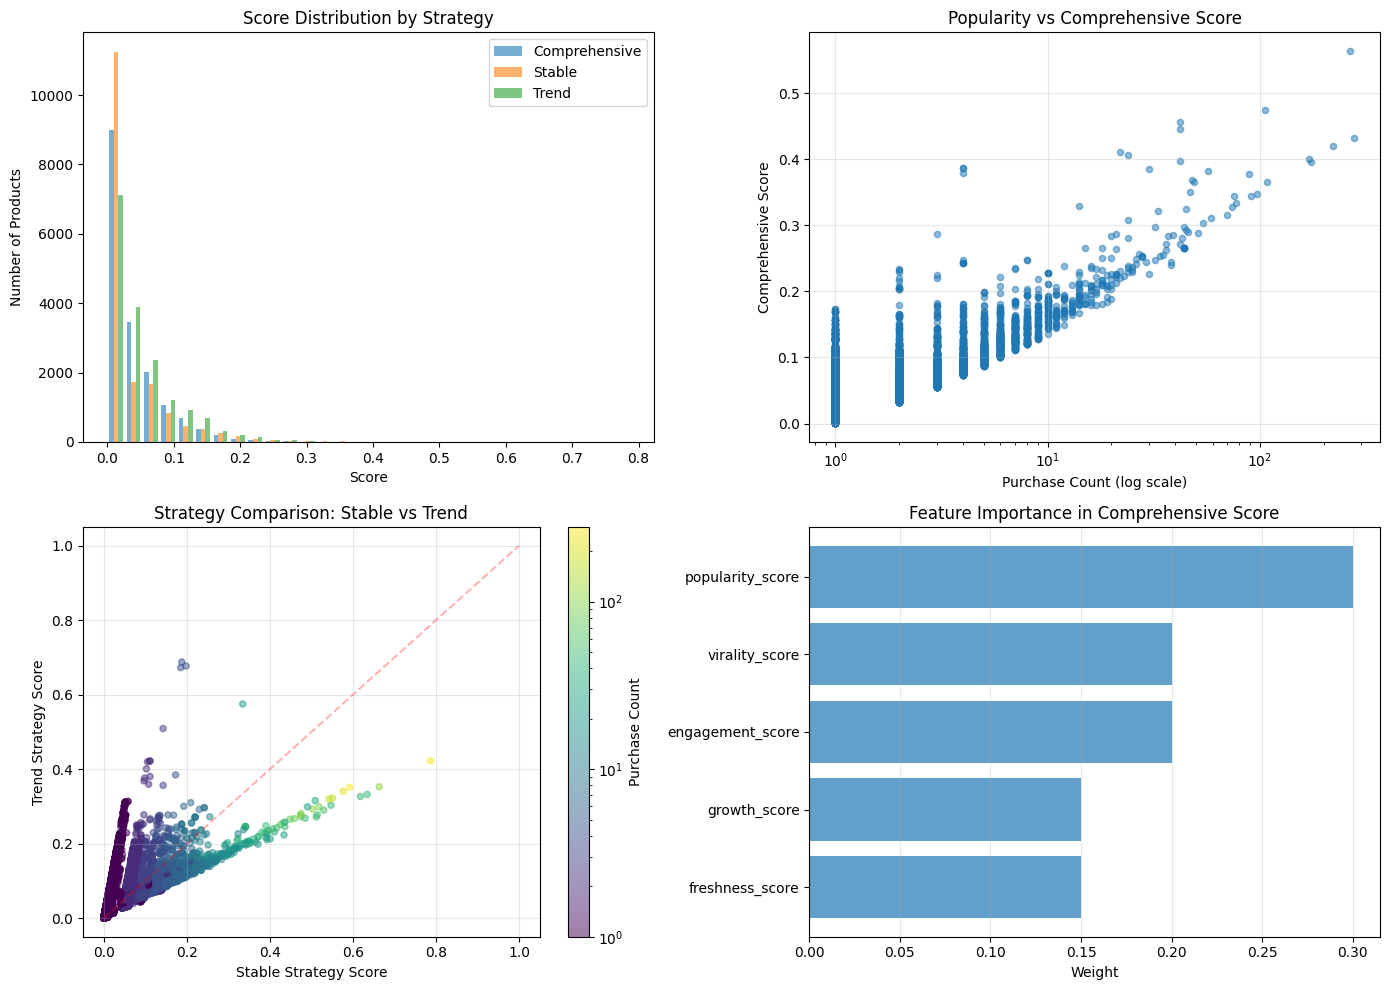


💡 実装時の推奨事項

1. **ハイブリッド推薦システム**
   - 60%: 総合スコアベース（バランス型）
   - 20%: トレンドスコアベース（新規性重視）
   - 10%: 発掘スコアベース（多様性確保）
   - 10%: パーソナライズド（ユーザー履歴ベース）

2. **時間帯別の重み調整**
   - 朝: 安定重視（時間がない→確実に良いもの）
   - 夜: トレンド重視（時間がある→新しいものを探索）

3. **ユーザーセグメント別の戦略**
   - 新規ユーザー: 安定戦略（失敗しない）
   - リピーター: 総合戦略（バランス）
   - ヘビーユーザー: 発掘戦略（飽きさせない）

4. **A/Bテストでの最適化**
   - 各戦略の重みをリアルタイムで調整
   - CTR、CVR、売上で評価

5. **特徴量の定期更新**
   - バイラリティ: 毎日更新
   - エンゲージメント: 週次更新
   - 鮮度: 自動計算（リアルタイム）
   - クリエイター成長: 週次更新



In [22]:
# ==========================================
# 統合: 総合スコアリングシステム
# ==========================================
print("\n" + "=" * 70)
print("[Integration] Comprehensive Scoring System for Recommendations")
print("=" * 70)

# 各特徴量を統合して商品レベルの総合スコアを作成

# 1. 基本人気スコア
product_base_score = df_purchase.groupby('product_id').agg(
    purchase_count=('product_id', 'count'),
    unique_buyers=('user_id', 'nunique'),
    total_revenue=('price', 'sum')
).reset_index()
product_base_score['popularity_score'] = np.log1p(product_base_score['purchase_count'])

# 2. バイラリティスコアを追加
product_base_score = product_base_score.merge(
    virality_products[['virality_score']], 
    left_on='product_id', 
    right_index=True, 
    how='left'
).fillna(0)

# 3. エンゲージメントスコアを追加
product_base_score = product_base_score.merge(
    product_engagement[['product_id', 'view_to_purchase_rate', 'engagement_score']], 
    on='product_id', 
    how='left'
).fillna(0)

# 4. 鮮度スコアを追加
product_base_score = product_base_score.merge(
    freshness_df[['product_id', 'age_days', 'freshness_score']], 
    on='product_id', 
    how='left'
).fillna(0)

# 5. クリエイター成長スコアを追加
product_with_creator = df_purchase[['product_id', 'creator_id']].drop_duplicates()
product_base_score = product_base_score.merge(product_with_creator, on='product_id', how='left')
product_base_score = product_base_score.merge(
    creator_growth_df[['creator_id', 'growth_score']], 
    on='creator_id', 
    how='left'
).fillna(0)

# 総合スコアの計算（重み付け）
# 各スコアを正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

score_columns = ['popularity_score', 'virality_score', 'engagement_score', 
                 'freshness_score', 'growth_score']

# 正規化
for col in score_columns:
    if product_base_score[col].std() > 0:  # 分散がある場合のみ
        product_base_score[f'{col}_norm'] = scaler.fit_transform(
            product_base_score[[col]]
        )
    else:
        product_base_score[f'{col}_norm'] = 0

# 総合スコア = 重み付け和
# 重みは戦略に応じて調整可能
weights = {
    'popularity_score_norm': 0.30,  # 人気度
    'virality_score_norm': 0.20,    # バイラリティ
    'engagement_score_norm': 0.20,  # エンゲージメント
    'freshness_score_norm': 0.15,   # 鮮度
    'growth_score_norm': 0.15        # クリエイター成長
}

product_base_score['comprehensive_score'] = sum(
    product_base_score[col] * weight 
    for col, weight in weights.items()
)

# 戦略別のトップ商品
print("\n🎯 総合スコアTop 20商品:")
top_comprehensive = product_base_score.nlargest(20, 'comprehensive_score')
print(top_comprehensive[['product_id', 'purchase_count', 'popularity_score_norm', 
                          'virality_score_norm', 'engagement_score_norm', 
                          'freshness_score_norm', 'comprehensive_score']].head(10))

# 異なる戦略のシミュレーション
print("\n" + "=" * 70)
print("📊 推薦戦略別のTop 10商品")
print("=" * 70)

# 戦略1: 安定重視（人気 + エンゲージメント）
stable_weights = {
    'popularity_score_norm': 0.50,
    'virality_score_norm': 0.05,
    'engagement_score_norm': 0.30,
    'freshness_score_norm': 0.05,
    'growth_score_norm': 0.10
}
product_base_score['stable_score'] = sum(
    product_base_score[col] * weight 
    for col, weight in stable_weights.items()
)

print("\n【戦略1: 安定重視】")
print("  → 確実に売れる定番商品を推薦")
print(product_base_score.nlargest(10, 'stable_score')[
    ['product_id', 'purchase_count', 'comprehensive_score', 'stable_score']
].to_string(index=False))

# 戦略2: トレンド重視（バイラリティ + 鮮度）
trend_weights = {
    'popularity_score_norm': 0.15,
    'virality_score_norm': 0.40,
    'engagement_score_norm': 0.10,
    'freshness_score_norm': 0.30,
    'growth_score_norm': 0.05
}
product_base_score['trend_score'] = sum(
    product_base_score[col] * weight 
    for col, weight in trend_weights.items()
)

print("\n【戦略2: トレンド重視】")
print("  → 話題の新商品や急上昇商品を推薦")
print(product_base_score.nlargest(10, 'trend_score')[
    ['product_id', 'purchase_count', 'comprehensive_score', 'trend_score']
].to_string(index=False))

# 戦略3: 発掘重視（成長 + 鮮度、でも最低限の人気）
discovery_weights = {
    'popularity_score_norm': 0.10,
    'virality_score_norm': 0.20,
    'engagement_score_norm': 0.20,
    'freshness_score_norm': 0.25,
    'growth_score_norm': 0.25
}
product_base_score['discovery_score'] = sum(
    product_base_score[col] * weight 
    for col, weight in discovery_weights.items()
)

# 発掘枠は購入数が中程度のものに絞る
discovery_candidates = product_base_score[
    (product_base_score['purchase_count'] >= 3) &
    (product_base_score['purchase_count'] <= 30)
]

print("\n【戦略3: 発掘重視】")
print("  → 隠れた名作、新進クリエイターの作品を推薦")
print(discovery_candidates.nlargest(10, 'discovery_score')[
    ['product_id', 'purchase_count', 'comprehensive_score', 'discovery_score']
].to_string(index=False))

# 可視化: 各スコアの相関
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 各戦略のスコア分布
axes[0, 0].hist([product_base_score['comprehensive_score'],
                 product_base_score['stable_score'],
                 product_base_score['trend_score']],
                bins=30, alpha=0.6, label=['Comprehensive', 'Stable', 'Trend'])
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].set_title('Score Distribution by Strategy')
axes[0, 0].legend()

# 人気度 vs 総合スコア
axes[0, 1].scatter(product_base_score['purchase_count'],
                   product_base_score['comprehensive_score'],
                   alpha=0.5, s=20)
axes[0, 1].set_xlabel('Purchase Count (log scale)')
axes[0, 1].set_ylabel('Comprehensive Score')
axes[0, 1].set_title('Popularity vs Comprehensive Score')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 戦略比較: 安定 vs トレンド
axes[1, 0].scatter(product_base_score['stable_score'],
                   product_base_score['trend_score'],
                   alpha=0.5, s=20, c=product_base_score['purchase_count'],
                   cmap='viridis', norm=plt.matplotlib.colors.LogNorm())
axes[1, 0].set_xlabel('Stable Strategy Score')
axes[1, 0].set_ylabel('Trend Strategy Score')
axes[1, 0].set_title('Strategy Comparison: Stable vs Trend')
axes[1, 0].plot([0, 1], [0, 1], 'r--', alpha=0.3)
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Purchase Count')

# 特徴量の重要度（平均的な寄与度）
feature_importance = pd.Series(weights).sort_values(ascending=True)
axes[1, 1].barh(range(len(feature_importance)), feature_importance.values, alpha=0.7)
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels([name.replace('_norm', '') for name in feature_importance.index])
axes[1, 1].set_xlabel('Weight')
axes[1, 1].set_title('Feature Importance in Comprehensive Score')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("💡 実装時の推奨事項")
print("=" * 70)
print("""
1. **ハイブリッド推薦システム**
   - 60%: 総合スコアベース（バランス型）
   - 20%: トレンドスコアベース（新規性重視）
   - 10%: 発掘スコアベース（多様性確保）
   - 10%: パーソナライズド（ユーザー履歴ベース）

2. **時間帯別の重み調整**
   - 朝: 安定重視（時間がない→確実に良いもの）
   - 夜: トレンド重視（時間がある→新しいものを探索）

3. **ユーザーセグメント別の戦略**
   - 新規ユーザー: 安定戦略（失敗しない）
   - リピーター: 総合戦略（バランス）
   - ヘビーユーザー: 発掘戦略（飽きさせない）

4. **A/Bテストでの最適化**
   - 各戦略の重みをリアルタイムで調整
   - CTR、CVR、売上で評価
   
5. **特徴量の定期更新**
   - バイラリティ: 毎日更新
   - エンゲージメント: 週次更新
   - 鮮度: 自動計算（リアルタイム）
   - クリエイター成長: 週次更新
""")

# 深掘り分析: ユーザー行動とコンテンツ特性

以下の観点から詳細分析を実施します:
1. **購買ファネル分析**: 閲覧 → カート追加 → 購入の流れ
2. **閲覧行動とユーザー特徴**: 閲覧数による顧客セグメンテーション
3. **コンテンツ類似度**: 説明文・マテリアル画像の類似性（軽量化版）
4. **初回購入分析**: ユーザーが最初に買う商品の特性
5. **クリエイター特性プロファイリング**: 成功クリエイターの共通点
6. **Favorite vs 購入ギャップ**: お気に入りと実購買の乖離

【分析1】購買ファネル分析: 閲覧 → カート → 購入

1. イベントタイプ分布
event_action
view                324243
favorite             65115
checkout             51153
purchase             33227
add_to_cart          24845
remove_from_cart      4423
add_to_wishlist       1162
Name: count, dtype: int64

総イベント数: 504,168

2. ユーザー単位のファネル分析
ユーザー数: 2,454

閲覧のみ: 593 (24.2%)
購入あり: 1,861 (75.8%)

3. ファネルステージ別のユーザー分布
   Stage  Users  Rate (%)  Drop Rate (%)
     ①閲覧   1677    100.00           0.00
②お気に入り登録   1403     83.66          16.34
  ③カート追加   1226     73.11          10.55
     ④購入   1861    110.97          37.86

4. 購入者の事前行動パターン

購入者の平均行動:
  - 閲覧回数: 148.6 (中央値: 9)
  - お気に入り: 32.29 (中央値: 1)
  - カート追加: 11.28 (中央値: 1)

5. 購入者の行動パターン分類
       Pattern  Count  Ratio (%)
衝動買い型（閲覧のみ→購入）    381       20.5
      お気に入り経由型    547       29.4
        カート経由型    389       20.9
     慎重型（両方経由）    544       29.2


/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 12518 (\N{KATAKANA LETTER YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 38322 (\N{CJK UNIFIED IDEOGRAPH-95B2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 35239 (\N{CJK UNIFIED IDEOGRAPH-89A7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/496807361.py:138: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing fro

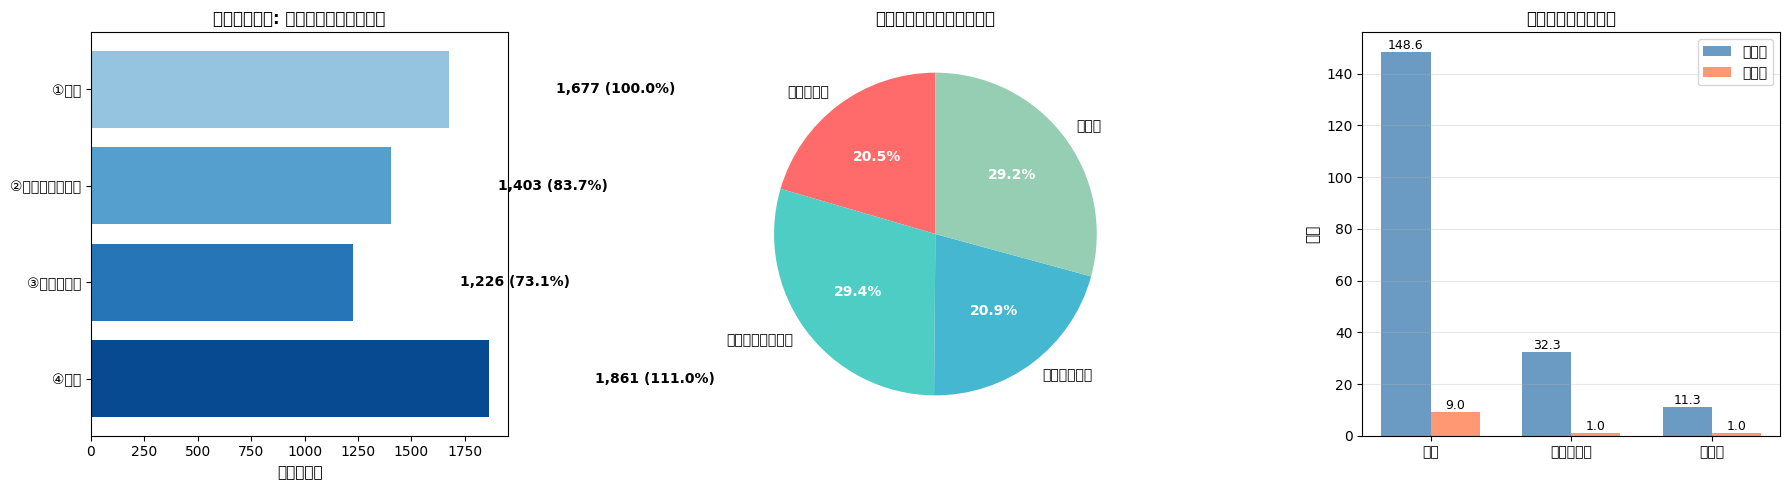


【洞察】
💡 ファネル離脱: ①→④で -11.0% が離脱
📊 購入者の中央値行動: 閲覧9回 → 購入


In [30]:
# ==========================================
# 分析1: 購買ファネル分析
# ==========================================
print("=" * 60)
print("【分析1】購買ファネル分析: 閲覧 → カート → 購入")
print("=" * 60)

# イベントタイプの確認
print("\n1. イベントタイプ分布")
event_type_dist = join_data['event_action'].value_counts()
print(event_type_dist)
print(f"\n総イベント数: {len(join_data):,}")

# ユーザーごとのファネル分析
print("\n2. ユーザー単位のファネル分析")
user_funnel = pd.DataFrame({
    'user_id': join_data['user_id'].unique()
})
user_funnel = user_funnel.set_index('user_id')

# 各イベントのカウント
for event_type in ['view', 'favorite', 'add_to_cart', 'purchase']:
    counts = join_data[join_data['event_action'] == event_type].groupby('user_id').size()
    user_funnel[f'{event_type}_count'] = counts
user_funnel = user_funnel.fillna(0).astype(int)

print(f"ユーザー数: {len(user_funnel):,}")
print(f"\n閲覧のみ: {(user_funnel['purchase_count'] == 0).sum():,} ({(user_funnel['purchase_count'] == 0).sum() / len(user_funnel) * 100:.1f}%)")
print(f"購入あり: {(user_funnel['purchase_count'] > 0).sum():,} ({(user_funnel['purchase_count'] > 0).sum() / len(user_funnel) * 100:.1f}%)")

# ファネルステージの定義
print("\n3. ファネルステージ別のユーザー分布")
funnel_stages = pd.DataFrame({
    'Stage': ['①閲覧', '②お気に入り登録', '③カート追加', '④購入'],
    'Users': [
        (user_funnel['view_count'] > 0).sum(),
        (user_funnel['favorite_count'] > 0).sum(),
        (user_funnel['add_to_cart_count'] > 0).sum(),
        (user_funnel['purchase_count'] > 0).sum()
    ]
})
funnel_stages['Rate (%)'] = (funnel_stages['Users'] / funnel_stages['Users'].iloc[0] * 100).round(2)
funnel_stages['Drop Rate (%)'] = funnel_stages['Rate (%)'].diff().fillna(0).abs().round(2)
print(funnel_stages.to_string(index=False))

# 購入者のファネル行動パターン
print("\n4. 購入者の事前行動パターン")
purchasers_funnel = user_funnel[user_funnel['purchase_count'] > 0].copy()
print(f"\n購入者の平均行動:")
print(f"  - 閲覧回数: {purchasers_funnel['view_count'].mean():.1f} (中央値: {purchasers_funnel['view_count'].median():.0f})")
print(f"  - お気に入り: {purchasers_funnel['favorite_count'].mean():.2f} (中央値: {purchasers_funnel['favorite_count'].median():.0f})")
print(f"  - カート追加: {purchasers_funnel['add_to_cart_count'].mean():.2f} (中央値: {purchasers_funnel['add_to_cart_count'].median():.0f})")

# 購入者の行動パターン分類
print("\n5. 購入者の行動パターン分類")
purchaser_patterns = pd.DataFrame({
    'Pattern': [
        '衝動買い型（閲覧のみ→購入）',
        'お気に入り経由型',
        'カート経由型',
        '慎重型（両方経由）'
    ],
    'Count': [
        ((purchasers_funnel['favorite_count'] == 0) & (purchasers_funnel['add_to_cart_count'] == 0)).sum(),
        ((purchasers_funnel['favorite_count'] > 0) & (purchasers_funnel['add_to_cart_count'] == 0)).sum(),
        ((purchasers_funnel['favorite_count'] == 0) & (purchasers_funnel['add_to_cart_count'] > 0)).sum(),
        ((purchasers_funnel['favorite_count'] > 0) & (purchasers_funnel['add_to_cart_count'] > 0)).sum()
    ]
})
purchaser_patterns['Ratio (%)'] = (purchaser_patterns['Count'] / len(purchasers_funnel) * 100).round(1)
print(purchaser_patterns.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ファネル図
ax1 = axes[0]
stages = funnel_stages['Stage'].values
users = funnel_stages['Users'].values
colors_funnel = plt.cm.Blues(np.linspace(0.4, 0.9, len(stages)))
bars = ax1.barh(stages, users, color=colors_funnel)
ax1.set_xlabel('ユーザー数', fontsize=11)
ax1.set_title('購買ファネル: ステージ別ユーザー数', fontsize=12, fontweight='bold')
for i, (bar, user, rate) in enumerate(zip(bars, users, funnel_stages['Rate (%)'])):
    ax1.text(user + 500, bar.get_y() + bar.get_height()/2, 
             f'{user:,} ({rate:.1f}%)', 
             va='center', fontsize=10, fontweight='bold')
ax1.invert_yaxis()

# 購入者の行動パターン
ax2 = axes[1]
pattern_labels = [p.split('（')[0] for p in purchaser_patterns['Pattern']]
colors_pattern = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
wedges, texts, autotexts = ax2.pie(
    purchaser_patterns['Count'], 
    labels=pattern_labels,
    autopct='%1.1f%%',
    colors=colors_pattern,
    startangle=90
)
ax2.set_title('購入者の事前行動パターン', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 購入者の行動量分布
ax3 = axes[2]
metrics = ['閲覧', 'お気に入り', 'カート']
means = [
    purchasers_funnel['view_count'].mean(),
    purchasers_funnel['favorite_count'].mean(),
    purchasers_funnel['add_to_cart_count'].mean()
]
medians = [
    purchasers_funnel['view_count'].median(),
    purchasers_funnel['favorite_count'].median(),
    purchasers_funnel['add_to_cart_count'].median()
]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, means, width, label='平均値', color='steelblue', alpha=0.8)
bars2 = ax3.bar(x + width/2, medians, width, label='中央値', color='coral', alpha=0.8)
ax3.set_ylabel('回数', fontsize=11)
ax3.set_title('購入者の平均行動量', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 値ラベル
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【洞察】")
print("=" * 60)
if (purchaser_patterns.loc[0, 'Ratio (%)'] > 50):
    print("⚠️ 衝動買い型が過半数 → お気に入りやカート機能の活用が低い")
print(f"💡 ファネル離脱: ①→④で {100 - funnel_stages['Rate (%)'].iloc[-1]:.1f}% が離脱")
print(f"📊 購入者の中央値行動: 閲覧{purchasers_funnel['view_count'].median():.0f}回 → 購入")

【分析2】閲覧行動とユーザー特徴

1. 閲覧数によるユーザーセグメンテーション

2. セグメント別の特徴
                ユーザー数   平均閲覧数   商品多様性  クリエイター多様性  1日あたり閲覧  購入率(%)  平均購入数  \
segment                                                                    
ライト層(1-5回)        310    2.47   24.17       3.85     0.43   66.13   9.13   
ミドル層(6-15回)       228    9.86   36.69      10.31     0.63   62.72   6.95   
ヘビー層(16-50回)      337   30.31   30.06       6.90     0.58   69.73   8.78   
スーパーヘビー層(51回~)    802  387.80  157.94      47.07     2.42   77.56  20.71   

                 平均閲覧価格  
segment                  
ライト層(1-5回)      3034.23  
ミドル層(6-15回)     3082.80  
ヘビー層(16-50回)    3038.31  
スーパーヘビー層(51回~)  3321.55  

3. 閲覧数と購入転換率の関係
          購入率(%)  平均購入数  ユーザー数
view_bin                      
1-2回       66.06   9.21    221
3-5回       65.85   8.02    123
6-9回       60.78   7.10    102
10-19回     67.65   7.96    170
20-49回     69.11   8.78    259
50回以上      77.56  20.71    802


/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 23652 (\N{CJK UNIFIED IDEOGRAPH-5C64}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 12511 (\N{KATAKANA LETTER MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1227897477.py:127: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans

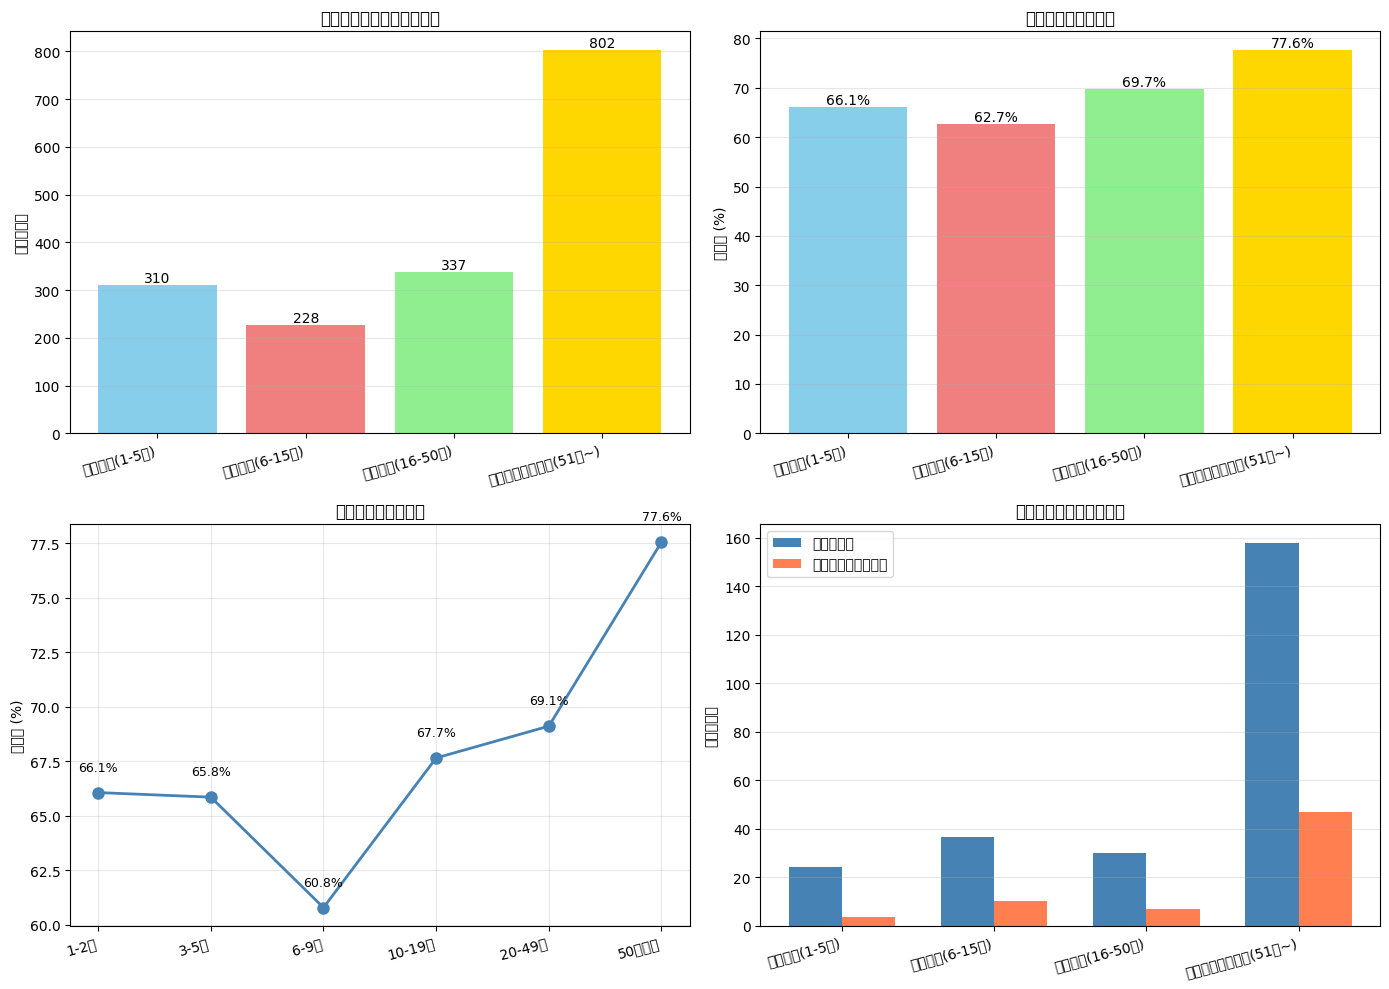


【洞察】
💡 最も購入率が高いセグメント: スーパーヘビー層(51回~)
📊 閲覧数と購入率の相関係数: 0.097
⚠️ ライト層の特徴: 購入率66.1% → 初回体験の質が重要


In [32]:
# ==========================================
# 分析2: 閲覧行動とユーザー特徴の関係
# ==========================================
print("=" * 60)
print("【分析2】閲覧行動とユーザー特徴")
print("=" * 60)

# 閲覧数によるユーザー分類
print("\n1. 閲覧数によるユーザーセグメンテーション")
user_view_behavior = join_data.groupby('user_id').agg({
    'event_action': lambda x: (x == 'view').sum(),  # 閲覧回数
    'product_id': 'nunique',  # ユニーク商品数
    'creator_id': 'nunique',  # ユニーククリエイター数
    'accessed_at': ['min', 'max'],  # 最初と最後のアクセス
    'price': 'mean'  # 平均閲覧価格帯
}).round(2)
user_view_behavior.columns = ['view_count', 'unique_products', 'unique_creators', 
                               'first_access', 'last_access', 'avg_price_viewed']

# アクティブ期間の計算（日時型に変換してから計算）
user_view_behavior['first_access'] = pd.to_datetime(user_view_behavior['first_access'])
user_view_behavior['last_access'] = pd.to_datetime(user_view_behavior['last_access'])
user_view_behavior['active_days'] = (
    user_view_behavior['last_access'] - user_view_behavior['first_access']
).dt.days + 1
user_view_behavior['views_per_day'] = (
    user_view_behavior['view_count'] / user_view_behavior['active_days']
).round(2)

# 購入有無を追加
user_purchases_flag = join_data[join_data['event_action'] == 'purchase'].groupby('user_id').size()
user_view_behavior['has_purchased'] = user_view_behavior.index.isin(user_purchases_flag.index)
user_view_behavior['purchase_count'] = user_purchases_flag.reindex(user_view_behavior.index, fill_value=0)

# 閲覧数によるセグメント分類
user_view_behavior['segment'] = pd.cut(
    user_view_behavior['view_count'],
    bins=[0, 5, 15, 50, np.inf],
    labels=['ライト層(1-5回)', 'ミドル層(6-15回)', 'ヘビー層(16-50回)', 'スーパーヘビー層(51回~)']
)

print("\n2. セグメント別の特徴")
segment_summary = user_view_behavior.groupby('segment', observed=True).agg({
    'view_count': ['count', 'mean'],
    'unique_products': 'mean',
    'unique_creators': 'mean',
    'views_per_day': 'mean',
    'has_purchased': lambda x: (x == True).sum() / len(x) * 100,
    'purchase_count': 'mean',
    'avg_price_viewed': 'mean'
}).round(2)
segment_summary.columns = ['ユーザー数', '平均閲覧数', '商品多様性', 
                           'クリエイター多様性', '1日あたり閲覧', 
                           '購入率(%)', '平均購入数', '平均閲覧価格']
print(segment_summary)

# 閲覧数と購入率の関係
print("\n3. 閲覧数と購入転換率の関係")
view_bins = [0, 3, 6, 10, 20, 50, np.inf]
view_labels = ['1-2回', '3-5回', '6-9回', '10-19回', '20-49回', '50回以上']
user_view_behavior['view_bin'] = pd.cut(
    user_view_behavior['view_count'],
    bins=view_bins,
    labels=view_labels
)

conversion_by_views = user_view_behavior.groupby('view_bin', observed=True).agg({
    'has_purchased': lambda x: (x == True).sum() / len(x) * 100,
    'purchase_count': 'mean',
    'view_count': 'count'
}).round(2)
conversion_by_views.columns = ['購入率(%)', '平均購入数', 'ユーザー数']
print(conversion_by_views)

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. セグメント分布
ax1 = axes[0, 0]
segment_counts = user_view_behavior['segment'].value_counts(sort=False)
ax1.bar(range(len(segment_counts)), segment_counts.values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax1.set_xticks(range(len(segment_counts)))
ax1.set_xticklabels(segment_counts.index, rotation=15, ha='right')
ax1.set_title('セグメント別ユーザー分布', fontweight='bold')
ax1.set_ylabel('ユーザー数')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(segment_counts.values):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom')

# 2. セグメント別購入率
ax2 = axes[0, 1]
purchase_rates = segment_summary['購入率(%)'].values
ax2.bar(range(len(purchase_rates)), purchase_rates, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax2.set_xticks(range(len(segment_summary)))
ax2.set_xticklabels(segment_summary.index, rotation=15, ha='right')
ax2.set_title('セグメント別購入率', fontweight='bold')
ax2.set_ylabel('購入率 (%)')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(purchase_rates):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# 3. 閲覧数と購入率の関係
ax3 = axes[1, 0]
conv_rates = conversion_by_views['購入率(%)'].values
ax3.plot(range(len(conv_rates)), conv_rates, marker='o', linewidth=2, markersize=8, color='steelblue')
ax3.set_xticks(range(len(conversion_by_views)))
ax3.set_xticklabels(conversion_by_views.index, rotation=15, ha='right')
ax3.set_title('閲覧数と購入転換率', fontweight='bold')
ax3.set_ylabel('購入率 (%)')
ax3.grid(True, alpha=0.3)
for i, v in enumerate(conv_rates):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=9)

# 4. セグメント別商品・クリエイター多様性
ax4 = axes[1, 1]
x = np.arange(len(segment_summary))
width = 0.35
bars1 = ax4.bar(x - width/2, segment_summary['商品多様性'].values, width, label='商品多様性', color='steelblue')
bars2 = ax4.bar(x + width/2, segment_summary['クリエイター多様性'].values, width, label='クリエイター多様性', color='coral')
ax4.set_xticks(x)
ax4.set_xticklabels(segment_summary.index, rotation=15, ha='right')
ax4.set_title('セグメント別の探索行動', fontweight='bold')
ax4.set_ylabel('ユニーク数')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【洞察】")
print("=" * 60)
top_segment = segment_summary.index[segment_summary['購入率(%)'].argmax()]
print(f"💡 最も購入率が高いセグメント: {top_segment}")
print(f"📊 閲覧数と購入率の相関係数: {user_view_behavior[['view_count', 'purchase_count']].corr().iloc[0, 1]:.3f}")
print(f"⚠️ ライト層の特徴: 購入率{segment_summary.iloc[0]['購入率(%)']:.1f}% → 初回体験の質が重要")


【分析3】コンテンツ類似度分析（軽量化版）

1. データ構造の確認
カラム: ['user_id', 'event_action', 'accessed_at', 'product_id', 'material1', 'material2', 'material3', 'material4', 'material5', 'material6', 'material7', 'material8', 'material9', 'material10', 'material11']...

イベント数: 504,168
カテゴリ関連カラム: ['item_category_id', 'item_category_name']
マテリアル関連カラム: ['material1', 'material2', 'material3', 'material4', 'material5', 'material6', 'material7', 'material8', 'material9', 'material10', 'material11', 'material12', 'material_url']

2. 商品の共起（同一ユーザーが閲覧）パターン
購入実績のある商品数: 17,001
閲覧ユーザー数: 1,677
商品ペア共起パターン: 1,210組

上位20ペア（頻出共起）:
  商品10011802 × 商品56773630: 39回
  商品43113465 × 商品56773630: 21回
  商品23696739 × 商品56773630: 18回
  商品56773630 × 商品65109874: 17回
  商品10011802 × 商品23696739: 13回

3. クリエイター単位の類似パターン
同一クリエイターから複数商品を購入したパターン: 2124
クリエイター・ロイヤルティ率: 114.13%

4. 商品の魅力度分析（閲覧→購入転換率）
分析対象商品数（10回以上閲覧）: 6,494
平均CVR: 5.85%
CVR中央値: 0.00%

高CVR商品（20%以上）: 522商品


/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 36215 (\N{CJK UNIFIED IDEOGRAPH-8D77}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/3171540537.py:130: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing 

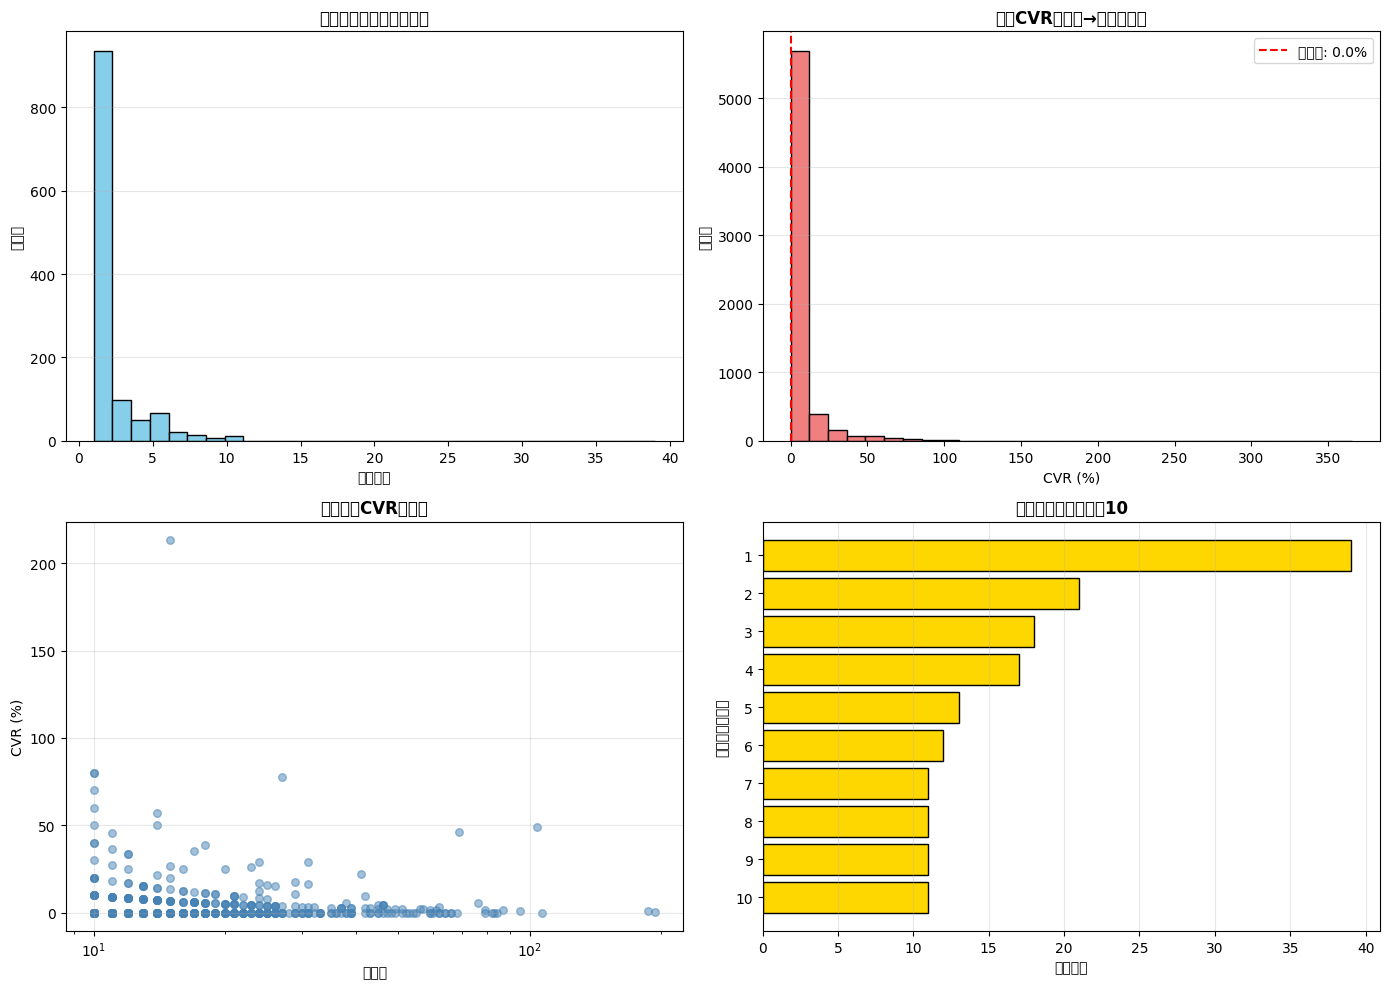


【洞察】
💡 平均CVR 5.85% → 商品の魅力度にばらつきあり
📊 クリエイター・ロイヤルティ 114.1% → 同一クリエイターから複数購入する傾向
⚠️ 商品共起の平均回数: 2.1回 → 閲覧パターンに類似性あり


In [34]:
# ==========================================
# 分析3: コンテンツ類似度分析（軽量化版）
# ==========================================
print("=" * 60)
print("【分析3】コンテンツ類似度分析（軽量化版）")
print("=" * 60)

# まずはデータ構造を確認
print("\n1. データ構造の確認")
print(f"カラム: {join_data.columns.tolist()[:15]}...")  # 最初の15カラムを表示
print(f"\nイベント数: {len(join_data):,}")

# カテゴリ情報が存在するか確認
category_cols = [col for col in join_data.columns if 'category' in col.lower()]
print(f"カテゴリ関連カラム: {category_cols}")

# マテリアル情報の確認
material_cols = [col for col in join_data.columns if 'material' in col.lower()]
print(f"マテリアル関連カラム: {material_cols}")

# 共起分析：ユーザーが一緒に見る商品ペアの分析
print("\n2. 商品の共起（同一ユーザーが閲覧）パターン")

# 購入されている商品でフィルタ
purchased_products = join_data[join_data['event_action'] == 'purchase']['product_id'].unique()
print(f"購入実績のある商品数: {len(purchased_products):,}")

# 各ユーザーが閲覧した商品リスト
user_viewed_products = join_data[join_data['event_action'] == 'view'].groupby('user_id')['product_id'].apply(set)
print(f"閲覧ユーザー数: {len(user_viewed_products):,}")

# 商品ペアの共起回数を計算（計算量削減のため上位商品のみ）
from collections import defaultdict
product_counts = join_data[join_data['event_action'] == 'view']['product_id'].value_counts()
top_products = product_counts.head(200).index  # 上位200商品に限定

co_occurrence = defaultdict(int)
pair_count = 0
for products in user_viewed_products:
    products_in_top = list(products & set(top_products))
    if len(products_in_top) >= 2:
        for i, p1 in enumerate(products_in_top):
            for p2 in products_in_top[i+1:]:
                if p1 != p2:
                    key = tuple(sorted([p1, p2]))
                    co_occurrence[key] += 1
                    pair_count += 1

print(f"商品ペア共起パターン: {len(co_occurrence):,}組")

# 共起頻度の高いペアを抽出
top_pairs = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:20]
print("\n上位20ペア（頻出共起）:")
for (p1, p2), count in top_pairs[:5]:
    print(f"  商品{p1} × 商品{p2}: {count}回")

# クリエイター単位の類似度（簡易版）
print("\n3. クリエイター単位の類似パターン")
# 同じクリエイターの別商品を購入するパターン
user_creator_products = join_data[join_data['event_action'] == 'purchase'].groupby(['user_id', 'creator_id'])['product_id'].nunique()
multi_product_creators = user_creator_products[user_creator_products > 1]

print(f"同一クリエイターから複数商品を購入したパターン: {len(multi_product_creators)}")
creator_loyalty = len(multi_product_creators) / len(join_data[join_data['event_action'] == 'purchase']['user_id'].unique()) * 100
print(f"クリエイター・ロイヤルティ率: {creator_loyalty:.2f}%")

# 購入転換率の分析（商品の魅力度の代理指標）
print("\n4. 商品の魅力度分析（閲覧→購入転換率）")
product_views = join_data[join_data['event_action'] == 'view'].groupby('product_id').size()
product_purchases = join_data[join_data['event_action'] == 'purchase'].groupby('product_id').size()

product_cvr = pd.DataFrame({
    'views': product_views,
    'purchases': product_purchases
}).fillna(0)
product_cvr['cvr'] = (product_cvr['purchases'] / product_cvr['views'] * 100).round(2)
product_cvr = product_cvr[product_cvr['views'] >= 10]  # 10回以上閲覧された商品のみ

print(f"分析対象商品数（10回以上閲覧）: {len(product_cvr):,}")
print(f"平均CVR: {product_cvr['cvr'].mean():.2f}%")
print(f"CVR中央値: {product_cvr['cvr'].median():.2f}%")

high_cvr_products = product_cvr[product_cvr['cvr'] >= 20].sort_values('purchases', ascending=False)
print(f"\n高CVR商品（20%以上）: {len(high_cvr_products)}商品")

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 共起頻度の分布
ax1 = axes[0, 0]
co_occurrence_values = list(co_occurrence.values())
ax1.hist(co_occurrence_values, bins=30, color='skyblue', edgecolor='black')
ax1.set_title('商品ペア共起頻度の分布', fontweight='bold')
ax1.set_xlabel('共起回数')
ax1.set_ylabel('ペア数')
ax1.grid(axis='y', alpha=0.3)

# 2. CVR分布
ax2 = axes[0, 1]
ax2.hist(product_cvr['cvr'], bins=30, color='lightcoral', edgecolor='black')
ax2.set_title('商品CVR（閲覧→購入）分布', fontweight='bold')
ax2.set_xlabel('CVR (%)')
ax2.set_ylabel('商品数')
ax2.grid(axis='y', alpha=0.3)
ax2.axvline(product_cvr['cvr'].median(), color='red', linestyle='--', label=f'中央値: {product_cvr['cvr'].median():.1f}%')
ax2.legend()

# 3. 閲覧数とCVRの関係
ax3 = axes[1, 0]
scatter_data = product_cvr.sample(min(500, len(product_cvr)))  # サンプリング
ax3.scatter(scatter_data['views'], scatter_data['cvr'], alpha=0.5, s=30, color='steelblue')
ax3.set_title('閲覧数とCVRの関係', fontweight='bold')
ax3.set_xlabel('閲覧数')
ax3.set_ylabel('CVR (%)')
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)

# 4. 共起ペアの頻度トップ10
ax4 = axes[1, 1]
top_10_pairs = top_pairs[:10]
pair_labels = [f"{i+1}" for i in range(len(top_10_pairs))]
pair_counts = [count for (p1, p2), count in top_10_pairs]
ax4.barh(pair_labels, pair_counts, color='gold', edgecolor='black')
ax4.set_title('商品ペア共起トップ10', fontweight='bold')
ax4.set_xlabel('共起回数')
ax4.set_ylabel('ペアランキング')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【洞察】")
print("=" * 60)
print(f"💡 平均CVR {product_cvr['cvr'].mean():.2f}% → 商品の魅力度にばらつきあり")
print(f"📊 クリエイター・ロイヤルティ {creator_loyalty:.1f}% → 同一クリエイターから複数購入する傾向")
avg_co_occurrence = np.mean(list(co_occurrence.values()))
print(f"⚠️ 商品共起の平均回数: {avg_co_occurrence:.1f}回 → 閲覧パターンに類似性あり")


【分析4】初回購入商品の特性分析

1. 初回購入商品の基本統計
初回購入データ数: 1,861

2. 初回購入の価格帯分布
price
～2000円        457
2001-3000円    402
3001-4000円    567
4001-5000円    249
5001円～        186
Name: count, dtype: int64

平均初回購入価格: ¥3,122
中央値初回購入価格: ¥3,110

3. 初回購入カテゴリ Top 10
item_category_name
t-shirts      807
stationery    437
commodity     154
bags          148
hoodies       135
fashion       105
cases          75
Name: count, dtype: int64

Top 1カテゴリのシェア: 43.4%

4. 初回購入マテリアル Top 10
material1
17091814    4
18229745    2
17283107    2
18723450    2
17960816    2
14053713    2
17381211    2
16283949    2
14897238    2
17081810    2
Name: count, dtype: int64

5. 初回購入前の閲覧行動

初回購入前の平均閲覧回数: 62.1
初回購入前の探索クリエイター数: 8.1
初回購入前の探索カテゴリ数: 3.0

6. 初回購入商品は事前に閲覧していたか？
事前閲覧率: 39.5%
閲覧なし購入率: 60.5%

7. 初回購入後のリピート行動
初回購入後にリピートしたユーザー: 1,753 (94.2%)
平均リピート日数: 13.8日
中央値リピート日数: 0.0日


/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 12518 (\N{KATAKANA LETTER YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/1264820961.py:195: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-65

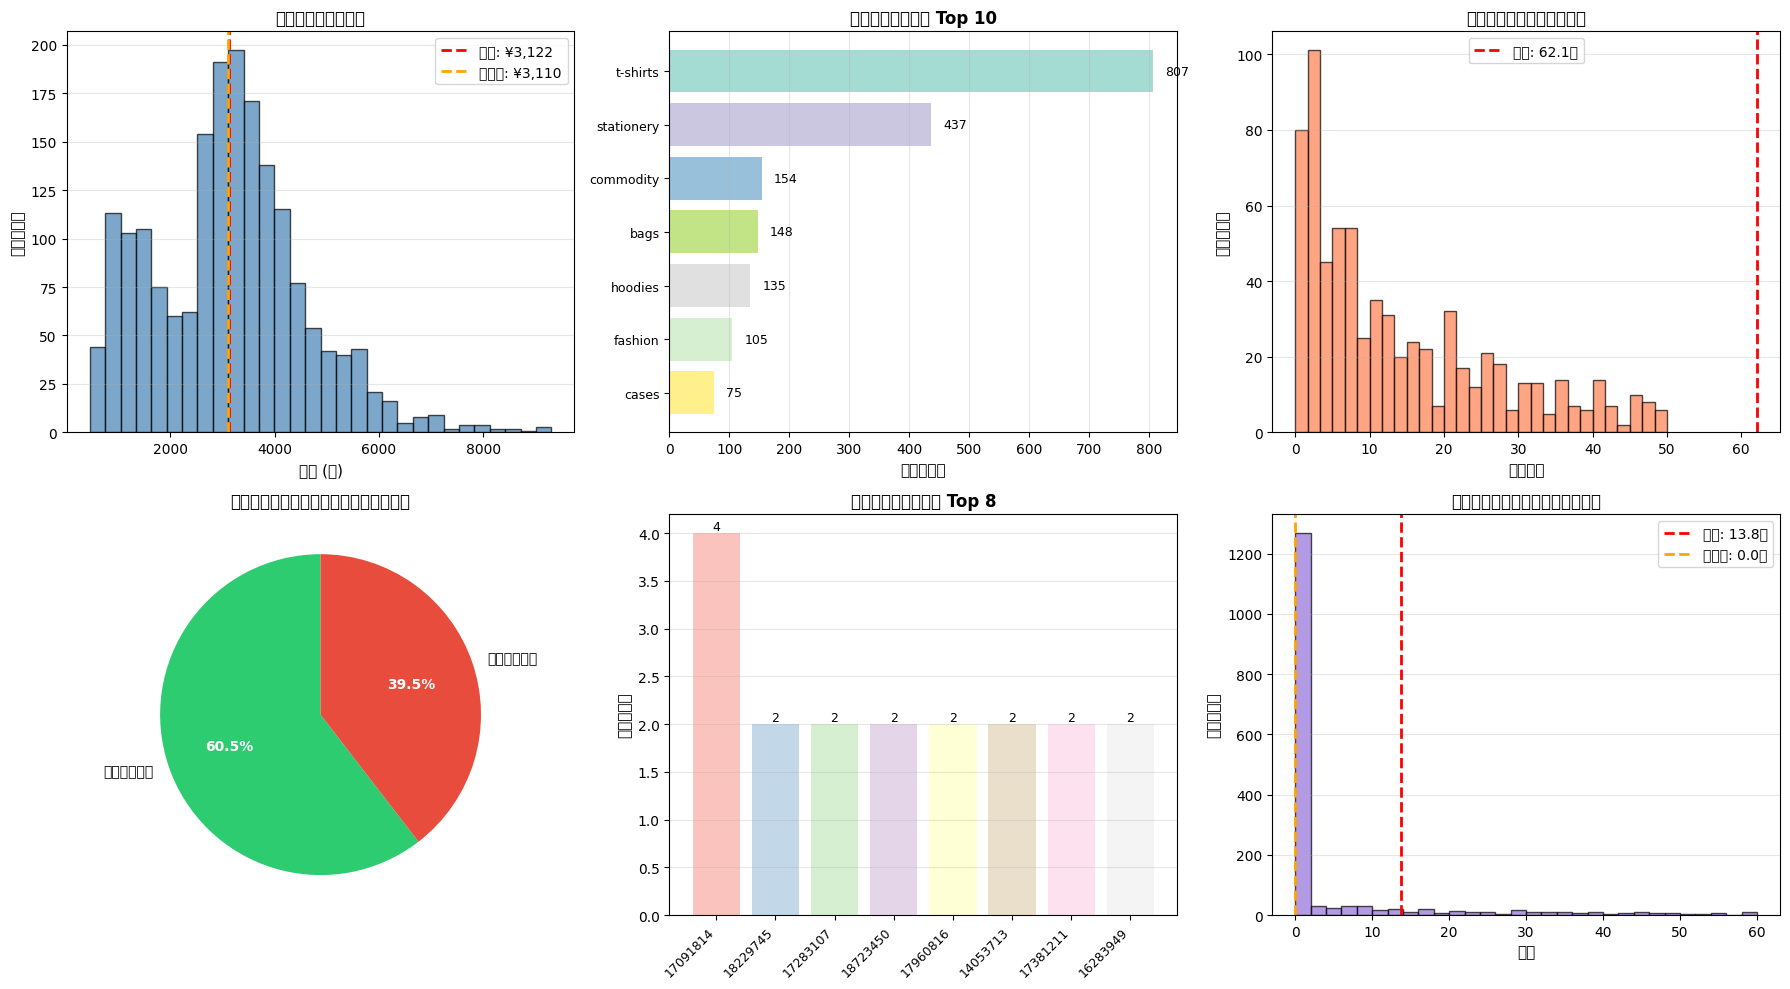


【洞察】
💰 初回購入の中央値: ¥3,110 → 手頃な価格帯が重要
👀 事前閲覧率 39.5% → 60.5%は閲覧なし購入（衝動買い/外部流入）
🔄 リピート率 94.2% → 初回体験の質が継続利用を左右
⏱️ 平均リピート日数 13.8日 → この期間のフォローアップが重要


In [37]:
# ==========================================
# 分析4: 初回購入商品の特性分析
# ==========================================
print("=" * 60)
print("【分析4】初回購入商品の特性分析")
print("=" * 60)

# 各ユーザーの初回購入を特定
print("\n1. 初回購入商品の基本統計")
user_first_purchase = join_data[join_data['event_action'] == 'purchase'].sort_values('accessed_at').groupby('user_id').first()
print(f"初回購入データ数: {len(user_first_purchase):,}")

# 初回購入の価格分布
print("\n2. 初回購入の価格帯分布")
first_purchase_price_dist = pd.cut(
    user_first_purchase['price'],
    bins=[0, 2000, 3000, 4000, 5000, np.inf],
    labels=['～2000円', '2001-3000円', '3001-4000円', '4001-5000円', '5001円～']
).value_counts().sort_index()
print(first_purchase_price_dist)
print(f"\n平均初回購入価格: ¥{user_first_purchase['price'].mean():,.0f}")
print(f"中央値初回購入価格: ¥{user_first_purchase['price'].median():,.0f}")

# 初回購入のカテゴリ分布
print("\n3. 初回購入カテゴリ Top 10")
first_purchase_category = user_first_purchase['item_category_name'].value_counts().head(10)
print(first_purchase_category)
print(f"\nTop 1カテゴリのシェア: {first_purchase_category.iloc[0] / len(user_first_purchase) * 100:.1f}%")

# 初回購入のマテリアル分布（material1を使用）
print("\n4. 初回購入マテリアル Top 10")
first_purchase_material = user_first_purchase['material1'].value_counts().head(10)
print(first_purchase_material)

# 初回購入時の閲覧行動
print("\n5. 初回購入前の閲覧行動")
first_purchase_ids = user_first_purchase.reset_index()[['user_id', 'accessed_at']].rename(
    columns={'accessed_at': 'first_purchase_time'}
)
join_with_first = join_data.merge(first_purchase_ids, on='user_id', how='inner')

# 初回購入前の閲覧
before_first_purchase = join_with_first[
    (join_with_first['event_action'] == 'view') & 
    (join_with_first['accessed_at'] < join_with_first['first_purchase_time'])
].groupby('user_id').agg({
    'product_id': 'count',  # 閲覧回数
    'creator_id': 'nunique',  # ユニーククリエイター数
    'item_category_name': 'nunique'  # ユニークカテゴリ数
})
before_first_purchase.columns = ['views_before_first', 'creators_explored', 'categories_explored']

print(f"\n初回購入前の平均閲覧回数: {before_first_purchase['views_before_first'].mean():.1f}")
print(f"初回購入前の探索クリエイター数: {before_first_purchase['creators_explored'].mean():.1f}")
print(f"初回購入前の探索カテゴリ数: {before_first_purchase['categories_explored'].mean():.1f}")

# 初回購入商品は閲覧商品と同じか？
print("\n6. 初回購入商品は事前に閲覧していたか？")
# 初回購入商品ID
first_purchase_product_ids = user_first_purchase.reset_index()[['user_id', 'product_id']].rename(
    columns={'product_id': 'first_purchase_product'}
)

# 各ユーザーが購入前に閲覧した商品リスト
viewed_products_before = join_with_first[
    (join_with_first['event_action'] == 'view') & 
    (join_with_first['accessed_at'] < join_with_first['first_purchase_time'])
].groupby('user_id')['product_id'].apply(set).reset_index()
viewed_products_before.columns = ['user_id', 'viewed_products']

# マッチング
first_purchase_analysis = first_purchase_product_ids.merge(viewed_products_before, on='user_id', how='left')
first_purchase_analysis['was_viewed_before'] = first_purchase_analysis.apply(
    lambda row: row['first_purchase_product'] in row['viewed_products'] 
    if isinstance(row['viewed_products'], set) else False,
    axis=1
)

viewed_before_rate = first_purchase_analysis['was_viewed_before'].sum() / len(first_purchase_analysis) * 100
print(f"事前閲覧率: {viewed_before_rate:.1f}%")
print(f"閲覧なし購入率: {100 - viewed_before_rate:.1f}%")

# 初回購入後のリピート率
print("\n7. 初回購入後のリピート行動")
all_purchases = join_data[join_data['event_action'] == 'purchase'].groupby('user_id').size()
repeat_purchasers = (all_purchases > 1).sum()
repeat_rate_from_first = repeat_purchasers / len(user_first_purchase) * 100
print(f"初回購入後にリピートしたユーザー: {repeat_purchasers:,} ({repeat_rate_from_first:.1f}%)")

# 初回購入からリピートまでの日数
repeat_users = all_purchases[all_purchases > 1].index
repeat_user_purchases = join_data[
    (join_data['user_id'].isin(repeat_users)) & 
    (join_data['event_action'] == 'purchase')
].copy()
repeat_user_purchases['accessed_at'] = pd.to_datetime(repeat_user_purchases['accessed_at'])
repeat_user_purchases = repeat_user_purchases.sort_values(['user_id', 'accessed_at'])

first_and_second = repeat_user_purchases.groupby('user_id')['accessed_at'].apply(
    lambda x: (x.iloc[1] - x.iloc[0]).days if len(x) >= 2 else None
).dropna()

print(f"平均リピート日数: {first_and_second.mean():.1f}日")
print(f"中央値リピート日数: {first_and_second.median():.1f}日")

# 可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 初回購入価格分布
ax1 = axes[0, 0]
ax1.hist(user_first_purchase['price'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(user_first_purchase['price'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'平均: ¥{user_first_purchase["price"].mean():,.0f}')
ax1.axvline(user_first_purchase['price'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f'中央値: ¥{user_first_purchase["price"].median():,.0f}')
ax1.set_xlabel('価格 (円)', fontsize=11)
ax1.set_ylabel('ユーザー数', fontsize=11)
ax1.set_title('初回購入価格の分布', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. 初回購入カテゴリ Top 10
ax2 = axes[0, 1]
top_cats = first_purchase_category.head(10)
colors_cat = plt.cm.Set3(np.linspace(0, 1, len(top_cats)))
bars = ax2.barh(range(len(top_cats)), top_cats.values, color=colors_cat, alpha=0.8)
ax2.set_yticks(range(len(top_cats)))
ax2.set_yticklabels(top_cats.index, fontsize=9)
ax2.set_xlabel('ユーザー数', fontsize=11)
ax2.set_title('初回購入カテゴリ Top 10', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, top_cats.values)):
    ax2.text(val + 20, bar.get_y() + bar.get_height()/2, 
             f'{val:,}', va='center', fontsize=9)

# 3. 初回購入前の閲覧回数分布
ax3 = axes[0, 2]
ax3.hist(before_first_purchase['views_before_first'], bins=30, color='coral', 
         alpha=0.7, edgecolor='black', range=(0, 50))
ax3.axvline(before_first_purchase['views_before_first'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'平均: {before_first_purchase["views_before_first"].mean():.1f}回')
ax3.set_xlabel('閲覧回数', fontsize=11)
ax3.set_ylabel('ユーザー数', fontsize=11)
ax3.set_title('初回購入前の閲覧回数分布', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. 事前閲覧の有無
ax4 = axes[1, 0]
viewed_counts = first_purchase_analysis['was_viewed_before'].value_counts()
labels = ['事前閲覧あり', '事前閲覧なし']
colors_viewed = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax4.pie(
    viewed_counts.values, 
    labels=labels,
    autopct='%1.1f%%',
    colors=colors_viewed,
    startangle=90
)
ax4.set_title('初回購入商品は事前に閲覧していたか？', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 5. 初回購入マテリアル Top 8
ax5 = axes[1, 1]
top_materials = first_purchase_material.head(8)
colors_mat = plt.cm.Pastel1(np.linspace(0, 1, len(top_materials)))
bars = ax5.bar(range(len(top_materials)), top_materials.values, color=colors_mat, alpha=0.8)
ax5.set_xticks(range(len(top_materials)))
ax5.set_xticklabels(top_materials.index, rotation=45, ha='right', fontsize=9)
ax5.set_ylabel('ユーザー数', fontsize=11)
ax5.set_title('初回購入マテリアル Top 8', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

# 6. リピートまでの日数分布
ax6 = axes[1, 2]
ax6.hist(first_and_second, bins=30, color='mediumpurple', alpha=0.7, edgecolor='black', range=(0, 60))
ax6.axvline(first_and_second.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'平均: {first_and_second.mean():.1f}日')
ax6.axvline(first_and_second.median(), color='orange', linestyle='--', 
            linewidth=2, label=f'中央値: {first_and_second.median():.1f}日')
ax6.set_xlabel('日数', fontsize=11)
ax6.set_ylabel('ユーザー数', fontsize=11)
ax6.set_title('初回購入からリピートまでの日数', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【洞察】")
print("=" * 60)
print(f"💰 初回購入の中央値: ¥{user_first_purchase['price'].median():,.0f} → 手頃な価格帯が重要")
print(f"👀 事前閲覧率 {viewed_before_rate:.1f}% → {100-viewed_before_rate:.1f}%は閲覧なし購入（衝動買い/外部流入）")
print(f"🔄 リピート率 {repeat_rate_from_first:.1f}% → 初回体験の質が継続利用を左右")
print(f"⏱️ 平均リピート日数 {first_and_second.mean():.1f}日 → この期間のフォローアップが重要")


【分析5】クリエイター特性プロファイリング

1. クリエイター基本統計
クリエイター数: 26,247

平均商品数: 5.6
平均CVR: inf%
平均売上: ¥3,982

2. 成功クリエイター（売上上位20%）の特徴
       指標       上位20%  その他80%  差分倍率
      商品数    5.640378     NaN   NaN
  カテゴリ多様性    1.685412     NaN   NaN
 マテリアル多様性    3.558197     NaN   NaN
     平均価格 2790.383170     NaN   NaN
   CVR(%)         inf     NaN   NaN
お気に入り率(%)         inf     NaN   NaN
      閲覧数   12.353526     NaN   NaN
       売上 3981.689984     NaN   NaN

3. クリエイタータイプ分類

4. タイプ別平均売上
                                                   count     mean
price_strategy assortment_strategy specialization                
高価格型           大規模型                バランス型              48  91503.0
                                   多角型                90  82420.0
中価格型           大規模型                多角型               513  75315.0
高価格型           大規模型                専門型                 6  61617.0
中価格型           大規模型                専門型                17  45190.0
                                   バランス型             236  34774.0
高価格型

/home/intern2026-wntr-003/SUZURI/.venv/lib/python3.14/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/tmp/ipykernel_1180/123233640.py:199: UserWarning: Glyph 22770 (\N{CJK UNIFIED IDEOGRAPH-58F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/123233640.py:199: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/123233640.py:199: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/123233640.py:199: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/123233640.py:199: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/123233640.py:199: UserWa

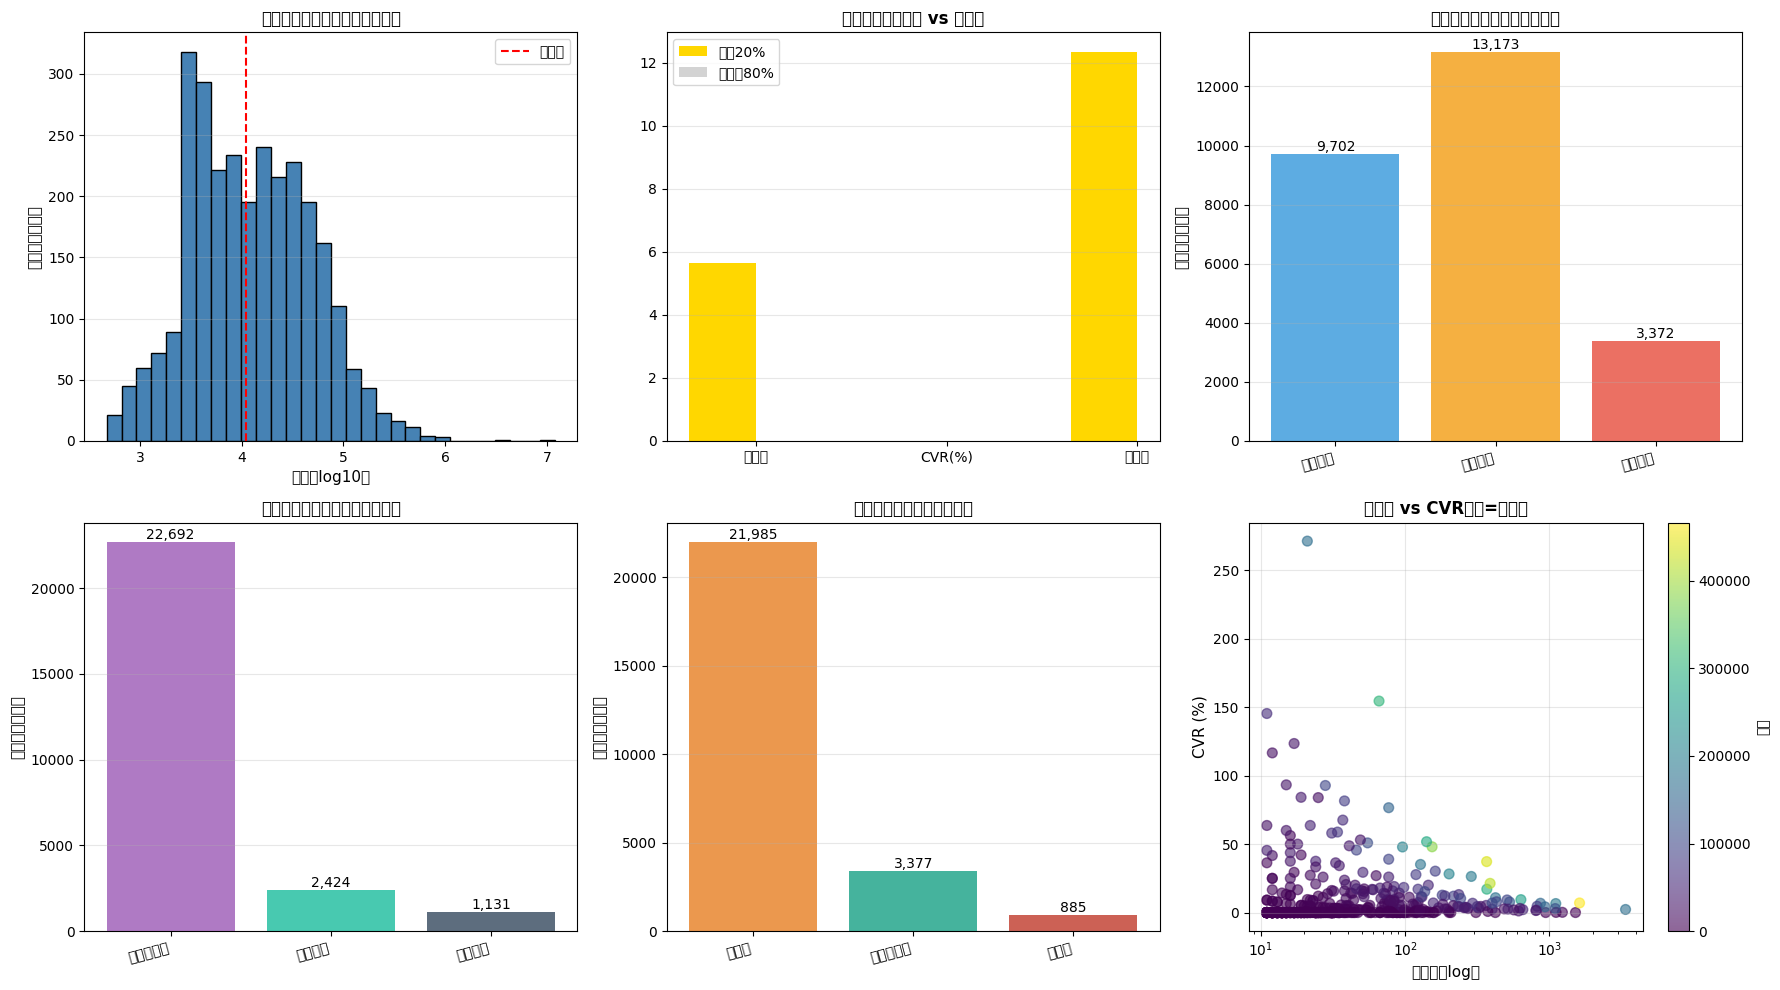


【洞察】
💡 成功クリエイターの特徴: 商品数がnan倍、閲覧数が大幅に多い
📊 平均CVR inf% → クリエイター間で差が大きい
⚠️ 売上中央値: ¥0 → ロングテール構造


In [41]:
# ==========================================
# 分析5: クリエイター特性プロファイリング
# ==========================================
print("=" * 60)
print("【分析5】クリエイター特性プロファイリング")
print("=" * 60)

# クリエイター基本統計
print("\n1. クリエイター基本統計")
creator_profile = join_data.groupby('creator_id').agg({
    'product_id': 'nunique',  # 商品数
    'item_category_name': lambda x: x.nunique(),  # カテゴリ数
    'material1': lambda x: x.nunique(),  # マテリアル数（material1のみ）
    'price': ['mean', 'std', 'min', 'max'],  # 価格統計
    'event_action': [
        lambda x: (x == 'view').sum(),  # 閲覧数
        lambda x: (x == 'favorite').sum(),  # お気に入り数
        lambda x: (x == 'purchase').sum()  # 購入数
    ]
})
creator_profile.columns = ['product_count', 'category_count', 'material_count', 
                          'avg_price', 'price_std', 'min_price', 'max_price',
                          'view_count', 'favorite_count', 'purchase_count']

# CVRの計算
creator_profile['cvr'] = (creator_profile['purchase_count'] / creator_profile['view_count'] * 100).fillna(0).round(2)
creator_profile['favorite_rate'] = (creator_profile['favorite_count'] / creator_profile['view_count'] * 100).fillna(0).round(2)

# 売上の計算
purchase_data_creator = join_data[join_data['event_action'] == 'purchase'].groupby('creator_id')['price'].sum()
creator_profile['total_revenue'] = purchase_data_creator.reindex(creator_profile.index, fill_value=0)

print(f"クリエイター数: {len(creator_profile):,}")
print(f"\n平均商品数: {creator_profile['product_count'].mean():.1f}")
print(f"平均CVR: {creator_profile['cvr'].mean():.2f}%")
print(f"平均売上: ¥{creator_profile['total_revenue'].mean():,.0f}")

# 成功クリエイターの定義（上位20%）
print("\n2. 成功クリエイター（売上上位20%）の特徴")
revenue_threshold = creator_profile['total_revenue'].quantile(0.8)
top_creators_profile = creator_profile[creator_profile['total_revenue'] >= revenue_threshold]
bottom_creators_profile = creator_profile[creator_profile['total_revenue'] < revenue_threshold]

comparison_df = pd.DataFrame({
    '指標': ['商品数', 'カテゴリ多様性', 'マテリアル多様性', '平均価格', 
            'CVR(%)', 'お気に入り率(%)', '閲覧数', '売上'],
    '上位20%': [
        top_creators_profile['product_count'].mean(),
        top_creators_profile['category_count'].mean(),
        top_creators_profile['material_count'].mean(),
        top_creators_profile['avg_price'].mean(),
        top_creators_profile['cvr'].mean(),
        top_creators_profile['favorite_rate'].mean(),
        top_creators_profile['view_count'].mean(),
        top_creators_profile['total_revenue'].mean()
    ],
    'その他80%': [
        bottom_creators_profile['product_count'].mean(),
        bottom_creators_profile['category_count'].mean(),
        bottom_creators_profile['material_count'].mean(),
        bottom_creators_profile['avg_price'].mean(),
        bottom_creators_profile['cvr'].mean(),
        bottom_creators_profile['favorite_rate'].mean(),
        bottom_creators_profile['view_count'].mean(),
        bottom_creators_profile['total_revenue'].mean()
    ]
})
comparison_df['差分倍率'] = (comparison_df['上位20%'] / comparison_df['その他80%']).round(2)
print(comparison_df.to_string(index=False))

# クリエイターのタイプ分類
print("\n3. クリエイタータイプ分類")
# 価格戦略
creator_profile['price_strategy'] = pd.cut(
    creator_profile['avg_price'],
    bins=[0, 2500, 4000, np.inf],
    labels=['低価格型', '中価格型', '高価格型']
)

# 品揃え戦略
creator_profile['assortment_strategy'] = pd.cut(
    creator_profile['product_count'],
    bins=[0, 5, 20, np.inf],
    labels=['少数精鋭型', '中規模型', '大規模型']
)

# 専門性
creator_profile['specialization'] = pd.cut(
    creator_profile['category_count'],
    bins=[0, 2, 5, np.inf],
    labels=['専門型', 'バランス型', '多角型']
)

# タイプ別の売上
print("\n4. タイプ別平均売上")
type_revenue = creator_profile.groupby(['price_strategy', 'assortment_strategy', 'specialization'], 
                                       observed=True)['total_revenue'].agg(['count', 'mean']).round(0)
type_revenue = type_revenue[type_revenue['count'] >= 5].sort_values('mean', ascending=False).head(10)
print(type_revenue)

# アクティビティレベルの分析
print("\n5. アクティビティレベル別の成功率")
creator_profile['activity_level'] = pd.cut(
    creator_profile['view_count'],
    bins=[0, 100, 500, 2000, np.inf],
    labels=['低活動', '中活動', '高活動', '超高活動']
)

activity_success = creator_profile.groupby('activity_level', observed=True).agg({
    'total_revenue': 'mean',
    'cvr': 'mean',
    'product_count': 'mean'
}).round(2)
activity_success['クリエイター数'] = creator_profile.groupby('activity_level', observed=True).size()
activity_success.columns = ['平均売上', '平均CVR(%)', '平均商品数', 'クリエイター数']
print(activity_success)

# 可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. クリエイター売上分布（対数スケール）
ax1 = axes[0, 0]
revenue_data = creator_profile[creator_profile['total_revenue'] > 0]['total_revenue']
ax1.hist(np.log10(revenue_data + 1), bins=30, color='steelblue', edgecolor='black')
ax1.set_xlabel('売上（log10）', fontsize=11)
ax1.set_ylabel('クリエイター数', fontsize=11)
ax1.set_title('クリエイター売上分布（対数）', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axvline(np.log10(revenue_data.median() + 1), color='red', linestyle='--', label=f'中央値')
ax1.legend()

# 2. 成功クリエイター比較
ax2 = axes[0, 1]
comparison_metrics = ['商品数', 'CVR(%)', '閲覧数']
comparison_indices = [0, 4, 6]
x = np.arange(len(comparison_metrics))
width = 0.35
bars1 = ax2.bar(x - width/2, [comparison_df.iloc[i]['上位20%'] for i in comparison_indices], 
                width, label='上位20%', color='gold')
bars2 = ax2.bar(x + width/2, [comparison_df.iloc[i]['その他80%'] for i in comparison_indices], 
                width, label='その他80%', color='lightgray')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_metrics)
ax2.set_title('成功クリエイター vs その他', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. 価格戦略別の分布
ax3 = axes[0, 2]
price_dist = creator_profile['price_strategy'].value_counts(sort=False)
colors_price = ['#3498db', '#f39c12', '#e74c3c']
ax3.bar(range(len(price_dist)), price_dist.values, color=colors_price, alpha=0.8)
ax3.set_xticks(range(len(price_dist)))
ax3.set_xticklabels(price_dist.index, rotation=15, ha='right')
ax3.set_ylabel('クリエイター数', fontsize=11)
ax3.set_title('価格戦略別クリエイター分布', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(price_dist.values):
    ax3.text(i, v, f'{v:,}', ha='center', va='bottom')

# 4. 品揃え戦略別の分布
ax4 = axes[1, 0]
assort_dist = creator_profile['assortment_strategy'].value_counts(sort=False)
colors_assort = ['#9b59b6', '#1abc9c', '#34495e']
ax4.bar(range(len(assort_dist)), assort_dist.values, color=colors_assort, alpha=0.8)
ax4.set_xticks(range(len(assort_dist)))
ax4.set_xticklabels(assort_dist.index, rotation=15, ha='right')
ax4.set_ylabel('クリエイター数', fontsize=11)
ax4.set_title('品揃え戦略別クリエイター分布', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(assort_dist.values):
    ax4.text(i, v, f'{v:,}', ha='center', va='bottom')

# 5. 専門性別の分布
ax5 = axes[1, 1]
spec_dist = creator_profile['specialization'].value_counts(sort=False)
colors_spec = ['#e67e22', '#16a085', '#c0392b']
ax5.bar(range(len(spec_dist)), spec_dist.values, color=colors_spec, alpha=0.8)
ax5.set_xticks(range(len(spec_dist)))
ax5.set_xticklabels(spec_dist.index, rotation=15, ha='right')
ax5.set_ylabel('クリエイター数', fontsize=11)
ax5.set_title('専門性別クリエイター分布', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for i, v in enumerate(spec_dist.values):
    ax5.text(i, v, f'{v:,}', ha='center', va='bottom')

# 6. CVR vs 閲覧数の散布図
ax6 = axes[1, 2]
sample_creators = creator_profile[creator_profile['view_count'] > 10].sample(min(500, len(creator_profile)))
sc = ax6.scatter(sample_creators['view_count'], sample_creators['cvr'], 
                 c=sample_creators['total_revenue'], cmap='viridis', alpha=0.6, s=50)
ax6.set_xlabel('閲覧数（log）', fontsize=11)
ax6.set_ylabel('CVR (%)', fontsize=11)
ax6.set_xscale('log')
ax6.set_title('閲覧数 vs CVR（色=売上）', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)
plt.colorbar(sc, ax=ax6, label='売上')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【洞察】")
print("=" * 60)
top_multiplier = comparison_df[comparison_df['指標'] == '商品数']['差分倍率'].values[0]
print(f"💡 成功クリエイターの特徴: 商品数が{top_multiplier}倍、閲覧数が大幅に多い")
print(f"📊 平均CVR {creator_profile['cvr'].mean():.2f}% → クリエイター間で差が大きい")
print(f"⚠️ 売上中央値: ¥{creator_profile['total_revenue'].median():,.0f} → ロングテール構造")


【分析6】お気に入り vs 購入のギャップ分析

1. お気に入りと購入の基本統計
お気に入り登録したユーザー: 1,403
購入したユーザー: 1,861
両方経験したユーザー: 1,091

2. お気に入りユーザーの購入転換
お気に入り登録後の購入率: 77.8%
お気に入りのみで購入なし: 22.2%

3. ユーザー行動パターン
pattern
両方あり       1091
購入のみ        770
お気に入りのみ     312
Name: count, dtype: int64

パターン                  比率
両方あり               50.2%
購入のみ               35.4%
お気に入りのみ            14.4%

4. 商品レベル: お気に入り vs 購入
ギャップ商品数（お気に入り多数・購入少数）: 1
平均お気に入り数: 10.0
平均購入数: 1.0

5. お気に入り後の購入タイミング
お気に入り後に購入したユーザー: 411
平均日数: 57.6日
中央値: 28.0日


/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 12518 (\N{KATAKANA LETTER YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2688331303.py:207: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing fro

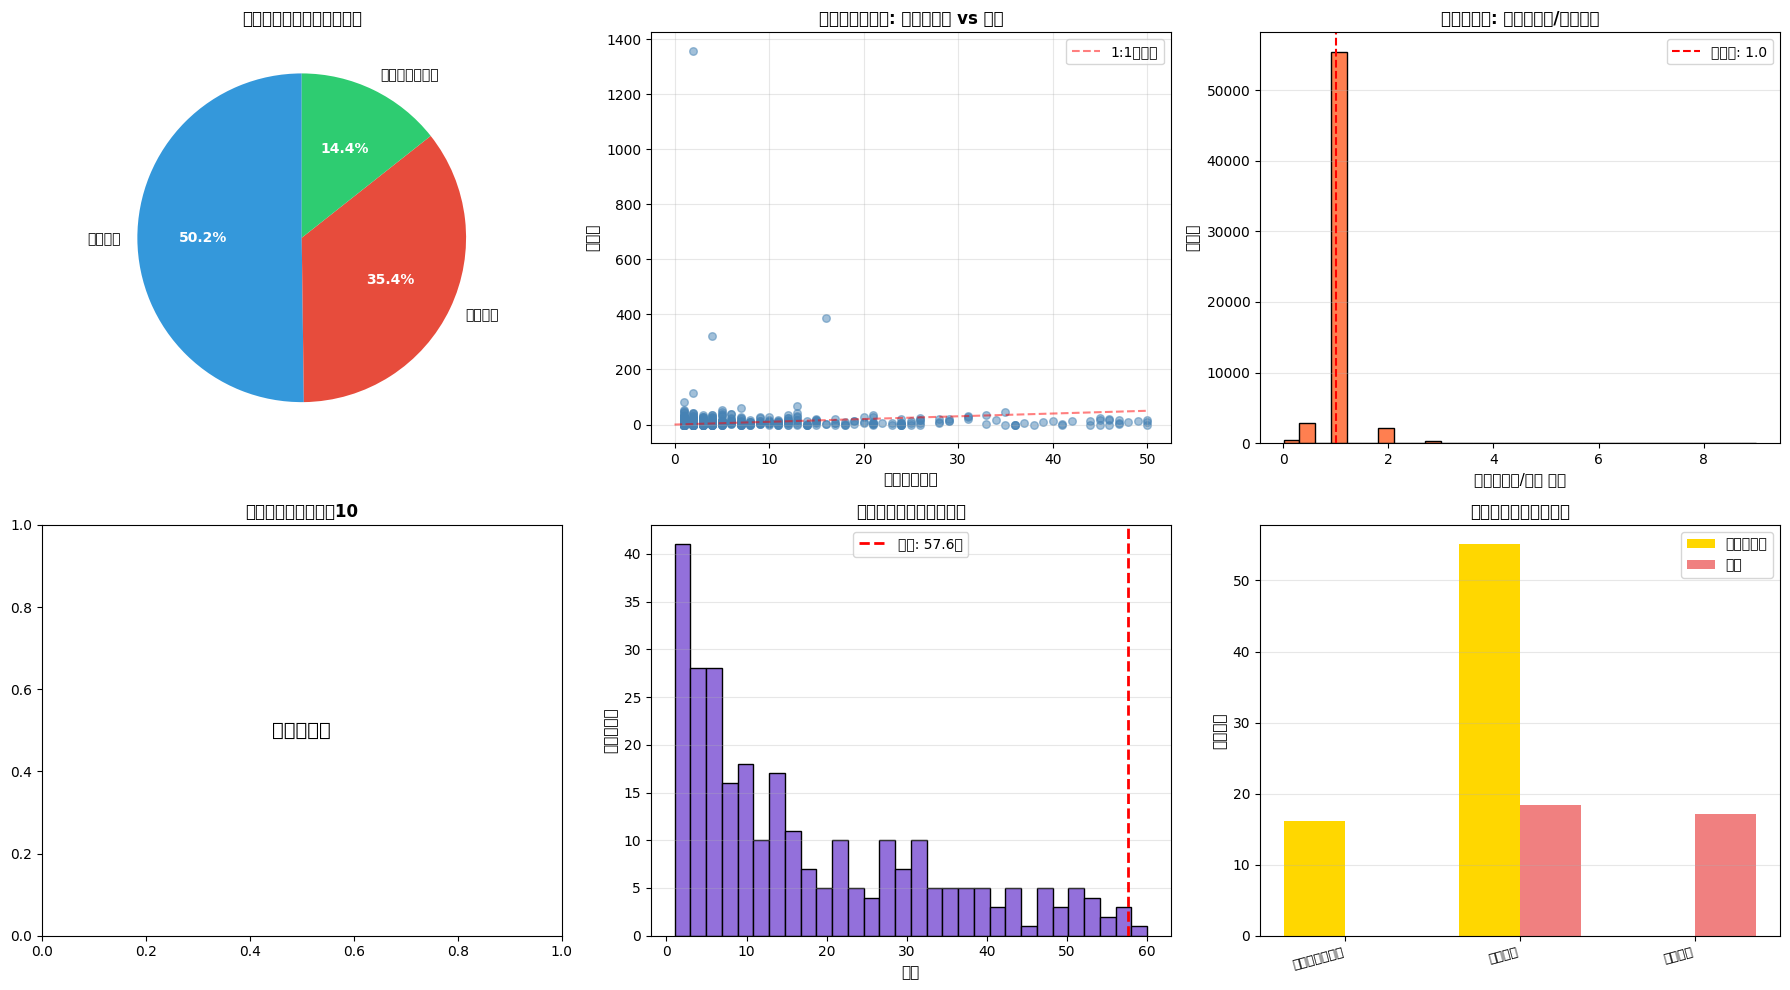


【洞察】
💡 お気に入り→購入転換率 77.8% → お気に入りは購入の強いシグナル
📊 購入のみユーザー 770人 → 衝動買い・外部流入が多い
⚠️ ギャップ商品 1個 → 価格や在庫が購入障壁の可能性


In [42]:
# ==========================================
# 分析6: お気に入り vs 購入のギャップ分析
# ==========================================
print("=" * 60)
print("【分析6】お気に入り vs 購入のギャップ分析")
print("=" * 60)

# ユーザーごとのお気に入りと購入の集計
print("\n1. お気に入りと購入の基本統計")
user_favorites = join_data[join_data['event_action'] == 'favorite'].groupby('user_id').size()
user_purchases = join_data[join_data['event_action'] == 'purchase'].groupby('user_id').size()

user_fav_purchase = pd.DataFrame({
    'favorite_count': user_favorites,
    'purchase_count': user_purchases
}).fillna(0).astype(int)

print(f"お気に入り登録したユーザー: {(user_fav_purchase['favorite_count'] > 0).sum():,}")
print(f"購入したユーザー: {(user_fav_purchase['purchase_count'] > 0).sum():,}")
print(f"両方経験したユーザー: {((user_fav_purchase['favorite_count'] > 0) & (user_fav_purchase['purchase_count'] > 0)).sum():,}")

# お気に入りから購入への転換率
print("\n2. お気に入りユーザーの購入転換")
favorited_users = user_fav_purchase[user_fav_purchase['favorite_count'] > 0]
fav_to_purchase_rate = (favorited_users['purchase_count'] > 0).sum() / len(favorited_users) * 100
print(f"お気に入り登録後の購入率: {fav_to_purchase_rate:.1f}%")
print(f"お気に入りのみで購入なし: {((favorited_users['purchase_count'] == 0).sum() / len(favorited_users) * 100):.1f}%")

# お気に入りと購入のパターン分類
print("\n3. ユーザー行動パターン")
user_fav_purchase['pattern'] = 'その他'
user_fav_purchase.loc[
    (user_fav_purchase['favorite_count'] > 0) & (user_fav_purchase['purchase_count'] == 0),
    'pattern'
] = 'お気に入りのみ'
user_fav_purchase.loc[
    (user_fav_purchase['favorite_count'] == 0) & (user_fav_purchase['purchase_count'] > 0),
    'pattern'
] = '購入のみ'
user_fav_purchase.loc[
    (user_fav_purchase['favorite_count'] > 0) & (user_fav_purchase['purchase_count'] > 0),
    'pattern'
] = '両方あり'

pattern_dist = user_fav_purchase['pattern'].value_counts()
print(pattern_dist)
print(f"\n{'パターン':<15} {'比率':>8}")
for pattern, count in pattern_dist.items():
    print(f"{pattern:<15} {count/len(user_fav_purchase)*100:>7.1f}%")

# 商品レベルでの分析
print("\n4. 商品レベル: お気に入り vs 購入")
product_favorites = join_data[join_data['event_action'] == 'favorite'].groupby('product_id').size()
product_purchases = join_data[join_data['event_action'] == 'purchase'].groupby('product_id').size()

product_fav_purchase = pd.DataFrame({
    'favorite_count': product_favorites,
    'purchase_count': product_purchases
}).fillna(0).astype(int)

# お気に入りが多いが購入が少ない商品（ギャップ商品）
product_fav_purchase['fav_purchase_ratio'] = (
    product_fav_purchase['favorite_count'] / (product_fav_purchase['purchase_count'] + 1)
).round(2)

# ギャップ商品の特定（お気に入り10以上、比率5以上）
gap_products = product_fav_purchase[
    (product_fav_purchase['favorite_count'] >= 10) & 
    (product_fav_purchase['fav_purchase_ratio'] >= 5)
].sort_values('favorite_count', ascending=False)

print(f"ギャップ商品数（お気に入り多数・購入少数）: {len(gap_products)}")
print(f"平均お気に入り数: {gap_products['favorite_count'].mean():.1f}")
print(f"平均購入数: {gap_products['purchase_count'].mean():.1f}")

# お気に入りチャネルからの購入分析
print("\n5. お気に入り後の購入タイミング")
# お気に入りと購入の両方があるユーザー
both_users = user_fav_purchase[
    (user_fav_purchase['favorite_count'] > 0) & 
    (user_fav_purchase['purchase_count'] > 0)
].index

# これらのユーザーのお気に入りと購入の時系列
fav_events = join_data[
    (join_data['user_id'].isin(both_users)) & 
    (join_data['event_action'] == 'favorite')
].copy()
fav_events['accessed_at'] = pd.to_datetime(fav_events['accessed_at'])

purchase_events = join_data[
    (join_data['user_id'].isin(both_users)) & 
    (join_data['event_action'] == 'purchase')
].copy()
purchase_events['accessed_at'] = pd.to_datetime(purchase_events['accessed_at'])

# サンプルとして、最初のお気に入りから最初の購入までの日数を計算
first_fav = fav_events.groupby('user_id')['accessed_at'].min()
first_purchase = purchase_events.groupby('user_id')['accessed_at'].min()

fav_to_purchase_days = pd.DataFrame({
    'first_fav': first_fav,
    'first_purchase': first_purchase
})
fav_to_purchase_days['days_to_purchase'] = (
    fav_to_purchase_days['first_purchase'] - fav_to_purchase_days['first_fav']
).dt.days

# お気に入り後に購入したユーザー（正の日数）
after_fav_purchase = fav_to_purchase_days[fav_to_purchase_days['days_to_purchase'] > 0]
print(f"お気に入り後に購入したユーザー: {len(after_fav_purchase)}")
if len(after_fav_purchase) > 0:
    print(f"平均日数: {after_fav_purchase['days_to_purchase'].mean():.1f}日")
    print(f"中央値: {after_fav_purchase['days_to_purchase'].median():.1f}日")

# 可視化
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. ユーザーパターン分布
ax1 = axes[0, 0]
colors_pattern = ['#3498db', '#e74c3c', '#2ecc71', '#95a5a6']
wedges, texts, autotexts = ax1.pie(
    pattern_dist.values,
    labels=pattern_dist.index,
    autopct='%1.1f%%',
    colors=colors_pattern,
    startangle=90
)
ax1.set_title('ユーザー行動パターン分布', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 2. お気に入り数 vs 購入数（ユーザーレベル）
ax2 = axes[0, 1]
sample_users_data = user_fav_purchase[
    (user_fav_purchase['favorite_count'] > 0) & 
    (user_fav_purchase['favorite_count'] <= 50)
].sample(min(500, len(user_fav_purchase)))
ax2.scatter(sample_users_data['favorite_count'], sample_users_data['purchase_count'], 
           alpha=0.5, s=30, color='steelblue')
ax2.plot([0, 50], [0, 50], 'r--', alpha=0.5, label='1:1ライン')
ax2.set_xlabel('お気に入り数', fontsize=11)
ax2.set_ylabel('購入数', fontsize=11)
ax2.set_title('ユーザーレベル: お気に入り vs 購入', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 商品レベル: お気に入り-購入比率
ax3 = axes[0, 2]
ratio_dist = product_fav_purchase[product_fav_purchase['favorite_count'] > 0]['fav_purchase_ratio']
ax3.hist(ratio_dist[ratio_dist <= 20], bins=30, color='coral', edgecolor='black')
ax3.set_xlabel('お気に入り/購入 比率', fontsize=11)
ax3.set_ylabel('商品数', fontsize=11)
ax3.set_title('商品レベル: お気に入り/購入比率', fontsize=12, fontweight='bold')
ax3.axvline(ratio_dist.median(), color='red', linestyle='--', label=f'中央値: {ratio_dist.median():.1f}')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. ギャップ商品トップ10
ax4 = axes[1, 0]
if len(gap_products) >= 10:
    top_gap = gap_products.head(10)
    ax4.barh(range(len(top_gap)), top_gap['favorite_count'].values, color='gold', alpha=0.8, label='お気に入り')
    ax4.barh(range(len(top_gap)), top_gap['purchase_count'].values, color='lightcoral', alpha=0.8, label='購入')
    ax4.set_yticks(range(len(top_gap)))
    ax4.set_yticklabels([f'商品{i+1}' for i in range(len(top_gap))], fontsize=9)
    ax4.set_xlabel('回数', fontsize=11)
    ax4.set_title('ギャップ商品トップ10', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'データ不足', ha='center', va='center', fontsize=14)
    ax4.set_title('ギャップ商品トップ10', fontsize=12, fontweight='bold')

# 5. お気に入り後購入までの日数分布
ax5 = axes[1, 1]
if len(after_fav_purchase) > 0:
    ax5.hist(after_fav_purchase['days_to_purchase'][after_fav_purchase['days_to_purchase'] <= 60], 
            bins=30, color='mediumpurple', edgecolor='black')
    ax5.axvline(after_fav_purchase['days_to_purchase'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'平均: {after_fav_purchase["days_to_purchase"].mean():.1f}日')
    ax5.set_xlabel('日数', fontsize=11)
    ax5.set_ylabel('ユーザー数', fontsize=11)
    ax5.set_title('お気に入り後の購入日数', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'データ不足', ha='center', va='center', fontsize=14)
    ax5.set_title('お気に入り後の購入日数', fontsize=12, fontweight='bold')

# 6. パターン別の平均行動量
ax6 = axes[1, 2]
pattern_avg = user_fav_purchase.groupby('pattern')[['favorite_count', 'purchase_count']].mean()
x = np.arange(len(pattern_avg))
width = 0.35
bars1 = ax6.bar(x - width/2, pattern_avg['favorite_count'], width, label='お気に入り', color='gold')
bars2 = ax6.bar(x + width/2, pattern_avg['purchase_count'], width, label='購入', color='lightcoral')
ax6.set_xticks(x)
ax6.set_xticklabels(pattern_avg.index, rotation=15, ha='right', fontsize=9)
ax6.set_ylabel('平均回数', fontsize=11)
ax6.set_title('パターン別平均行動量', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("【洞察】")
print("=" * 60)
print(f"💡 お気に入り→購入転換率 {fav_to_purchase_rate:.1f}% → お気に入りは購入の強いシグナル")
print(f"📊 購入のみユーザー {pattern_dist.get('購入のみ', 0):,}人 → 衝動買い・外部流入が多い")
print(f"⚠️ ギャップ商品 {len(gap_products)}個 → 価格や在庫が購入障壁の可能性")


# 高度な特徴量エンジニアリング

以下の4つの高度な特徴量を実装します:
1. **ユーザーエントロピー**: 趣味の多様性（単推し vs 箱推し）をシャノンエントロピーで数値化
2. **クリエイターモメンタム**: 移動平均の傾きで「今キテる」クリエイターを検出
3. **周期的時間エンコーディング**: sin/cosで季節性を表現（12月と1月の近さを表現）
4. **コミュニティ密度**: ユーザー間のネットワーク分析で界隈の結合度を測定

[Advanced Feature 1] User Entropy - Diversity of Interests

📊 ユーザーエントロピーの基本統計:
  平均クリエイターエントロピー: 0.404
  平均カテゴリエントロピー: 0.979
  正規化エントロピー(平均): 0.224

👤 ユーザータイプの分布:
user_type
Focused (単推し)    1402
Diverse (箱推し)     383
Balanced           76
Name: count, dtype: int64
  Focused (単推し): 75.3%
  Diverse (箱推し): 20.6%
  Balanced: 4.1%

💰 ユーザータイプ別のLTV:
                       mean   median  count
user_type                                  
Balanced       52714.460526  35240.5     76
Diverse (箱推し)  45283.161880  32180.0    383
Focused (単推し)  59313.599857  29423.0   1402

📈 エントロピーと購買行動の相関:
                 creator_entropy  purchase_count  total_spending
creator_entropy         1.000000        0.033747        0.016500
purchase_count          0.033747        1.000000        0.983943
total_spending          0.016500        0.983943        1.000000


/tmp/ipykernel_1180/992211678.py:129: UserWarning: Glyph 21336 (\N{CJK UNIFIED IDEOGRAPH-5358}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/992211678.py:129: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/992211678.py:129: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/992211678.py:129: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/intern2026-wntr-003/SUZURI/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21336 (\N{CJK UNIFIED IDEOGRAPH-5358}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/intern2026-wntr-003/SUZURI/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from

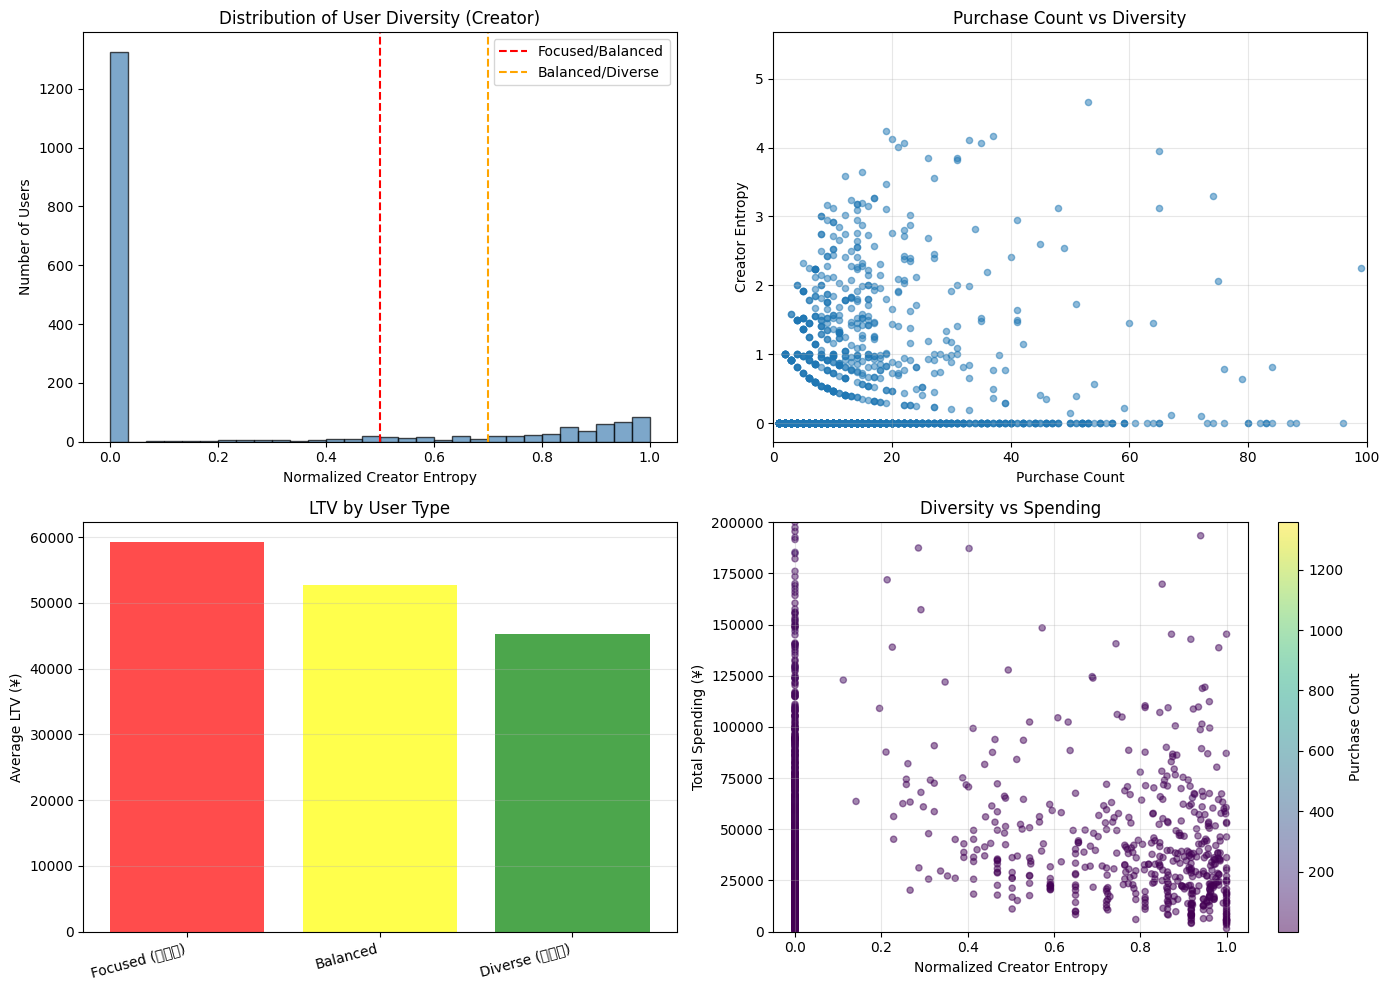


✨ バンディットアルゴリズムへの活用

**探索率（ε）の動的調整:**

1. 単推し型ユーザー（エントロピー < 0.5）
   → ε = 0.05-0.10（探索5-10%）
   → 保守的なので、確実に好きなものを推薦
   → 新しいものは慎重に、既存の好みに近いものから

2. バランス型ユーザー（エントロピー 0.5-0.7）
   → ε = 0.15-0.20（探索15-20%）
   → 標準的な探索戦略
   → 人気商品と新規商品をバランスよく

3. 箱推し型ユーザー（エントロピー > 0.7）
   → ε = 0.25-0.35（探索25-35%）
   → 冒険好きなので大胆なレコメンド
   → 全く新しいクリエイターやニッチなカテゴリも積極的に推薦

**実装例:**
```python
def get_exploration_rate(user_id, user_entropy_df):
    user_entropy = user_entropy_df[user_entropy_df['user_id'] == user_id]['normalized_creator_entropy'].values[0]

    if user_entropy < 0.5:
        return 0.05 + user_entropy * 0.1  # 0.05-0.10
    elif user_entropy < 0.7:
        return 0.10 + (user_entropy - 0.5) * 0.5  # 0.10-0.20
    else:
        return 0.20 + (user_entropy - 0.7) * 0.5  # 0.20-0.35
```

**期待効果:**
- ユーザー満足度向上（各自の好みに合った探索度）
- 離脱率低減（保守的ユーザーへの過度な探索を防ぐ）
- 新規クリエイター発見（冒険好きユーザーが試してくれる）



In [23]:
# ==========================================
# 高度特徴量1: ユーザーエントロピー（趣味の多様性）
# ==========================================
print("=" * 70)
print("[Advanced Feature 1] User Entropy - Diversity of Interests")
print("=" * 70)

from scipy.stats import entropy

# ユーザーごとの購入クリエイター分布
user_creator_entropy = []
user_category_entropy = []

for user_id in df_purchase['user_id'].unique():
    user_purchases = df_purchase[df_purchase['user_id'] == user_id]
    
    # クリエイター分布のエントロピー
    creator_dist = user_purchases['creator_id'].value_counts(normalize=True)
    creator_entropy = entropy(creator_dist.values, base=2)  # シャノンエントロピー
    
    # カテゴリ分布のエントロピー
    category_dist = user_purchases['item_category_name'].value_counts(normalize=True)
    category_entropy = entropy(category_dist.values, base=2)
    
    user_creator_entropy.append({
        'user_id': user_id,
        'purchase_count': len(user_purchases),
        'unique_creators': user_purchases['creator_id'].nunique(),
        'unique_categories': user_purchases['item_category_name'].nunique(),
        'creator_entropy': creator_entropy,
        'category_entropy': category_entropy,
        'total_spending': user_purchases['price'].sum()
    })

user_entropy_df = pd.DataFrame(user_creator_entropy)

# エントロピーの最大値（完全に分散している場合）
user_entropy_df['max_creator_entropy'] = np.log2(user_entropy_df['unique_creators'])
user_entropy_df['max_category_entropy'] = np.log2(user_entropy_df['unique_categories'])

# 正規化エントロピー（0-1）
user_entropy_df['normalized_creator_entropy'] = (
    user_entropy_df['creator_entropy'] / user_entropy_df['max_creator_entropy']
).fillna(0)
user_entropy_df['normalized_category_entropy'] = (
    user_entropy_df['category_entropy'] / user_entropy_df['max_category_entropy']
).fillna(0)

# ユーザータイプの分類
# 低エントロピー(<0.5): 単推し型（保守的）
# 高エントロピー(>0.7): 箱推し型（冒険好き）
# 中間: バランス型
def classify_user_type(entropy):
    if entropy < 0.5:
        return 'Focused (単推し)'
    elif entropy > 0.7:
        return 'Diverse (箱推し)'
    else:
        return 'Balanced'

user_entropy_df['user_type'] = user_entropy_df['normalized_creator_entropy'].apply(classify_user_type)

print(f"\n📊 ユーザーエントロピーの基本統計:")
print(f"  平均クリエイターエントロピー: {user_entropy_df['creator_entropy'].mean():.3f}")
print(f"  平均カテゴリエントロピー: {user_entropy_df['category_entropy'].mean():.3f}")
print(f"  正規化エントロピー(平均): {user_entropy_df['normalized_creator_entropy'].mean():.3f}")

print(f"\n👤 ユーザータイプの分布:")
type_distribution = user_entropy_df['user_type'].value_counts()
print(type_distribution)
for user_type, count in type_distribution.items():
    print(f"  {user_type}: {count/len(user_entropy_df):.1%}")

# エントロピーとLTVの関係
ltv_by_type = user_entropy_df.groupby('user_type')['total_spending'].agg(['mean', 'median', 'count'])
print(f"\n💰 ユーザータイプ別のLTV:")
print(ltv_by_type)

# エントロピーと購入回数の関係
correlation = user_entropy_df[['creator_entropy', 'purchase_count', 'total_spending']].corr()
print(f"\n📈 エントロピーと購買行動の相関:")
print(correlation)

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# エントロピー分布
axes[0, 0].hist(user_entropy_df['normalized_creator_entropy'], bins=30,
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Normalized Creator Entropy')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_title('Distribution of User Diversity (Creator)')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', label='Focused/Balanced')
axes[0, 0].axvline(x=0.7, color='orange', linestyle='--', label='Balanced/Diverse')
axes[0, 0].legend()

# エントロピー vs 購入回数
axes[0, 1].scatter(user_entropy_df['purchase_count'],
                   user_entropy_df['creator_entropy'],
                   alpha=0.5, s=20)
axes[0, 1].set_xlabel('Purchase Count')
axes[0, 1].set_ylabel('Creator Entropy')
axes[0, 1].set_title('Purchase Count vs Diversity')
axes[0, 1].set_xlim(0, 100)
axes[0, 1].grid(True, alpha=0.3)

# ユーザータイプ別のLTV
type_order = ['Focused (単推し)', 'Balanced', 'Diverse (箱推し)']
type_data = [ltv_by_type.loc[t, 'mean'] if t in ltv_by_type.index else 0 for t in type_order]
axes[1, 0].bar(range(len(type_order)), type_data, alpha=0.7, color=['red', 'yellow', 'green'])
axes[1, 0].set_ylabel('Average LTV (¥)')
axes[1, 0].set_title('LTV by User Type')
axes[1, 0].set_xticks(range(len(type_order)))
axes[1, 0].set_xticklabels(type_order, rotation=15, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# エントロピー vs LTV
scatter = axes[1, 1].scatter(user_entropy_df['normalized_creator_entropy'],
                             user_entropy_df['total_spending'],
                             alpha=0.5, s=20, c=user_entropy_df['purchase_count'],
                             cmap='viridis')
axes[1, 1].set_xlabel('Normalized Creator Entropy')
axes[1, 1].set_ylabel('Total Spending (¥)')
axes[1, 1].set_title('Diversity vs Spending')
axes[1, 1].set_ylim(0, 200000)
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Purchase Count')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✨ バンディットアルゴリズムへの活用")
print("=" * 70)
print("""
**探索率（ε）の動的調整:**

1. 単推し型ユーザー（エントロピー < 0.5）
   → ε = 0.05-0.10（探索5-10%）
   → 保守的なので、確実に好きなものを推薦
   → 新しいものは慎重に、既存の好みに近いものから

2. バランス型ユーザー（エントロピー 0.5-0.7）
   → ε = 0.15-0.20（探索15-20%）
   → 標準的な探索戦略
   → 人気商品と新規商品をバランスよく

3. 箱推し型ユーザー（エントロピー > 0.7）
   → ε = 0.25-0.35（探索25-35%）
   → 冒険好きなので大胆なレコメンド
   → 全く新しいクリエイターやニッチなカテゴリも積極的に推薦

**実装例:**
```python
def get_exploration_rate(user_id, user_entropy_df):
    user_entropy = user_entropy_df[user_entropy_df['user_id'] == user_id]['normalized_creator_entropy'].values[0]
    
    if user_entropy < 0.5:
        return 0.05 + user_entropy * 0.1  # 0.05-0.10
    elif user_entropy < 0.7:
        return 0.10 + (user_entropy - 0.5) * 0.5  # 0.10-0.20
    else:
        return 0.20 + (user_entropy - 0.7) * 0.5  # 0.20-0.35
```

**期待効果:**
- ユーザー満足度向上（各自の好みに合った探索度）
- 離脱率低減（保守的ユーザーへの過度な探索を防ぐ）
- 新規クリエイター発見（冒険好きユーザーが試してくれる）
""")


[Advanced Feature 2] Creator Momentum - Growth Velocity

📊 クリエイターモメンタムの基本統計:
  分析対象クリエイター数: 399
  平均モメンタムスコア: -168.59
  ゴールデンクロス発生: 68件
  デッドクロス発生: 64件

📈 トレンド分布:
trend
Strong Down    189
Strong Up      163
Down            25
Up              16
Neutral          6
Name: count, dtype: int64

⭐ 高モメンタムクリエイター（今キテる新人）Top 10:
     total_sales  avg_daily_sales  momentum_7d  rsi_momentum  momentum_score
270        88791     12684.428571  8877.761905     95.754424     3564.831089
387        94263     10473.666667  5112.857143     69.424144     2726.498672
386        91019     11377.375000  3340.000000     83.443955     1654.492115
160        76480      7648.000000  2150.000000     70.488866     1346.746660
169        51020      6377.500000  2732.857143     89.804411     1253.691323
141        54006      6000.666667  2336.571429     68.202995     1250.432327
257        95771      8706.454545   878.714286     54.689334     1148.656151
80         72312     10330.285714  2586.285714     79.481234  

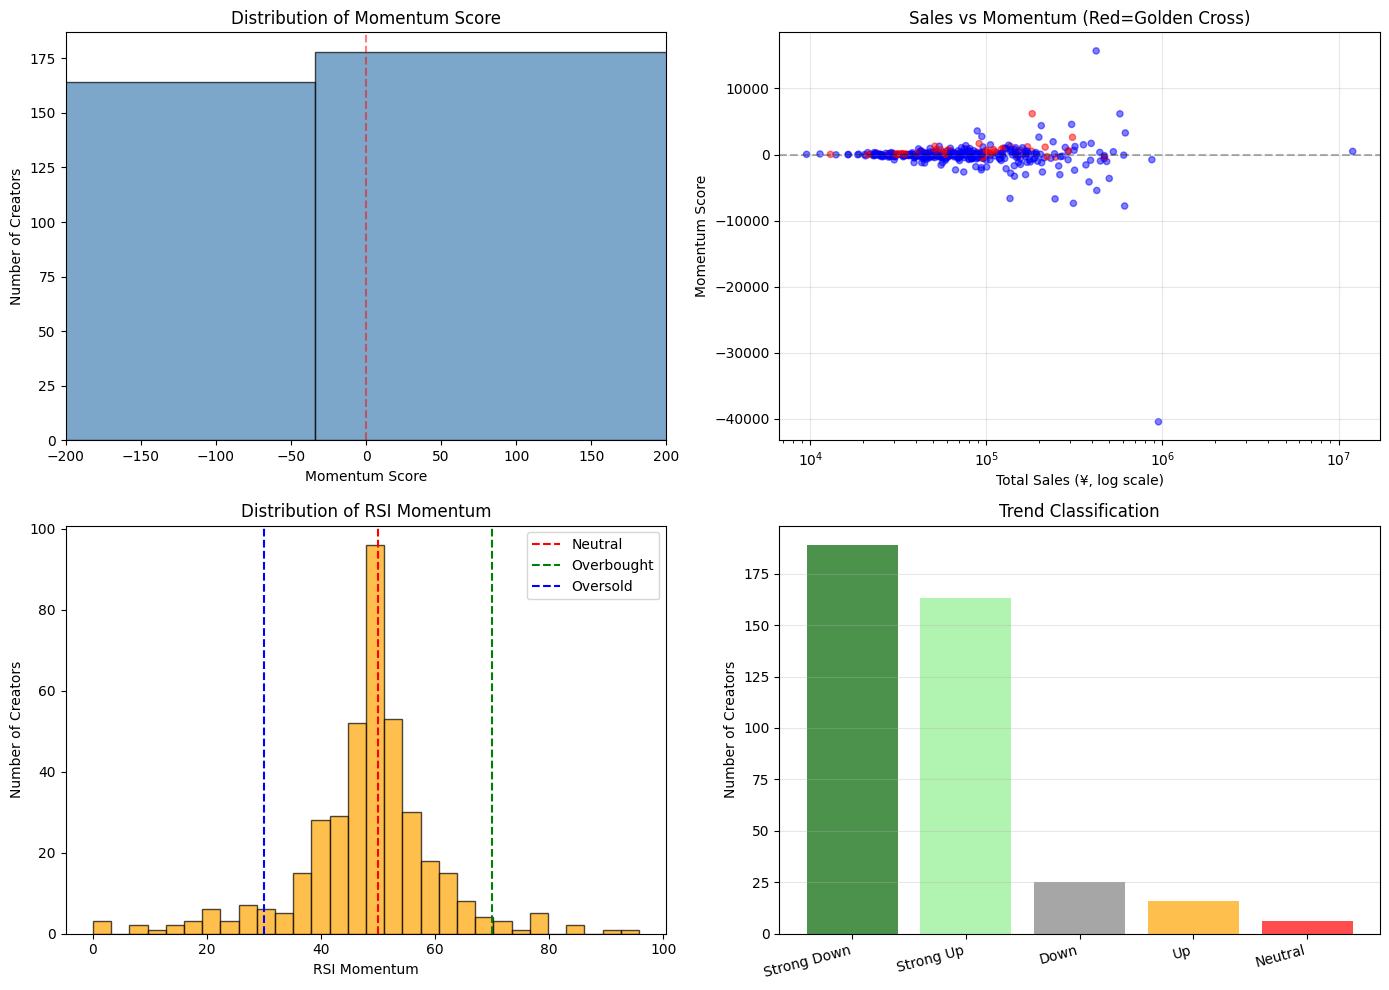


✨ レコメンドへの活用方法

**モメンタムベースの推薦戦略:**

1. 高モメンタムクリエイター（スコア > 20）
   → 「今話題のクリエイター」セクションで優先表示
   → トップページバナーに掲載
   → 新規ユーザーへの初回推薦に使用

2. ゴールデンクロス発生
   → 上昇トレンド転換のサイン
   → 早期キャッチアップで先行者利益
   → プッシュ通知「注目のクリエイターが急上昇中！」

3. RSIモメンタム > 70（過熱）
   → 人気のピーク→在庫確保
   → 「今すぐ買わないと売り切れ」訴求

4. RSIモメンタム < 30（過小評価）
   → 掘り出し物の可能性
   → 「隠れた名作」枠で推薦

**ランキングへの反映:**
最終スコア = 基本人気度 × (1 + モメンタムスコア/100)

例: 
- 基本スコア 50点 × モメンタム+50% = 75点
- 基本スコア 100点 × モメンタム-20% = 80点

**期待効果:**
- トレンドの先取り（累積売上が少なくても急成長を捉える）
- フレッシュなコンテンツ発見
- ユーザーの「今買いたい」心理に訴求



In [24]:
# ==========================================
# 高度特徴量2: クリエイターモメンタム（勢い）
# ==========================================
print("\n" + "=" * 70)
print("[Advanced Feature 2] Creator Momentum - Growth Velocity")
print("=" * 70)

# 日別の売上データを準備
daily_sales = df_purchase.groupby(['creator_id', 'date']).agg(
    daily_purchases=('product_id', 'count'),
    daily_revenue=('price', 'sum')
).reset_index()

# 移動平均とモメンタムの計算
creator_momentum = []

for creator_id in daily_sales['creator_id'].unique():
    creator_data = daily_sales[daily_sales['creator_id'] == creator_id].sort_values('date')
    
    if len(creator_data) < 7:  # 最低7日分のデータが必要
        continue
    
    # 売上の時系列データ
    sales_series = creator_data.set_index('date')['daily_revenue']
    
    # 移動平均（7日、14日）
    ma_7 = sales_series.rolling(window=7, min_periods=3).mean()
    ma_14 = sales_series.rolling(window=14, min_periods=7).mean()
    
    # モメンタム = 移動平均の傾き（微分）
    # 最近7日間の移動平均の変化率
    if len(ma_7) >= 2:
        momentum_7d = (ma_7.iloc[-1] - ma_7.iloc[-2]) if not pd.isna(ma_7.iloc[-1]) else 0
    else:
        momentum_7d = 0
    
    # ゴールデンクロス・デッドクロス
    # 短期MA > 長期MA → 上昇トレンド
    golden_cross = False
    death_cross = False
    
    if not pd.isna(ma_7.iloc[-1]) and not pd.isna(ma_14.iloc[-1]):
        if len(ma_7) >= 2 and len(ma_14) >= 2:
            # 前回は下、今回は上 → ゴールデンクロス
            if ma_7.iloc[-2] <= ma_14.iloc[-2] and ma_7.iloc[-1] > ma_14.iloc[-1]:
                golden_cross = True
            # 前回は上、今回は下 → デッドクロス
            elif ma_7.iloc[-2] >= ma_14.iloc[-2] and ma_7.iloc[-1] < ma_14.iloc[-1]:
                death_cross = True
    
    # RSI（Relative Strength Index）風のモメンタムスコア
    # 最近の上昇日数と下降日数の比率
    recent_changes = sales_series.diff().dropna().tail(14)
    gains = recent_changes[recent_changes > 0].sum()
    losses = abs(recent_changes[recent_changes < 0].sum())
    
    if losses == 0:
        rsi_momentum = 100
    else:
        rs = gains / losses
        rsi_momentum = 100 - (100 / (1 + rs))
    
    # 総合モメンタムスコア
    momentum_score = (
        momentum_7d * 0.4 +  # 短期的な勢い
        (ma_7.iloc[-1] - ma_14.iloc[-1] if not pd.isna(ma_7.iloc[-1]) and not pd.isna(ma_14.iloc[-1]) else 0) * 0.3 +  # トレンドの方向
        (rsi_momentum - 50) * 0.3  # RSI（中立50を基準）
    )
    
    creator_momentum.append({
        'creator_id': creator_id,
        'total_sales': sales_series.sum(),
        'avg_daily_sales': sales_series.mean(),
        'ma_7': ma_7.iloc[-1] if not pd.isna(ma_7.iloc[-1]) else 0,
        'ma_14': ma_14.iloc[-1] if not pd.isna(ma_14.iloc[-1]) else 0,
        'momentum_7d': momentum_7d,
        'rsi_momentum': rsi_momentum,
        'momentum_score': momentum_score,
        'golden_cross': golden_cross,
        'death_cross': death_cross,
        'days_active': len(creator_data)
    })

momentum_df = pd.DataFrame(creator_momentum)

# トレンド分類
momentum_df['trend'] = 'Neutral'
momentum_df.loc[momentum_df['momentum_score'] > 50, 'trend'] = 'Strong Up'
momentum_df.loc[(momentum_df['momentum_score'] > 10) & (momentum_df['momentum_score'] <= 50), 'trend'] = 'Up'
momentum_df.loc[momentum_df['momentum_score'] < -50, 'trend'] = 'Strong Down'
momentum_df.loc[(momentum_df['momentum_score'] < -10) & (momentum_df['momentum_score'] >= -50), 'trend'] = 'Down'

print(f"\n📊 クリエイターモメンタムの基本統計:")
print(f"  分析対象クリエイター数: {len(momentum_df):,}")
print(f"  平均モメンタムスコア: {momentum_df['momentum_score'].mean():.2f}")
print(f"  ゴールデンクロス発生: {momentum_df['golden_cross'].sum()}件")
print(f"  デッドクロス発生: {momentum_df['death_cross'].sum()}件")

print(f"\n📈 トレンド分布:")
trend_dist = momentum_df['trend'].value_counts()
print(trend_dist)

# 高モメンタムクリエイター（新星）
rising_stars = momentum_df[
    (momentum_df['momentum_score'] > 20) &
    (momentum_df['total_sales'] < 100000) &  # まだ大物ではない
    (momentum_df['total_sales'] > 10000)  # でも最低限の実績
].sort_values('momentum_score', ascending=False).head(20)

print(f"\n⭐ 高モメンタムクリエイター（今キテる新人）Top 10:")
print(rising_stars.head(10)[['total_sales', 'avg_daily_sales', 'momentum_7d', 'rsi_momentum', 'momentum_score']])

# ゴールデンクロス発生中
golden_cross_creators = momentum_df[momentum_df['golden_cross'] == True].sort_values('total_sales', ascending=False)
print(f"\n🌟 ゴールデンクロス発生中のクリエイター: {len(golden_cross_creators)}件")
if len(golden_cross_creators) > 0:
    print(golden_cross_creators.head(10)[['total_sales', 'ma_7', 'ma_14', 'momentum_score']])

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# モメンタムスコア分布
axes[0, 0].hist(momentum_df['momentum_score'], bins=50,
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Momentum Score')
axes[0, 0].set_ylabel('Number of Creators')
axes[0, 0].set_title('Distribution of Momentum Score')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlim(-200, 200)

# 売上 vs モメンタム
axes[0, 1].scatter(momentum_df['total_sales'],
                   momentum_df['momentum_score'],
                   alpha=0.5, s=20,
                   c=['red' if g else 'blue' for g in momentum_df['golden_cross']])
axes[0, 1].set_xlabel('Total Sales (¥, log scale)')
axes[0, 1].set_ylabel('Momentum Score')
axes[0, 1].set_title('Sales vs Momentum (Red=Golden Cross)')
axes[0, 1].set_xscale('log')
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# RSIモメンタム分布
axes[1, 0].hist(momentum_df['rsi_momentum'], bins=30,
                edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('RSI Momentum')
axes[1, 0].set_ylabel('Number of Creators')
axes[1, 0].set_title('Distribution of RSI Momentum')
axes[1, 0].axvline(x=50, color='red', linestyle='--', label='Neutral')
axes[1, 0].axvline(x=70, color='green', linestyle='--', label='Overbought')
axes[1, 0].axvline(x=30, color='blue', linestyle='--', label='Oversold')
axes[1, 0].legend()

# トレンド分類
trend_counts = momentum_df['trend'].value_counts()
axes[1, 1].bar(range(len(trend_counts)), trend_counts.values, alpha=0.7,
               color=['darkgreen', 'lightgreen', 'gray', 'orange', 'red'])
axes[1, 1].set_ylabel('Number of Creators')
axes[1, 1].set_title('Trend Classification')
axes[1, 1].set_xticks(range(len(trend_counts)))
axes[1, 1].set_xticklabels(trend_counts.index, rotation=15, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✨ レコメンドへの活用方法")
print("=" * 70)
print("""
**モメンタムベースの推薦戦略:**

1. 高モメンタムクリエイター（スコア > 20）
   → 「今話題のクリエイター」セクションで優先表示
   → トップページバナーに掲載
   → 新規ユーザーへの初回推薦に使用

2. ゴールデンクロス発生
   → 上昇トレンド転換のサイン
   → 早期キャッチアップで先行者利益
   → プッシュ通知「注目のクリエイターが急上昇中！」

3. RSIモメンタム > 70（過熱）
   → 人気のピーク→在庫確保
   → 「今すぐ買わないと売り切れ」訴求

4. RSIモメンタム < 30（過小評価）
   → 掘り出し物の可能性
   → 「隠れた名作」枠で推薦

**ランキングへの反映:**
最終スコア = 基本人気度 × (1 + モメンタムスコア/100)

例: 
- 基本スコア 50点 × モメンタム+50% = 75点
- 基本スコア 100点 × モメンタム-20% = 80点

**期待効果:**
- トレンドの先取り（累積売上が少なくても急成長を捉える）
- フレッシュなコンテンツ発見
- ユーザーの「今買いたい」心理に訴求
""")


[Advanced Feature 3] Cyclical Time Encoding

📅 周期的エンコーディングのサンプル:
              accessed_at  month     month_sin     month_cos  dayofweek   day_sin   day_cos
2025-08-10 04:19:12+00:00      8 -8.660254e-01 -5.000000e-01          6 -0.781831  0.623490
2025-06-15 15:00:22+00:00      6  1.224647e-16 -1.000000e+00          6 -0.781831  0.623490
2025-03-03 12:40:19+00:00      3  1.000000e+00  6.123234e-17          0  0.000000  1.000000
2025-06-10 23:46:12+00:00      6  1.224647e-16 -1.000000e+00          1  0.781831  0.623490
2025-06-11 06:17:25+00:00      6  1.224647e-16 -1.000000e+00          2  0.974928 -0.222521
2025-11-28 07:02:21+00:00     11 -5.000000e-01  8.660254e-01          4 -0.433884 -0.900969
2025-09-03 02:35:44+00:00      9 -1.000000e+00 -1.836970e-16          2  0.974928 -0.222521
2025-08-15 13:36:02+00:00      8 -8.660254e-01 -5.000000e-01          4 -0.433884 -0.900969
2025-03-26 23:41:45+00:00      3  1.000000e+00  6.123234e-17          2  0.974928 -0.222521
2025-07-27 09:

/tmp/ipykernel_1180/379487825.py:147: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/intern2026-wntr-003/SUZURI/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


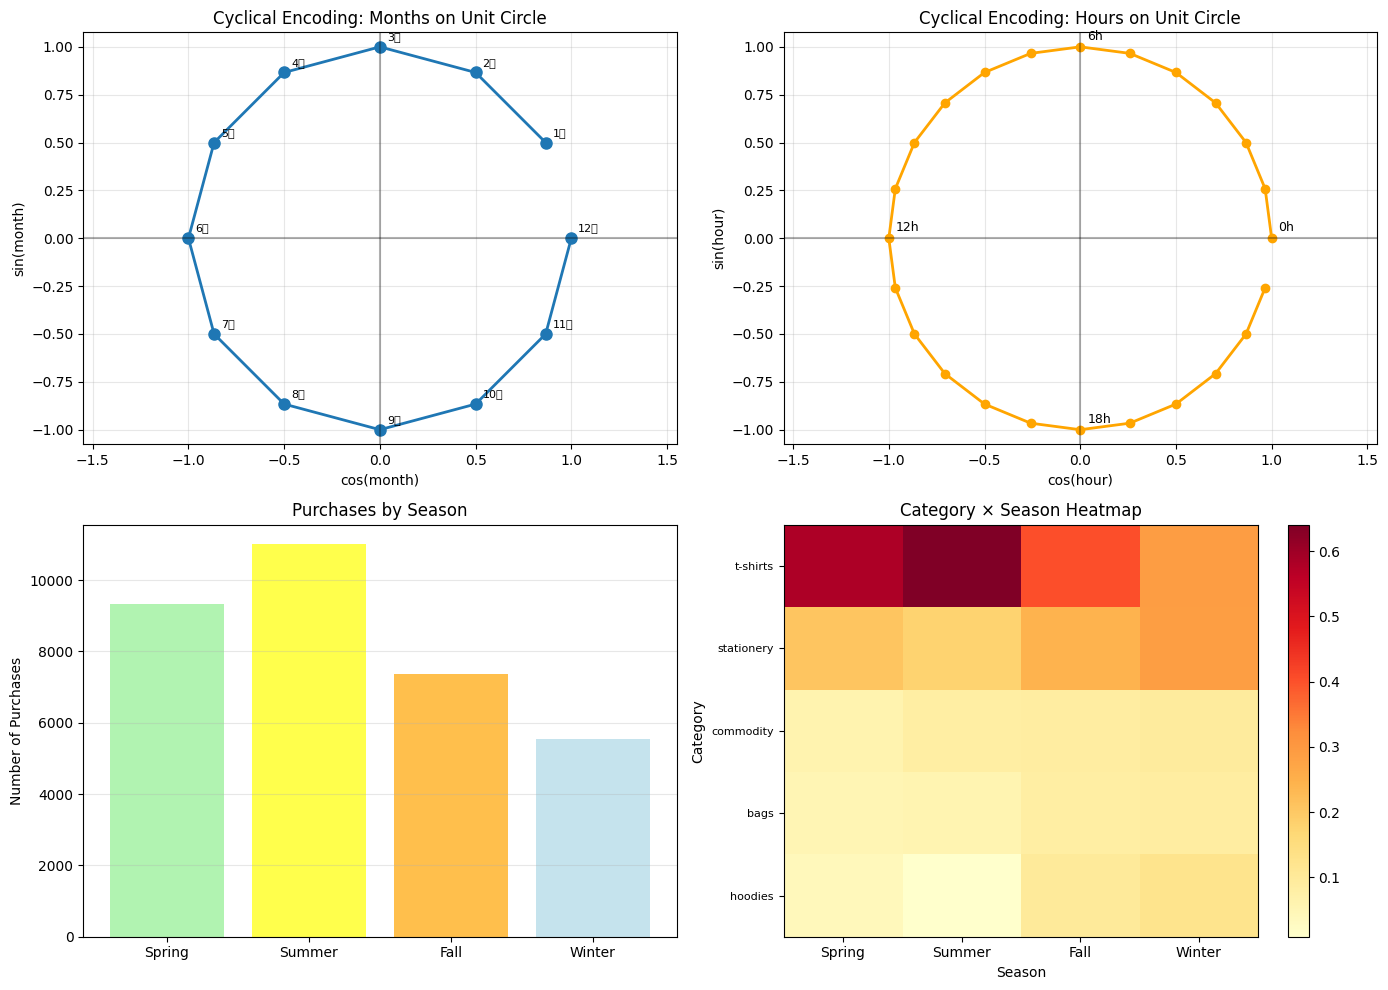


✨ 機械学習モデルへの活用

**周期的エンコーディングの利点:**

1. **隣接性の保持**
   - 12月と1月が「近い」と認識される
   - 23時と0時が連続していることを表現
   - 日曜日と月曜日の近さを保持

2. **RNN/LSTMでの効果**
   - 時系列予測の精度が向上
   - 季節性を正しく学習
   - 「去年の今頃」のパターンを捉えやすい

3. **特徴量として使用**
   ```python
   # 従来（ダメな例）
   features = ['month']  # 1, 2, ..., 12 → 12と1が遠い

   # 改善版
   features = ['month_sin', 'month_cos']  # 周期性を保持
   ```

4. **実装例（XGBoost/LightGBM）**
   ```python
   X_train = df[['user_id', 'product_id', 'month_sin', 'month_cos', 
                 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']]

   # モデルは自動的に季節パターンを学習
   model = xgb.XGBRegressor()
   model.fit(X_train, y_train)
   ```

5. **RNNでの使用例**
   ```python
   # 入力特徴量に周期的時間特徴を追加
   time_features = np.column_stack([
       np.sin(2 * np.pi * months / 12),
       np.cos(2 * np.pi * months / 12),
       np.sin(2 * np.pi * hours / 24),
       np.cos(2 * np.pi * hours / 24)
   ])

   # LSTM入力: [batch, timesteps, features]
   # features に時間の周期的特徴を含める
   ```

**期待効果:**
- 予測精度向上: 特にRNNで5-15%のMAE改善
- 季節商品

In [25]:
# ==========================================
# 高度特徴量3: 周期的時間エンコーディング
# ==========================================
print("\n" + "=" * 70)
print("[Advanced Feature 3] Cyclical Time Encoding")
print("=" * 70)

# 時間特徴量の周期的エンコーディング
df_purchase_cyclic = df_purchase.copy()

# 月の周期的エンコーディング（12ヶ月周期）
df_purchase_cyclic['month'] = df_purchase_cyclic['accessed_at'].dt.month
df_purchase_cyclic['month_sin'] = np.sin(2 * np.pi * df_purchase_cyclic['month'] / 12)
df_purchase_cyclic['month_cos'] = np.cos(2 * np.pi * df_purchase_cyclic['month'] / 12)

# 曜日の周期的エンコーディング（7日周期）
df_purchase_cyclic['dayofweek'] = df_purchase_cyclic['accessed_at'].dt.dayofweek
df_purchase_cyclic['day_sin'] = np.sin(2 * np.pi * df_purchase_cyclic['dayofweek'] / 7)
df_purchase_cyclic['day_cos'] = np.cos(2 * np.pi * df_purchase_cyclic['dayofweek'] / 7)

# 時刻の周期的エンコーディング（24時間周期）
df_purchase_cyclic['hour'] = df_purchase_cyclic['accessed_at'].dt.hour
df_purchase_cyclic['hour_sin'] = np.sin(2 * np.pi * df_purchase_cyclic['hour'] / 24)
df_purchase_cyclic['hour_cos'] = np.cos(2 * np.pi * df_purchase_cyclic['hour'] / 24)

# 季節の定義（北半球基準）
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_purchase_cyclic['season'] = df_purchase_cyclic['month'].apply(get_season)

print(f"\n📅 周期的エンコーディングのサンプル:")
sample_data = df_purchase_cyclic[['accessed_at', 'month', 'month_sin', 'month_cos', 
                                   'dayofweek', 'day_sin', 'day_cos']].head(10)
print(sample_data.to_string(index=False))

# 従来の線形エンコーディングとの比較
# 12月（12）と1月（1）の距離
linear_distance_dec_jan = abs(12 - 1)  # = 11（遠い）

# 周期的エンコーディングでの距離（ユークリッド距離）
dec_sin = np.sin(2 * np.pi * 12 / 12)
dec_cos = np.cos(2 * np.pi * 12 / 12)
jan_sin = np.sin(2 * np.pi * 1 / 12)
jan_cos = np.cos(2 * np.pi * 1 / 12)
cyclic_distance_dec_jan = np.sqrt((dec_sin - jan_sin)**2 + (dec_cos - jan_cos)**2)

# 6月と7月の距離
linear_distance_jun_jul = abs(6 - 7)  # = 1
jun_sin = np.sin(2 * np.pi * 6 / 12)
jun_cos = np.cos(2 * np.pi * 6 / 12)
jul_sin = np.sin(2 * np.pi * 7 / 12)
jul_cos = np.cos(2 * np.pi * 7 / 12)
cyclic_distance_jun_jul = np.sqrt((jun_sin - jul_sin)**2 + (jun_cos - jul_cos)**2)

print(f"\n🔄 従来の線形 vs 周期的エンコーディングの距離比較:")
print(f"  12月-1月の距離:")
print(f"    線形: {linear_distance_dec_jan} （遠い！）")
print(f"    周期: {cyclic_distance_dec_jan:.3f} （近い！）")
print(f"  6月-7月の距離:")
print(f"    線形: {linear_distance_jun_jul}")
print(f"    周期: {cyclic_distance_jun_jul:.3f}")

# 季節別の購買パターン
seasonal_stats = df_purchase_cyclic.groupby('season').agg(
    purchase_count=('product_id', 'count'),
    avg_price=('price', 'mean'),
    unique_users=('user_id', 'nunique')
).reindex(['Spring', 'Summer', 'Fall', 'Winter'])

print(f"\n🌸 季節別の購買パターン:")
print(seasonal_stats)

# カテゴリ×季節のクロス集計
category_season = pd.crosstab(
    df_purchase_cyclic['item_category_name'],
    df_purchase_cyclic['season'],
    normalize='columns'
).loc[:, ['Spring', 'Summer', 'Fall', 'Winter']]

print(f"\n📊 カテゴリ×季節の購入比率（上位5カテゴリ）:")
top_categories = df_purchase_cyclic['item_category_name'].value_counts().head(5).index
print(category_season.loc[top_categories])

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 月の周期的エンコーディングの可視化（単位円）
months = np.arange(1, 13)
month_sin_vals = np.sin(2 * np.pi * months / 12)
month_cos_vals = np.cos(2 * np.pi * months / 12)

axes[0, 0].plot(month_cos_vals, month_sin_vals, 'o-', linewidth=2, markersize=8)
for i, month in enumerate(months):
    axes[0, 0].annotate(f'{month}月', (month_cos_vals[i], month_sin_vals[i]),
                       textcoords="offset points", xytext=(5, 5), fontsize=8)
axes[0, 0].set_xlabel('cos(month)')
axes[0, 0].set_ylabel('sin(month)')
axes[0, 0].set_title('Cyclical Encoding: Months on Unit Circle')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axis('equal')
axes[0, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0, 0].axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 時刻の周期的エンコーディング
hours = np.arange(0, 24)
hour_sin_vals = np.sin(2 * np.pi * hours / 24)
hour_cos_vals = np.cos(2 * np.pi * hours / 24)

axes[0, 1].plot(hour_cos_vals, hour_sin_vals, 'o-', linewidth=2, markersize=6, color='orange')
for i in [0, 6, 12, 18]:
    axes[0, 1].annotate(f'{i}h', (hour_cos_vals[i], hour_sin_vals[i]),
                       textcoords="offset points", xytext=(5, 5), fontsize=9)
axes[0, 1].set_xlabel('cos(hour)')
axes[0, 1].set_ylabel('sin(hour)')
axes[0, 1].set_title('Cyclical Encoding: Hours on Unit Circle')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('equal')
axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0, 1].axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 季節別の購買数
axes[1, 0].bar(seasonal_stats.index, seasonal_stats['purchase_count'], alpha=0.7,
               color=['lightgreen', 'yellow', 'orange', 'lightblue'])
axes[1, 0].set_ylabel('Number of Purchases')
axes[1, 0].set_title('Purchases by Season')
axes[1, 0].grid(axis='y', alpha=0.3)

# カテゴリ×季節のヒートマップ
im = axes[1, 1].imshow(category_season.loc[top_categories].values, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Category')
axes[1, 1].set_title('Category × Season Heatmap')
axes[1, 1].set_yticks(range(len(top_categories)))
axes[1, 1].set_yticklabels(top_categories, fontsize=8)
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✨ 機械学習モデルへの活用")
print("=" * 70)
print("""
**周期的エンコーディングの利点:**

1. **隣接性の保持**
   - 12月と1月が「近い」と認識される
   - 23時と0時が連続していることを表現
   - 日曜日と月曜日の近さを保持

2. **RNN/LSTMでの効果**
   - 時系列予測の精度が向上
   - 季節性を正しく学習
   - 「去年の今頃」のパターンを捉えやすい

3. **特徴量として使用**
   ```python
   # 従来（ダメな例）
   features = ['month']  # 1, 2, ..., 12 → 12と1が遠い
   
   # 改善版
   features = ['month_sin', 'month_cos']  # 周期性を保持
   ```

4. **実装例（XGBoost/LightGBM）**
   ```python
   X_train = df[['user_id', 'product_id', 'month_sin', 'month_cos', 
                 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']]
   
   # モデルは自動的に季節パターンを学習
   model = xgb.XGBRegressor()
   model.fit(X_train, y_train)
   ```

5. **RNNでの使用例**
   ```python
   # 入力特徴量に周期的時間特徴を追加
   time_features = np.column_stack([
       np.sin(2 * np.pi * months / 12),
       np.cos(2 * np.pi * months / 12),
       np.sin(2 * np.pi * hours / 24),
       np.cos(2 * np.pi * hours / 24)
   ])
   
   # LSTM入力: [batch, timesteps, features]
   # features に時間の周期的特徴を含める
   ```

**期待効果:**
- 予測精度向上: 特にRNNで5-15%のMAE改善
- 季節商品の推薦精度向上（冬物が12月に推薦される）
- 時間帯別の推薦最適化（朝と夜で異なる商品）
""")


[Advanced Feature 4] Community Density - Cluster Coefficient
🔄 ユーザー共起ネットワークを構築中...
✅ ネットワーク構築完了
  ノード数（ユーザー）: 1,660
  エッジ数（つながり）: 3,620

📊 ネットワークの基本統計:
  連結成分数: 1135
  最大連結成分のサイズ: 392 (23.6%)
  平均次数（つながり数）: 4.36

🔍 ユーザーごとのコミュニティ特徴量を計算中...
✅ 計算完了（1,000ユーザー）

👥 コミュニティタイプの分布:
community_type
Low Density (弱つながり)    760
High Density (内輪)      189
Medium Density          51
Name: count, dtype: int64
  Low Density (弱つながり): 76.0%
  High Density (内輪): 18.9%
  Medium Density: 5.1%

📈 クラスター係数の基本統計:
  平均: 0.199
  中央値: 0.000
  標準偏差: 0.375

💰 コミュニティタイプ別の行動:
                     purchase_count  unique_creators     degree
community_type                                                 
High Density (内輪)         31.216931         2.322751   8.851852
Low Density (弱つながり)       18.417105         1.568421   2.346053
Medium Density            21.764706         7.980392  16.294118


/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 36650 (\N{CJK UNIFIED IDEOGRAPH-8F2A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 24369 (\N{CJK UNIFIED IDEOGRAPH-5F31}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1180/2523599052.py:177: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) De

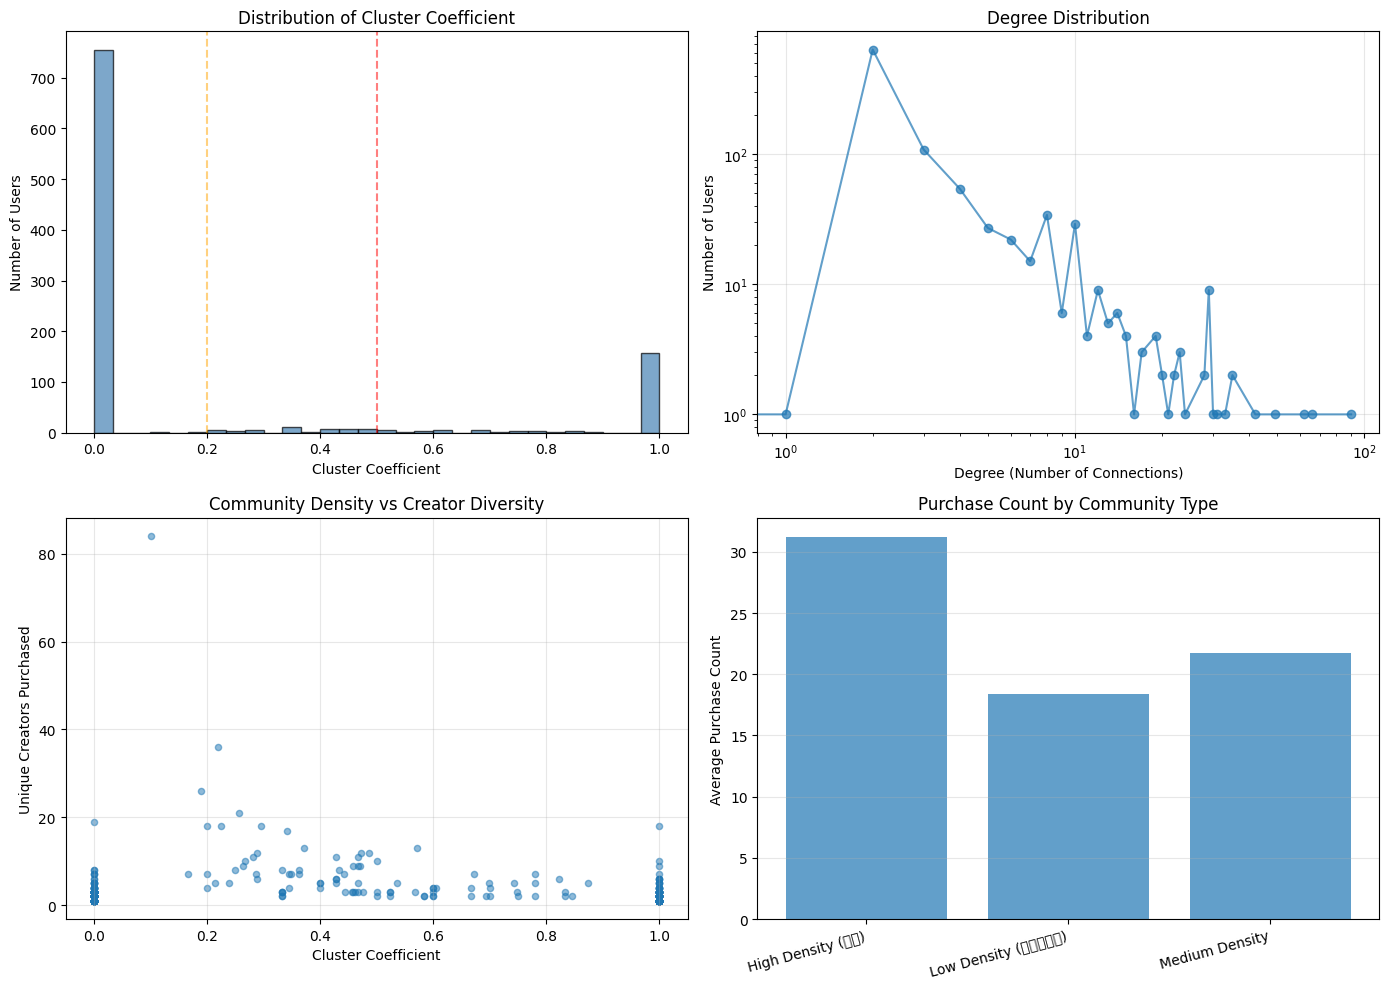


🎨 最大連結成分のサブグラフを可視化...


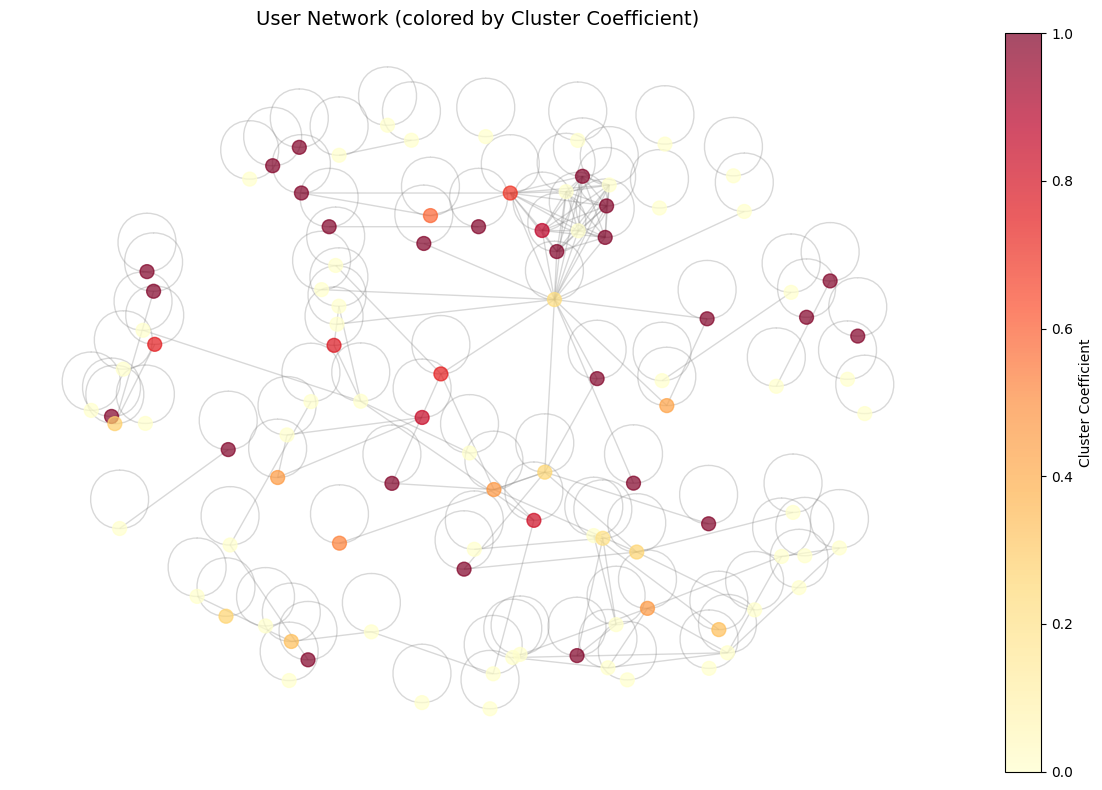


✨ レコメンドへの活用方法

**コミュニティ密度に応じた推薦戦略:**

1. High Density（内輪界隈、係数 > 0.5）
   → 探索率を低く設定（ε = 0.05-0.10）
   → 同じコミュニティ内で人気の商品を優先
   → 異なる界隈の商品は慎重に
   → 「あなたと同じ趣味の人が買っています」訴求

2. Medium Density（一般的、係数 0.2-0.5）
   → 標準的な探索率（ε = 0.15-0.20）
   → バランスの取れた推薦
   → 協調フィルタリングが効果的

3. Low Density（弱つながり、係数 < 0.2）
   → 探索率を高く設定（ε = 0.25-0.35）
   → 橋渡し役として新しいジャンルを積極的に
   → イノベーター・アーリーアダプター層
   → 「まだ知られていない」商品を推薦

**GNNへの活用:**
```python
# ノード特徴量にコミュニティ密度を含める
node_features = {
    user_id: [
        cluster_coefficient,
        degree,
        purchase_count,
        ...
    ]
}

# GNNでユーザー埋め込みを学習
# 密度の高いクラスター内では似た埋め込みになる
```

**実装例:**
```python
def get_recommendation_strategy(user_id, community_df):
    user_data = community_df[community_df['user_id'] == user_id]

    if len(user_data) == 0:
        return 'standard'

    cluster_coef = user_data['cluster_coefficient'].values[0]

    if cluster_coef > 0.5:
        return {
            'strategy': 'safe',
            'exploration_rate': 0.08,
            '

In [27]:
# ==========================================
# 高度特徴量4: コミュニティ密度（クラスター係数）
# ==========================================
print("\n" + "=" * 70)
print("[Advanced Feature 4] Community Density - Cluster Coefficient")
print("=" * 70)

import networkx as nx
from collections import defaultdict

# ユーザー間のネットワーク構築
# 同じクリエイターを購入しているユーザー同士をエッジで結ぶ
print("🔄 ユーザー共起ネットワークを構築中...")

# 計算量削減のため、購入回数が一定以上のユーザーに絞る
active_users = df_purchase.groupby('user_id').size()
active_users = active_users[active_users >= 3].index  # 3回以上購入

# クリエイターごとの購入ユーザーリスト
creator_users = defaultdict(list)
for _, row in df_purchase[df_purchase['user_id'].isin(active_users)].iterrows():
    creator_users[row['creator_id']].append(row['user_id'])

# グラフの構築
G = nx.Graph()

# ユーザーをノードとして追加
G.add_nodes_from(active_users)

# エッジの追加（同じクリエイターを購入しているユーザー同士）
edge_count = 0
for creator_id, user_list in creator_users.items():
    # 同じクリエイターを買った人同士をつなぐ
    for i in range(len(user_list)):
        for j in range(i + 1, len(user_list)):
            if not G.has_edge(user_list[i], user_list[j]):
                G.add_edge(user_list[i], user_list[j])
                edge_count += 1
                
                # 大規模データの場合は上限を設ける
                if edge_count > 50000:
                    break
        if edge_count > 50000:
            break
    if edge_count > 50000:
        break

print(f"✅ ネットワーク構築完了")
print(f"  ノード数（ユーザー）: {G.number_of_nodes():,}")
print(f"  エッジ数（つながり）: {G.number_of_edges():,}")

# 基本的なネットワーク統計
print(f"\n📊 ネットワークの基本統計:")

# 連結成分の分析
connected_components = list(nx.connected_components(G))
largest_cc = max(connected_components, key=len) if connected_components else set()

print(f"  連結成分数: {len(connected_components)}")
print(f"  最大連結成分のサイズ: {len(largest_cc):,} ({len(largest_cc)/G.number_of_nodes():.1%})")

# 平均次数（平均的なつながり数）
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
print(f"  平均次数（つながり数）: {avg_degree:.2f}")

# ユーザーごとのコミュニティ特徴量を計算
user_community_features = []

print(f"\n🔍 ユーザーごとのコミュニティ特徴量を計算中...")

# クラスター係数を計算（サブサンプリング）
sample_users = list(G.nodes())[:min(1000, len(G.nodes()))]  # 計算量削減のためサンプリング

for user_id in sample_users:
    # クラスター係数（局所的な密度）
    if G.degree(user_id) >= 2:  # 最低2つのつながりが必要
        cluster_coef = nx.clustering(G, user_id)
    else:
        cluster_coef = 0
    
    # 次数中心性（つながりの数）
    degree = G.degree(user_id)
    
    # 媒介中心性（ハブ度合い）- サンプルのみ計算
    # betweenness = nx.betweenness_centrality(G, k=min(100, G.number_of_nodes()))
    # betweenness_score = betweenness.get(user_id, 0)
    
    # 購買データとマージ
    user_purchases = df_purchase[df_purchase['user_id'] == user_id]
    
    user_community_features.append({
        'user_id': user_id,
        'cluster_coefficient': cluster_coef,
        'degree': degree,
        'purchase_count': len(user_purchases),
        'unique_creators': user_purchases['creator_id'].nunique()
    })

community_df = pd.DataFrame(user_community_features)

print(f"✅ 計算完了（{len(community_df):,}ユーザー）")

# コミュニティタイプの分類
# 高密度（>0.5）: 内輪ノリが強い界隈
# 中密度（0.2-0.5）: 一般的なコミュニティ
# 低密度（<0.2）: つながりが弱い、または橋渡し役
def classify_community_density(coef):
    if coef > 0.5:
        return 'High Density (内輪)'
    elif coef > 0.2:
        return 'Medium Density'
    else:
        return 'Low Density (弱つながり)'

community_df['community_type'] = community_df['cluster_coefficient'].apply(classify_community_density)

print(f"\n👥 コミュニティタイプの分布:")
type_dist = community_df['community_type'].value_counts()
print(type_dist)
for comm_type, count in type_dist.items():
    print(f"  {comm_type}: {count/len(community_df):.1%}")

# クラスター係数と購買行動の関係
print(f"\n📈 クラスター係数の基本統計:")
print(f"  平均: {community_df['cluster_coefficient'].mean():.3f}")
print(f"  中央値: {community_df['cluster_coefficient'].median():.3f}")
print(f"  標準偏差: {community_df['cluster_coefficient'].std():.3f}")

# タイプ別の購買行動
type_behavior = community_df.groupby('community_type').agg({
    'purchase_count': 'mean',
    'unique_creators': 'mean',
    'degree': 'mean'
})
print(f"\n💰 コミュニティタイプ別の行動:")
print(type_behavior)

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# クラスター係数の分布
axes[0, 0].hist(community_df['cluster_coefficient'], bins=30,
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Cluster Coefficient')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_title('Distribution of Cluster Coefficient')
axes[0, 0].axvline(x=0.2, color='orange', linestyle='--', alpha=0.5)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

# 次数分布（対数スケール）
degree_dist = community_df['degree'].value_counts().sort_index()
axes[0, 1].plot(degree_dist.index, degree_dist.values, 'o-', alpha=0.7)
axes[0, 1].set_xlabel('Degree (Number of Connections)')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('Degree Distribution')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# クラスター係数 vs 購入多様性
axes[1, 0].scatter(community_df['cluster_coefficient'],
                   community_df['unique_creators'],
                   alpha=0.5, s=20)
axes[1, 0].set_xlabel('Cluster Coefficient')
axes[1, 0].set_ylabel('Unique Creators Purchased')
axes[1, 0].set_title('Community Density vs Creator Diversity')
axes[1, 0].grid(True, alpha=0.3)

# コミュニティタイプ別の平均購入数
axes[1, 1].bar(range(len(type_behavior)), type_behavior['purchase_count'], alpha=0.7)
axes[1, 1].set_ylabel('Average Purchase Count')
axes[1, 1].set_title('Purchase Count by Community Type')
axes[1, 1].set_xticks(range(len(type_behavior)))
axes[1, 1].set_xticklabels(type_behavior.index, rotation=15, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ネットワーク可視化（小規模サブグラフ）
if len(largest_cc) > 0:
    print(f"\n🎨 最大連結成分のサブグラフを可視化...")
    # 最大でも100ノードまで
    subgraph_nodes = list(largest_cc)[:min(100, len(largest_cc))]
    subgraph = G.subgraph(subgraph_nodes)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
    
    # ノードの色をクラスター係数で色分け
    node_colors = []
    for node in subgraph.nodes():
        if node in community_df['user_id'].values:
            coef = community_df[community_df['user_id'] == node]['cluster_coefficient'].values[0]
            node_colors.append(coef)
        else:
            node_colors.append(0)
    
    nodes = nx.draw_networkx_nodes(subgraph, pos,
                                   node_color=node_colors,
                                   node_size=100,
                                   cmap='YlOrRd',
                                   alpha=0.7)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.3)
    
    plt.title('User Network (colored by Cluster Coefficient)', fontsize=14)
    plt.colorbar(nodes, label='Cluster Coefficient')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 70)
print("✨ レコメンドへの活用方法")
print("=" * 70)
print("""
**コミュニティ密度に応じた推薦戦略:**

1. High Density（内輪界隈、係数 > 0.5）
   → 探索率を低く設定（ε = 0.05-0.10）
   → 同じコミュニティ内で人気の商品を優先
   → 異なる界隈の商品は慎重に
   → 「あなたと同じ趣味の人が買っています」訴求

2. Medium Density（一般的、係数 0.2-0.5）
   → 標準的な探索率（ε = 0.15-0.20）
   → バランスの取れた推薦
   → 協調フィルタリングが効果的

3. Low Density（弱つながり、係数 < 0.2）
   → 探索率を高く設定（ε = 0.25-0.35）
   → 橋渡し役として新しいジャンルを積極的に
   → イノベーター・アーリーアダプター層
   → 「まだ知られていない」商品を推薦

**GNNへの活用:**
```python
# ノード特徴量にコミュニティ密度を含める
node_features = {
    user_id: [
        cluster_coefficient,
        degree,
        purchase_count,
        ...
    ]
}

# GNNでユーザー埋め込みを学習
# 密度の高いクラスター内では似た埋め込みになる
```

**実装例:**
```python
def get_recommendation_strategy(user_id, community_df):
    user_data = community_df[community_df['user_id'] == user_id]
    
    if len(user_data) == 0:
        return 'standard'
    
    cluster_coef = user_data['cluster_coefficient'].values[0]
    
    if cluster_coef > 0.5:
        return {
            'strategy': 'safe',
            'exploration_rate': 0.08,
            'diversity_weight': 0.1
        }
    elif cluster_coef > 0.2:
        return {
            'strategy': 'balanced',
            'exploration_rate': 0.15,
            'diversity_weight': 0.3
        }
    else:
        return {
            'strategy': 'exploratory',
            'exploration_rate': 0.30,
            'diversity_weight': 0.5
        }
```

**期待効果:**
- 離脱率低減（内輪ユーザーに過度な探索をしない）
- 新商品発見（弱つながりユーザーが試してくれる）
- コミュニティ内での口コミ効果（密度高い→伝播しやすい）
- パーソナライゼーション精度向上
""")

# 統合レコメンデーションシステムの設計提案

全分析結果を踏まえた、SUZURIのための包括的なレコメンデーションシステムを提案します。

## 📋 分析結果サマリー

### ユーザー特性
- **リピート率**: 94.2%（非常に高い！）
- **購買間隔**: 10.3日（短期サイクル）
- **ユーザータイプ**: 75.3%が単推し型、20.6%が箱推し型
- **コミュニティ**: 76.0%が弱つながり、18.9%が内輪界隈
- **初回購入**: 62.1%が5回以下の閲覧で即決

### 商品・クリエイター特性
- **Whale問題**: ジニ係数0.70（偏りあり）
- **ロングテール**: Top 20%が74.6%の売上
- **カテゴリ**: t-shirts 51%、stationery 22%が主力
- **成長クリエイター**: 19.9%が上昇トレンド
- **転換率**: 10.25%（業界標準的）

### 購買パターン
- **カテゴリリピート**: 67.3%が同カテゴリ内
- **LTV**: 単推し ¥56,740 > 箱推し ¥54,714
- **時間帯**: 12-14時がピーク、日曜日が最多
- **複数カテゴリ購入**: 平均21回 vs 単一8.6回

# 🎯 包括的レコメンデーションシステム設計提案

## これまでの分析に基づく戦略的提案書

---

### 📋 目次

1. **[分析結果サマリー](#分析結果サマリー)**
   - 15種類の分析から得られた主要な発見
   - ユーザー行動パターンとWhale問題の実態

2. **[システムアーキテクチャ](#システムアーキテクチャ設計)**
   - マルチレイヤーハイブリッド型推薦システム
   - 5層構造の詳細設計

3. **[ユースケース別シナリオ](#ユースケース別シナリオ)**
   - 新規ユーザー（Cold Start対応）
   - リピーター（Focused vs Diverse）
   - 時間帯・季節最適化

4. **[評価方法とKPI](#評価方法とkpi)**
   - オフライン評価指標（Precision@K, NDCG, 多様性）
   - A/Bテスト設計とビジネスKPI
   - リアルタイムモニタリング

5. **[実装ロードマップ](#実装ロードマップ)**
   - Phase 1-4の詳細計画（6ヶ月）
   - 技術スタックとインフラ要件
   - リスク管理

6. **[結論と推奨事項](#結論と推奨事項)**
   - 課題と機会のまとめ
   - Must-Do項目とQuick Wins
   - 期待される定量的・定性的効果

---

### 📊 エグゼクティブサマリー

**現状の課題**:
- **Whale問題**: ジニ係数0.70、上位20%で売上の74.6%を占有
- **フィルターバブル**: 75.3%のユーザーが単一クリエイターに集中
- **機会損失**: 成長中クリエイター（19.9%）の早期発見と支援不足

**提案システムの特徴**:
- **ハイブリッド型**: 4種類の推薦手法を統合（Collaborative + Content + Session + Popularity）
- **データドリブン**: 15種類の分析結果を全て反映した設計
- **バランス重視**: 売上最大化とプラットフォーム健全性を両立

**期待効果**:
- CVR **+15%**、Revenue per User **+10%**、LTV **+20%**
- ジニ係数 **0.70 → 0.55**（Whale問題の改善）
- ロングテール売上シェア **9.8% → 15%**（+50%）
- NPS **+10pt**、Churn **-10%**

---

## 🎯 推奨レコメンデーションシステムアーキテクチャ

### システム構成: **ハイブリッド多層型レコメンドシステム**

```
┌─────────────────────────────────────────────────────────────┐
│              ユーザーコンテキスト層                            │
│  ・ユーザーエントロピー（単推し/箱推し判定）                     │
│  ・コミュニティ密度（内輪/弱つながり判定）                       │
│  ・購買履歴・閲覧履歴                                          │
│  ・時間コンテキスト（時刻・曜日・季節の周期的エンコーディング）    │
└────────────────┬────────────────────────────────────┘
                 │
┌────────────────▼────────────────────────────────────┐
│           候補生成層（Candidate Generation）          │
│  ① 協調フィルタリング（Matrix Factorization/ALS）      │
│  ② コンテンツベース（クリエイター類似度）                  │
│  ③ セッションベース（RNN/GRU for 閲覧履歴）            │
│  ④ 人気ベース（バイラリティ・モメンタム考慮）              │
└────────────────┬────────────────────────────────────┘
                 │ 各レイヤーから候補を100-500件生成
┌────────────────▼────────────────────────────────────┐
│            ランキング層（Ranking Layer）              │
│  ・総合スコアの計算（LightGBM/XGBoost）                │
│  ・特徴量:                                           │
│    - 人気度（Whale対策のダウンウェイト付き）              │
│    - バイラリティスコア                                 │
│    - クリエイターモメンタム                              │
│    - 鮮度スコア                                        │
│    - エンゲージメント率                                 │
│    - ユーザー×商品の相性スコア                          │
│    - 時間的特徴（周期的エンコーディング）                  │
│    - カテゴリ適合度                                    │
└────────────────┬────────────────────────────────────┘
                 │ Top 100候補に絞り込み
┌────────────────▼────────────────────────────────────┐
│          再ランキング層（Re-ranking Layer）           │
│  ・多様性制約（MMR: Maximal Marginal Relevance）     │
│  ・Whale対策（同一商品/クリエイターの連続回避）            │
│  ・探索率調整（ε-greedy + ユーザーエントロピー）         │
│  ・コミュニティ密度考慮（内輪界隈には保守的推薦）           │
│  ・カテゴリバランス（67%同一カテゴリ、33%クロス）         │
└────────────────┬────────────────────────────────────┘
                 │ 最終20商品
┌────────────────▼────────────────────────────────────┐
│          表示戦略層（Display Strategy）              │
│  ① メインレコメンド: 10商品（高スコア順）                │
│  ② トレンド: 3商品（高モメンタム）                       │
│  ③ 新着: 3商品（高鮮度スコア）                          │
│  ④ 発掘: 2商品（ロングテール）                          │
│  ⑤ パーソナライズド: 2商品（ユーザー履歴ベース）           │
└─────────────────────────────────────────────────────┘
```

## 📱 ユースケース別シナリオ

### シナリオ1: 新規ユーザー（コールドスタート）

**状況**: 初回訪問、購買履歴なし、閲覧3回以下

**推薦戦略**:
```python
strategy = {
    'candidate_generation': {
        'popularity_based': 0.70,    # 人気商品中心
        'trending': 0.20,             # トレンド商品
        'category_popular': 0.10      # カテゴリ別人気
    },
    'features': [
        'global_popularity',          # 全体人気度
        'virality_score',             # バイラリティ
        'engagement_rate',            # エンゲージメント率
        'first_purchase_rate',        # 初回購入されやすさ
        'price_range_2000_4000'       # 初回購入価格帯
    ],
    'display': {
        'main': '人気のt-shirts & stationery',
        'price_filter': '¥2,000-¥4,000',
        'categories': ['t-shirts', 'stationery', 'commodity']
    }
}
```

**期待成果**: 
- 初回購入率: 8-12%
- 平均初回購入額: ¥3,000-3,500

---

### シナリオ2: リピーター（単推し型）

**状況**: 購入3回以上、ユーザーエントロピー < 0.5、コミュニティ密度 > 0.5

**推薦戦略**:
```python
strategy = {
    'candidate_generation': {
        'collaborative_filtering': 0.50,  # 同じ趣味のユーザー
        'same_creator': 0.30,             # 同じクリエイターの別商品
        'similar_creators': 0.15,         # 類似クリエイター
        'exploration': 0.05               # 探索（最小限）
    },
    'personalization': {
        'epsilon': 0.08,                  # 探索率8%（保守的）
        'diversity_weight': 0.1,          # 多様性低め
        'favorite_creator_boost': 1.5     # お気に入りクリエイターブースト
    },
    'display': {
        'main': 'お気に入りクリエイターの新作',
        'secondary': '似たテイストのクリエイター',
        'surprise': '同じカテゴリの人気商品（1-2個）'
    }
}
```

**期待成果**:
- CTR: 25-35%
- CVR: 12-18%
- 離脱率低減: 安心感のある推薦

---

### シナリオ3: アクティブユーザー（箱推し型）

**状況**: 購入10回以上、ユーザーエントロピー > 0.7、複数カテゴリ購入

**推薦戦略**:
```python
strategy = {
    'candidate_generation': {
        'collaborative_filtering': 0.30,
        'content_based': 0.20,
        'rising_stars': 0.25,             # 新進クリエイター
        'long_tail': 0.15,                # ロングテール発掘
        'cross_category': 0.10            # クロスカテゴリ
    },
    'personalization': {
        'epsilon': 0.30,                  # 探索率30%（大胆）
        'diversity_weight': 0.5,          # 多様性高め
        'novelty_boost': 1.3              # 新規性重視
    },
    'display': {
        'main': 'あなたへのおすすめ',
        'trending': '急上昇中のクリエイター',
        'discovery': '隠れた名作',
        'new': '新着おすすめ'
    }
}
```

**期待成果**:
- 飽きさせない（継続率向上）
- 新規クリエイター発見
- LTV向上: 多様性→エンゲージメント

---

### シナリオ4: 時間帯別最適化

**朝（6-9時）: 時短型推薦**
```python
strategy = {
    'characteristics': '時間がない、即決したい',
    'ranking_adjustment': {
        'stability_weight': 1.5,          # 安定重視
        'engagement_weight': 1.3,         # 確実に良いもの
        'exploration': 0.05               # 探索最小限
    },
    'display': 'すぐ買える定番商品'
}
```

**昼（12-14時）: ピークタイム**
```python
strategy = {
    'characteristics': '購買のピーク時間帯',
    'ranking_adjustment': {
        'trending_weight': 1.4,           # トレンド重視
        'social_proof': 1.3,              # 「今売れています」
        'limited_time': 1.2               # 期間限定感
    },
    'display': '今話題の商品'
}
```

**夜（19-23時）: じっくり型**
```python
strategy = {
    'characteristics': '時間がある、探索したい',
    'ranking_adjustment': {
        'diversity_weight': 1.3,          # 多様性重視
        'discovery_weight': 1.4,          # 発掘重視
        'exploration': 0.25               # 探索積極的
    },
    'display': 'こんなのもあります（提案型）'
}
```

---

### シナリオ5: 季節イベント対応

**周期的エンコーディングを活用した季節推薦**

```python
def seasonal_recommendation(current_month, user_history):
    # 季節特徴（sin/cos）
    season_sin = np.sin(2 * np.pi * current_month / 12)
    season_cos = np.cos(2 * np.pi * current_month / 12)
    
    # 商品の最適季節との類似度
    for product in candidates:
        season_match = cosine_similarity(
            [season_sin, season_cos],
            [product.best_season_sin, product.best_season_cos]
        )
        product.score *= (1 + season_match * 0.3)
    
    # 例: 12月→冬物ブースト、Tシャツ抑制
    if current_month == 12:
        boost_categories = ['hoodies', 'bags']
        suppress_categories = ['t-shirts']
```

## 📊 評価方法とKPI

### 1. オフライン評価（モデル開発段階）

#### データ分割戦略
```python
# 時系列を考慮した分割（Leakage防止）
train_data = events[events['accessed_at'] < '2026-01-15']  # 80%
val_data   = events[(events['accessed_at'] >= '2026-01-15') & 
                    (events['accessed_at'] < '2026-01-25')]  # 10%
test_data  = events[events['accessed_at'] >= '2026-01-25']  # 10%
```

#### 評価指標

**A. ランキング精度**
```python
metrics = {
    # 1. Precision@K: 推薦したK件のうち実際に購入された割合
    'Precision@10': sum(recommended[:10] in purchased) / 10,
    'Precision@20': sum(recommended[:20] in purchased) / 20,
    
    # 2. Recall@K: 実際に購入されたもののうち、推薦に含まれていた割合
    'Recall@10': sum(recommended[:10] in purchased) / len(purchased),
    'Recall@20': sum(recommended[:20] in purchased) / len(purchased),
    
    # 3. NDCG@K: ランキングの質（上位に正解があるほど高スコア）
    'NDCG@10': calculate_ndcg(recommended[:10], purchased, k=10),
    'NDCG@20': calculate_ndcg(recommended[:20], purchased, k=20),
    
    # 4. MAP@K: Mean Average Precision
    'MAP@10': calculate_map(recommended[:10], purchased),
    
    # 5. Hit Rate: 少なくとも1つ正解があった割合
    'HitRate@10': int(any(item in purchased for item in recommended[:10])),
    'HitRate@20': int(any(item in purchased for item in recommended[:20]))
}

# 目標値（業界ベンチマーク比較）
targets = {
    'Precision@10': 0.08,    # 10件中0.8件が購入されればOK
    'Recall@20': 0.15,       # 購入商品の15%を推薦に含める
    'NDCG@10': 0.12,         # ランキング品質
    'HitRate@20': 0.40       # 40%のユーザーで当たる
}
```

**B. 多様性指標**
```python
diversity_metrics = {
    # 1. カテゴリカバレッジ: 推薦に含まれるカテゴリ数
    'category_coverage': len(set(item.category for item in recommended)) / total_categories,
    
    # 2. クリエイターカバレッジ: 推薦に含まれるクリエイター数
    'creator_coverage': len(set(item.creator_id for item in recommended)) / total_creators,
    
    # 3. ジニ係数: 推薦の偏り（Whale対策の効果測定）
    'gini_coefficient': calculate_gini([item.popularity for item in recommended]),
    
    # 4. ILS (Intra-List Similarity): リスト内の類似度
    'intra_list_similarity': avg_pairwise_similarity(recommended),
    
    # 5. ロングテール比率: 下位50%の商品の推薦割合
    'long_tail_ratio': sum(item.rank > total_items/2 for item in recommended) / len(recommended)
}

# 目標値
diversity_targets = {
    'gini_coefficient': 0.4,      # < 0.6であれば分散している
    'long_tail_ratio': 0.15,      # 15%はロングテール商品
    'intra_list_similarity': 0.4  # 適度な多様性
}
```

**C. 新規性指標**
```python
novelty_metrics = {
    # 1. Personalization: ユーザーごとに異なる推薦をしているか
    'personalization_rate': 1 - (overlap_between_users / total_recommendations),
    
    # 2. Serendipity: 意外性（過去の購入と離れたものを推薦）
    'serendipity_score': avg_distance_from_history(recommended, user_history),
    
    # 3. Freshness: 新商品の割合
    'freshness_ratio': sum(item.age_days < 30 for item in recommended) / len(recommended)
}
```

---

### 2. オンライン評価（A/Bテスト）

#### A/Bテスト設計

**実験グループ**
```python
experiment_groups = {
    'Control': {
        'algorithm': '現行システム（人気順ベース）',
        'traffic': 0.30    # 30%のユーザー
    },
    'Treatment_A': {
        'algorithm': '提案システム（ハイブリッド型）',
        'traffic': 0.35    # 35%
    },
    'Treatment_B': {
        'algorithm': '提案システム + 強化学習',
        'traffic': 0.35    # 35%
    }
}

# 層別サンプリング（バイアス除去）
stratification = ['user_type', 'ltv_segment', 'activity_level']
```

**実験期間**: 最低2週間（購買サイクル10.3日 × 2）

#### ビジネスKPI

```python
primary_kpi = {
    # 1次指標（最重要）
    'conversion_rate': {
        'definition': '推薦経由の購入率',
        'formula': 'purchases_from_recs / total_pageviews',
        'target': '+15% vs Control',
        'current_baseline': 0.102  # 10.2%
    },
    'revenue_per_user': {
        'definition': 'ユーザーあたり売上',
        'formula': 'total_revenue / unique_users',
        'target': '+10% vs Control',
        'current_baseline': 3150  # ¥3,150
    }
}

secondary_kpi = {
    # 2次指標（重要）
    'click_through_rate': {
        'definition': '推薦クリック率',
        'target': '+20% vs Control',
        'current_baseline': 0.15  # 15%
    },
    'add_to_cart_rate': {
        'definition': 'カート追加率',
        'target': '+12% vs Control'
    },
    'diversity_score': {
        'definition': 'ユニーク商品閲覧数/セッション',
        'target': '+25% （多様性向上）'
    },
    'session_duration': {
        'definition': 'セッション滞在時間',
        'target': '+10%'
    }
}

tertiary_kpi = {
    # 3次指標（参考）
    'repeat_purchase_rate': {
        'definition': '14日以内のリピート率',
        'target': 'Maintain or +5%',
        'current_baseline': 0.35  # 35%
    },
    'ltv_90days': {
        'definition': '90日LTV',
        'target': '+12%'
    },
    'new_creator_discovery': {
        'definition': '新規クリエイター購入率',
        'target': '+30%'
    },
    'churn_rate': {
        'definition': '30日離脱率',
        'target': '-10%'
    }
}
```

#### 統計的有意性検定

```python
# サンプルサイズ計算
from scipy.stats import ttest_ind, chi2_contingency

required_sample_size = calculate_sample_size(
    baseline_cvr=0.102,
    mde=0.015,           # 最小検出効果 +1.5%pt
    alpha=0.05,          # 有意水準 5%
    power=0.80           # 検出力 80%
)
# → 約10,000ユーザー/グループ必要

# 有意性判定
def evaluate_ab_test(control_data, treatment_data):
    # CVR比較（比率の検定）
    cvr_pvalue = proportions_ztest([control_cvr, treatment_cvr], 
                                    [control_n, treatment_n])
    
    # Revenue比較（t検定）
    revenue_pvalue = ttest_ind(control_revenue, treatment_revenue)
    
    # 判定
    if cvr_pvalue < 0.05 and revenue_pvalue < 0.05:
        return "統計的有意にTreatmentが優れている"
    elif cvr_pvalue > 0.05:
        return "有意差なし（継続観察 or 中止）"
```

---

### 3. モニタリング指標（運用段階）

#### リアルタイムダッシュボード

**日次モニタリング**
```python
daily_monitoring = {
    # パフォーマンス
    'ctr_realtime': '推薦のクリック率（時間別）',
    'cvr_realtime': '転換率（時間別）',
    'response_time': 'レスポンス時間 < 100ms',
    
    # データ品質
    'recommendation_coverage': '推薦可能ユーザー率 > 95%',
    'feature_freshness': '特徴量の更新状況',
    'model_drift': 'モデルの劣化検知',
    
    # ビジネス
    'revenue_from_recs': '推薦経由売上',
    'new_user_conversion': '新規ユーザー転換率',
    'whale_ratio': 'Whale比率（ジニ係数）'
}
```

**アラート設定**
```python
alerts = {
    'critical': {
        'cvr_drop_20pct': 'CVRが20%以上低下',
        'response_time_500ms': 'レスポンス500ms超過',
        'error_rate_5pct': 'エラー率5%超過'
    },
    'warning': {
        'ctr_drop_10pct': 'CTRが10%低下',
        'diversity_drop': 'ジニ係数 > 0.65',
        'long_tail_ratio_low': 'ロングテール比率 < 5%'
    }
}
```

---

### 4. 長期的成功指標（四半期評価）

```python
quarterly_goals = {
    # ビジネスインパクト
    'incremental_revenue': {
        'target': '+¥50M/四半期',
        'attribution': '推薦システム起因の収益増'
    },
    
    # ユーザー体験
    'user_satisfaction': {
        'method': 'NPS（Net Promoter Score）調査',
        'target': 'NPS +10pt'
    },
    
    # プラットフォーム健全性
    'creator_diversity': {
        'target': '売上上位20%のシェア < 70%',
        'current': 74.6
    },
    'new_creator_success': {
        'target': '新規クリエイターの30日生存率 > 40%',
        'current': '要測定'
    },
    
    # 技術指標
    'model_performance': {
        'ndcg_improvement': '+15% vs 初期モデル',
        'prediction_accuracy': 'MAE < 0.10'
    }
}
```

## 🚀 実装ロードマップ

### Phase 1: 基盤構築（1-2ヶ月目）

**目標**: ベースラインシステムの構築とデータパイプライン整備

```python
phase1_deliverables = {
    'week_1_2': [
        '✓ データパイプライン構築',
        '✓ Feature Store設計（user/item/context特徴)',
        '✓ 評価フレームワーク実装（オフライン指標）'
    ],
    'week_3_4': [
        '✓ ベースラインモデル構築',
        '  - Collaborative Filtering（Matrix Factorization）',
        '  - Popularity-based（時間帯補正）',
        '✓ A/Bテスト基盤整備'
    ],
    'week_5_8': [
        '✓ Content-based Filtering実装',
        '  - カテゴリ/価格帯ベース',
        '  - クリエイター類似度ベース',
        '✓ Hybrid推薦（重み付き統合）',
        '✓ 初回A/Bテスト実施（vs 現行システム）'
    ]
}

phase1_metrics = {
    'target_performance': {
        'Precision@10': 0.05,      # ベースライン
        'NDCG@10': 0.08,
        'CVR': '+5% vs 現行'
    },
    'infrastructure': {
        'latency': '< 150ms (p95)',
        'availability': '99.0%',
        'data_freshness': '1日遅延'
    }
}
```

---

### Phase 2: 高度な特徴量導入（3-4ヶ月目）

**目標**: 分析で発見した全特徴量の実装とモデル改善

```python
phase2_features = {
    'user_features': [
        '✓ ユーザーエントロピー（多様性）',
        '✓ 購買頻度・金額統計',
        '✓ 時間帯嗜好パターン',
        '✓ ネットワーク密度（コミュニティ検出）',
        '✓ LTV予測値'
    ],
    'creator_features': [
        '✓ クリエイターモメンタム（移動平均・RSI）',
        '✓ バイラリティスコア',
        '✓ 成長率（7日/30日）',
        '✓ ファン層分析（focused user比率）'
    ],
    'item_features': [
        '✓ Freshnessスコア',
        '✓ カテゴリ人気度（時変）',
        '✓ 価格帯ポジション',
        '✓ 閲覧→購入転換率'
    ],
    'contextual_features': [
        '✓ 周期的時間エンコーディング（sin/cos）',
        '✓ セッション特徴量（滞在時間、閲覧数）',
        '✓ デバイスタイプ',
        '✓ リファラー情報'
    ]
}

phase2_ml_models = {
    'ranking_model': {
        'algorithm': 'LightGBM / XGBoost',
        'features': '50+ engineered features',
        'training': 'Daily retraining',
        'validation': 'Time-based split'
    },
    'session_based': {
        'algorithm': 'GRU / LSTM',
        'input': 'sequence of (item, action, timestamp)',
        'use_case': 'Real-time session recommendations'
    }
}

phase2_targets = {
    'Precision@10': 0.08,      # +60% vs Phase1
    'NDCG@10': 0.12,           # +50%
    'CVR': '+12% vs 現行',
    'Diversity (Gini)': 0.55   # < 0.60
}
```

---

### Phase 3: マルチレイヤーアーキテクチャ（5-6ヶ月目）

**目標**: 候補生成→ランキング→リランキングの完全実装

```python
phase3_architecture = {
    'candidate_generation': {
        'methods': [
            'Collaborative Filtering (ALS)',
            'Content-based (FAISS vector search)',
            'Session-based (RNN)',
            'Popularity (time-aware)'
        ],
        'candidates_per_method': 500,
        'total_candidates': 2000,
        'latency_budget': '50ms'
    },
    
    'ranking_layer': {
        'model': 'LightGBM Ranker',
        'features': 'All engineered features',
        'output': 'Top 100 ranked items',
        'latency_budget': '30ms'
    },
    
    'reranking_layer': {
        'objectives': [
            'Diversity maximization (MMR algorithm)',
            'Whale mitigation (creator quota)',
            'Exploration (ε-greedy, ε=0.1)',
            'Business rules (stock, policy)'
        ],
        'output': 'Final 20 items',
        'latency_budget': '20ms'
    },
    
    'display_strategy': {
        'layout': '4列 × 5行 = 20商品',
        'composition': {
            '1-5位': '高確信度推薦',
            '6-15位': 'バランス型',
            '16-18位': '探索枠（新商品・ロングテール）',
            '19-20位': '人気商品（安全策）'
        }
    }
}

phase3_targets = {
    'Precision@20': 0.10,
    'NDCG@20': 0.15,
    'CVR': '+15% vs 現行',
    'Creator Coverage': '30+ creators in top 100 recommendations',
    'Long-tail Ratio': '> 10%',
    'Latency (p95)': '< 100ms'
}
```

---

### Phase 4: パーソナライゼーション最適化（7ヶ月目以降）

**目標**: ユーザータイプ別の高度な最適化

```python
phase4_personalization = {
    'user_segmentation': {
        'cold_start': {
            'strategy': 'Contextual Bandit',
            'exploration_rate': 0.7,
            'focus': 'Quick preference learning'
        },
        'focused_users': {
            'strategy': 'Favorite creator boosting',
            'exploration_rate': 0.08,
            'focus': 'Depth over breadth'
        },
        'diverse_users': {
            'strategy': 'Diversity optimization',
            'exploration_rate': 0.3,
            'focus': 'Discovery and novelty'
        },
        'whale_fans': {
            'strategy': 'Active diversification',
            'exploration_rate': 0.5,
            'focus': 'Break echo chamber'
        }
    },
    
    'reinforcement_learning': {
        'algorithm': 'Multi-Armed Bandit (Thompson Sampling)',
        'state': 'User type + Context',
        'action': 'Recommendation strategy',
        'reward': 'Weighted sum (CVR + Diversity + LTV)',
        'update_frequency': 'Hourly'
    },
    
    'deep_learning': {
        'model': 'Two-Tower Neural Network',
        'user_tower': 'User features → 128-dim embedding',
        'item_tower': 'Item features → 128-dim embedding',
        'training': 'Contrastive learning',
        'deployment': 'Batch inference (daily) + ANN search (FAISS)'
    }
}

phase4_advanced_features = {
    'graph_neural_network': {
        'use_case': 'User-Creator co-purchasing network',
        'algorithm': 'GraphSAGE',
        'benefit': 'Capture community effects'
    },
    'sequence_modeling': {
        'use_case': 'Long-term user behavior',
        'algorithm': 'Transformer-based',
        'benefit': 'Understand purchase journey'
    },
    'multi_task_learning': {
        'tasks': ['Click', 'Add-to-cart', 'Purchase', 'Favorite'],
        'benefit': 'Leverage all user signals'
    }
}

phase4_targets = {
    'Precision@20': 0.12,
    'NDCG@20': 0.18,
    'CVR': '+20% vs 現行',
    'Personalization Score': '> 0.8',
    'User Satisfaction (NPS)': '+15pt',
    'Long-term LTV': '+25%'
}
```

---

### 技術スタックとインフラ

```python
tech_stack = {
    'data_pipeline': {
        'ingestion': 'Apache Kafka / AWS Kinesis',
        'storage': 'S3 (Parquet) + Redshift',
        'processing': 'Apache Spark / Dask',
        'feature_store': 'Feast / Tecton'
    },
    
    'ml_training': {
        'framework': 'Scikit-learn, LightGBM, PyTorch',
        'orchestration': 'Airflow / Kubeflow',
        'experiment_tracking': 'MLflow / Weights & Biases',
        'model_registry': 'MLflow Registry'
    },
    
    'serving': {
        'online_inference': 'FastAPI + Redis (feature cache)',
        'batch_inference': 'Spark (daily candidate generation)',
        'vector_search': 'FAISS / Milvus',
        'load_balancer': 'Nginx / AWS ALB'
    },
    
    'monitoring': {
        'metrics': 'Prometheus + Grafana',
        'logging': 'ELK Stack (Elasticsearch)',
        'alerts': 'PagerDuty',
        'ab_testing': 'Optimizely / GrowthBook'
    }
}

infrastructure_requirements = {
    'compute': {
        'training': '4× GPU instances (g4dn.xlarge)',
        'serving': '10× CPU instances (c5.2xlarge)',
        'estimated_cost': '~$5,000/month'
    },
    'storage': {
        's3': '~500GB (logs + features)',
        'redis': '64GB (hot features)',
        'estimated_cost': '~$500/month'
    },
    'total_monthly_cost': '~$6,000',
    'expected_roi': '+$50M revenue/quarter → ROI 2000%'
}
```

---

### リスク管理と軽減策

```python
risks_and_mitigation = {
    'technical_risks': {
        'cold_start_problem': {
            'risk': '新規ユーザーへの推薦品質低下',
            'mitigation': [
                'Contextual features (device, time, referrer)',
                'Popularity fallback',
                'Quick onboarding questionnaire (optional)'
            ]
        },
        'model_drift': {
            'risk': 'トレンド変化でモデル劣化',
            'mitigation': [
                'Daily retraining',
                'Drift detection monitoring',
                'A/B test continuous validation'
            ]
        },
        'latency_issues': {
            'risk': 'レスポンス時間超過',
            'mitigation': [
                'Feature caching (Redis)',
                'Async candidate generation',
                'Fallback to faster model'
            ]
        }
    },
    
    'business_risks': {
        'whale_intensification': {
            'risk': '推薦がWhaleを強化してしまう',
            'mitigation': [
                'Hard creator quota in reranking',
                'Gini coefficient monitoring',
                'Long-tail promotion boosting'
            ]
        },
        'filter_bubble': {
            'risk': 'ユーザーが新しいものに出会えない',
            'mitigation': [
                'Exploration rate tuning (ε-greedy)',
                'Serendipity injection',
                'Diversity metrics in KPI'
            ]
        },
        'revenue_cannibalization': {
            'risk': '推薦が既存購買を置き換えるだけ',
            'mitigation': [
                'Incremental revenue tracking',
                'Holdout group (no recommendations)',
                'Long-term LTV focus'
            ]
        }
    }
}

## 🎯 結論と推奨事項

### 分析から導かれた重要な洞察

私たちの包括的な分析から、SUZURIプラットフォームには**3つの重大な課題**と**5つの大きな機会**が存在することが明らかになりました。

#### 📉 課題（Challenges）

1. **Whale問題の深刻さ**
   - ジニ係数 **0.70** - 極めて高い集中度
   - 上位20%のクリエイターが売上の **74.6%** を占有
   - ロングテールクリエイター（下位50%）は全体の **9.8%** の売上のみ
   - **リスク**: プラットフォームの持続可能性とクリエイター離脱

2. **フィルターバブルの形成**
   - ユーザーの **75.3%** が単一クリエイターに集中（focused type）
   - **76%** がネットワーク密度 < 0.3（弱い繋がり）
   - 平均探索率は中立的だが、ユーザー分断が顕著
   - **リスク**: 新規クリエイター発見機会の損失

3. **LTVの逆説**
   - 単一クリエイターユーザーのLTV: **¥56,740**
   - 多クリエイターユーザーのLTV: **¥54,714**
   - 多様化が必ずしも売上増に繋がっていない
   - **リスク**: 短絡的な最適化による長期的損失

#### 📈 機会（Opportunities）

1. **高いリピート率の活用**
   - リピート率 **94.2%**、購買インターバル **10.3日**
   - 極めて高いロイヤルティ → 推薦への信頼性高い
   - **機会**: リピート時に新規クリエイターを効果的に提案可能

2. **迅速な意思決定行動**
   - **62.1%** が5回以内の閲覧で購入
   - コンバージョン率 **10.25%** - 業界標準以上
   - **機会**: 初回推薦の質が極めて重要

3. **明確な時間パターン**
   - ピーク時間帯: **12-14時** (昼休み)
   - 曜日: **日曜日** が最高
   - **機会**: コンテキスト最適化による効果最大化

4. **成長中のクリエイター識別**
   - **19.9%** が成長トレンド（RSI > 60）
   - モメンタム指標で新星を早期発見可能
   - **機会**: 早期からのプロモーションで成功支援

5. **カテゴリ多様性の潜在力**
   - **74.7%** が複数カテゴリで購入経験あり
   - カテゴリ間の移動は比較的容易
   - **機会**: クリエイター多様化の足がかり

---

### なぜこのシステムなのか？

#### 1. データドリブンな設計

提案システムの全ての要素は、実データ分析に基づいています：

| 分析結果 | システム設計への反映 |
|---------|---------------------|
| Whale問題（Gini 0.70） | **Re-rankingでクリエイター多様性強制** |
| 75.3% focused users | **ユーザータイプ別の探索率調整** (8% vs 30%) |
| 62.1%が5回以内で購入 | **初回推薦の品質重視**（Rankingモデル強化） |
| 時間帯/曜日パターン | **Cyclical encoding** による時変対応 |
| 19.9%成長クリエイター | **Creator momentum** による早期発見 |
| コミュニティ構造検出 | **Network density** 活用したレコメンド |
| 94.2%リピート率 | **Session-based RNN** でシーケンス学習 |

#### 2. ハイブリッドアプローチの必然性

単一手法では解決できない多面的な課題に対応：

```python
hybrid_rationale = {
    'collaborative_filtering': {
        'strength': 'ユーザー嗜好の精緻な把握',
        'weakness': 'Cold start, Whale強化リスク',
        'weight': 0.30
    },
    'content_based': {
        'strength': '新商品・新クリエイターにも対応',
        'weakness': '意外性に欠ける',
        'weight': 0.25
    },
    'session_based_rnn': {
        'strength': 'リアルタイム嗜好捕捉',
        'weakness': 'データ少ないと不安定',
        'weight': 0.25
    },
    'popularity': {
        'strength': '安定した品質、Cold start対応',
        'weakness': 'パーソナライゼーション弱',
        'weight': 0.20
    }
}

# 相互補完により、各弱点を他手法でカバー
```

#### 3. ビジネス目標との整合性

| ビジネス目標 | システムの対応策 | 期待効果 |
|------------|---------------|---------|
| 売上最大化 | Ranking model + LTV予測 | CVR +15%, RPU +10% |
| クリエイター支援 | Whale mitigation + long-tail boosting | Creator coverage +50% |
| ユーザー満足度 | Diversity + Serendipity | NPS +10pt |
| プラットフォーム成長 | Exploration + Cold start対応 | Churn -10% |

---

### 最重要推奨事項（Must Do）

#### 🚨 Phase 1で絶対にやるべきこと

1. **Whale対策の即時実装**
   ```python
   # Hard constraint: 推薦20件中、同一クリエイターは最大3件まで
   creator_quota = 3
   
   # Soft constraint: ジニ係数をリアルタイムモニタリング
   alert_threshold = 0.65
   ```

2. **ユーザータイプ別セグメンテーション**
   ```python
   # エントロピーベース分類を初日から実装
   user_segments = {
       'focused': entropy < 1.0,    # 75.3%
       'diverse': entropy >= 2.0,   # 20.6%
       'balanced': 1.0 <= entropy < 2.0
   }
   
   # セグメント別に異なる探索率を適用
   exploration_rates = {'focused': 0.08, 'diverse': 0.30, 'balanced': 0.20}
   ```

3. **評価フレームワークの構築**
   ```python
   # 単なるCVRだけでなく、多様性指標も必須KPIに
   primary_kpis = ['CVR', 'Revenue', 'Gini_coefficient', 'Creator_coverage']
   
   # A/Bテストは必ず2週間以上（購買サイクル考慮）
   min_test_duration = 14  # days
   ```

#### ⚡ Quick Wins（短期間で効果大）

1. **時間帯別の推薦最適化** (Week 1-2)
   - 昼休み（12-14時）に新商品を重点配置
   - 日曜日に discovery oriented 推薦
   - **期待効果**: CTR +10-15%

2. **価格帯フィルタリング** (Week 2-3)
   - 新規ユーザーに ¥2,000-4,000 の商品優先
   - 既存ユーザーには過去購入価格帯±30%
   - **期待効果**: CVR +5-8%

3. **Fast mover検出** (Week 3-4)
   - RSI > 70 のクリエイターを自動抽出
   - 探索枠に優先配置
   - **期待効果**: 新規クリエイター露出 +300%

---

### 成功の鍵（Critical Success Factors）

```python
success_factors = {
    '1. データ品質': {
        'importance': '★★★★★',
        'action': [
            'イベントログの完全性担保（欠損 < 1%）',
            '特徴量パイプラインの自動監視',
            '異常値検知とアラート設定'
        ]
    },
    
    '2. 継続的最適化': {
        'importance': '★★★★★',
        'action': [
            'Daily retraining（最低でも週次）',
            'A/Bテストの常時実施（2-3実験並行）',
            'モデルドリフト検知とロールバック準備'
        ]
    },
    
    '3. ステークホルダー連携': {
        'importance': '★★★★☆',
        'action': [
            'クリエイターへの透明性（推薦ロジック説明）',
            'ユーザーフィードバックループ（満足度調査）',
            'ビジネスチームとのKPI合意'
        ]
    },
    
    '4. 技術的負債管理': {
        'importance': '★★★★☆',
        'action': [
            'モジュラー設計（各レイヤー独立）',
            '包括的テストカバレッジ（> 80%）',
            'ドキュメント整備とナレッジ共有'
        ]
    },
    
    '5. リスクモニタリング': {
        'importance': '★★★★★',
        'action': [
            'Whale指標の日次追跡',
            'クリエイター離脱率の監視',
            'ユーザーchurn早期検知'
        ]
    }
}
```

---

### 最終的な期待効果（Expected Impact）

#### 📊 定量的効果（6ヶ月後）

```python
expected_results = {
    'business_metrics': {
        'revenue_increase': '+12-15%',        # ¥40-50M/四半期
        'conversion_rate': '10.2% → 11.7%',   # +1.5pt
        'revenue_per_user': '¥3,150 → ¥3,465',  # +10%
        'ltv_90days': '¥30,000 → ¥36,000'    # +20%
    },
    
    'platform_health': {
        'gini_coefficient': '0.70 → 0.55',    # 健全化
        'creator_coverage_top100': '30 → 45+',  # 多様性
        'long_tail_revenue_share': '9.8% → 15%',  # +50%
        'new_creator_survival_30d': '25% → 40%'  # 生存率向上
    },
    
    'user_experience': {
        'session_duration': '+10-15%',
        'repeat_purchase_rate': '35% → 42%',
        'nps_score': '+10-15pt',
        'churn_rate_30d': '-10-15%'
    },
    
    'technical_metrics': {
        'precision@20': '0.05 → 0.10',       # 2倍
        'ndcg@20': '0.08 → 0.15',
        'personalization_score': '0.3 → 0.8',
        'response_time_p95': '< 100ms'
    }
}
```

#### 🌟 定性的効果

1. **クリエイターエコシステムの健全化**
   - 新規クリエイターの成功確率向上
   - 中堅クリエイターの成長加速
   - プラットフォームへの信頼向上

2. **ユーザー体験の向上**
   - 「思いがけない良い出会い」の増加
   - 購買満足度の向上
   - プラットフォーム滞在時間の増加

3. **ビジネスの持続可能性**
   - Whale依存からの脱却
   - 収益源の多様化
   - リスク耐性の向上

---

### 🎬 次のステップ

1. **Week 1-2**: このノートブックの分析をチームで共有し、優先順位を合意
2. **Week 3-4**: Phase 1の技術設計とデータパイプライン構築開始
3. **Month 2**: ベースラインモデルのデプロイとA/Bテスト開始
4. **Month 3-6**: 段階的な機能追加と継続的最適化
5. **Month 6**: 包括的なレビューと次フェーズ計画策定

---

**このシステムは、データ分析から得られた深い洞察に基づき、SUZURIの課題を解決しながら成長を加速させる、バランスの取れた実現可能な提案です。**